# 0. Imports and Useful Functions from Other Notebooks

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set()
df = pd.read_pickle('male_test.pkl')
# dft = pd.read_pickle('male_train.pkl')
import os
import pickle
from glob import glob
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, ElasticNetCV
from datetime import datetime

In [3]:
def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    if isinstance(x, pd.Series):
        x = x.to_numpy()
    
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)
    
def age_deconfounding(predicted_ages, chronological_ages):
    
    if isinstance(predicted_ages, pd.Series):
        predicted_ages = predicted_ages.to_numpy()
    
    if isinstance(chronological_ages, pd.Series):
        chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

# 1. Fitting All Variables

In [4]:
# df_train = {}
# for idx in range(len(df)):
#     name = dft.iloc[idx].modality
# #     data = dft.iloc[idx].dataframe.output_age_decon.to_list()
#     data = dft.iloc[idx].dataframe.mean_output_age.to_list()
#     df_train[name] = data
    
# df_train = pd.DataFrame.from_dict(df_train)
# df_train['target_age'] = dft.iloc[0].dataframe.target_age.to_list()

In [5]:
# df_test = {}
# for idx in range(len(df)):
#     name = df.iloc[idx].modality
# #     data = df.iloc[idx].dataframe.output_age_decon.to_list()
#     data = df.iloc[idx].dataframe.mean_output_age.to_list()
#     df_test[name] = data
    
# df_test = pd.DataFrame.from_dict(df_test)
# df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

In [7]:
from sklearn.model_selection import train_test_split

df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjects_testA = df_testA['Unnamed: 0'].to_list()
subjects_testB = df_testB['Unnamed: 0'].to_list()
df_testA = df_testA.drop(labels='Unnamed: 0', axis=1)
df_testB = df_testB.drop(labels='Unnamed: 0', axis=1)

df_train = df_testA
df_test = df_testB

In [8]:
df_train

T1_nonlinear  T1_linear   jacobian        vbm  T2_nonlinear  T2_lesions  \
1588     71.148967  68.758153  61.669696  64.744407     68.486633   71.360700   
935      72.722655  74.274728  73.627597  76.721025     72.708425   71.743233   
1450     53.217894  54.670809  59.846333  52.477524     53.091773   59.118936   
2512     74.175563  72.697128  74.099559  74.274790     76.285502   68.507303   
1353     51.269549  54.316068  55.047965  52.875921     52.832307   53.800731   
...            ...        ...        ...        ...           ...         ...   
2895     68.766762  71.101570  70.367163  65.406616     69.015688   65.642769   
2763     62.977201  63.566440  61.328991  62.450789     62.443869   61.490969   
905      70.890430  67.332623  72.631668  66.376517     69.516073   71.266423   
3980     65.784067  66.013202  68.745940  65.850317     67.242687   63.450094   
235      63.714717  63.239311  63.574670  64.926827     63.560100   66.905980   

            swi   rsfmri_0   rsfmri_1   rsfmri_2  ...    tbss_FA  tbss_ICVF  \
1588  61.890867  65.599383  65.690795  62.132266  ...  67.909127  64.590390   
935   77.293670  70.248365  72.634313  69.213218  ...  72.908250  75.025737   
1450  59.535689  66.382952  64.171692  65.664289  ...  54.274742  55.345449   
2512  74.087580  73.800220  74.171987  72.693825  ...  74.826955  74.367054   
1353  54.469474  58.777314  56.815188  57.829699  ...  52.358435  51.214033   
...         ...        ...        ...        ...  ...        ...        ...   
2895  64.954569  61.288846  64.017198  60.159990  ...  71.324177  71.450927   
2763  67.437797  60.017762  58.644575  63.557648  ...  60.387687  60.071782   
905   73.919892  70.141248  70.650945  71.114835  ...  65.015291  68.461108   
3980  67.237207  67.940033  66.493972  61.675599  ...  67.027719  68.024317   
235   60.996941  61.118235  62.807518  62.128154  ...  63.340012  58.774714   

      tbss_ISOVF    tbss_L1    tbss_L2    tbss_L3    tbss_MD    tbss_MO  \
1588   69.591637  67.349990  66.998962  67.754927  67.844347  69.083805   
935    73.012710  70.210583  70.535967  70.304587  69.676443  68.894653   
1450   50.212408  52.080364  51.377991  51.042342  51.875048  57.676217   
2512   71.739193  73.452775  72.792558  72.229397  73.131657  74.697147   
1353   54.785422  54.488783  54.894757  55.669731  54.966000  51.753970   
...          ...        ...        ...        ...        ...        ...   
2895   70.124225  68.738298  69.041345  69.600773  68.669713  65.290835   
2763   62.241811  64.079780  64.293267  64.175193  61.909395  64.599708   
905    69.951328  73.274285  71.721979  68.954783  71.726060  70.784825   
3980   66.486773  67.338935  67.296982  65.385612  65.496723  70.243285   
235    62.449142  57.890507  61.482686  61.649667  62.376971  59.204201   

        tbss_OD  target_age  
1588  65.371872   69.037100  
935   71.443407   73.034836  
1450  56.809871   56.950137  
2512  73.385949   74.185731  
1353  52.647824   46.675546  
...         ...         ...  
2895  68.079060   72.299863  
2763  65.660425   66.124087  
905   69.117790   74.020205  
3980  68.312545   69.108607  
235   59.693420   62.767694  

[2182 rows x 58 columns]

In [9]:
def ElasticNet_wrap(df_train, df_test, cross_validation_flag = False, 
                    modalities = None, number_of_modalities=None, 
                    show_plots=False, verbose=False, fix_alpha_one=False, deconfound=False):
    
    Xtrain = []
    Ytrain = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtrain.append(np.array(df_train[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                print(col)
                Xtrain.append(np.array(df_train[col].to_list()))
    else:
        for modality in modalities:
            Xtrain.append(np.array(df_train[modality].to_list()))

    Xtrain = np.array(Xtrain)
    Ytrain = np.array(df_train['target_age'].to_list())

    if cross_validation_flag == True:
        l1_ratio = [0.01, 
                    .1, .11, .12, 0.13, 0.14, .15, .16, 0.17, 0.18, .19,
                    .2, .21, .22, 0.23, 0.24, .25, .26, 0.27, 0.28, .29,
                    0.3, 0.4, 
                    .5, .51, .52, 0.53, 0.54, .55, .56, 0.57, 0.58, .59,
                    .6, .61, .62, 0.63, 0.64, .65, .66, 0.67, 0.68, .69,
                    .7, .71, .72, 0.73, 0.74, .75, .76, 0.77, 0.78, .79,
                     0.8, .9, .91, .92, 0.93, 0.94, .95, .96, 0.97, 0.98, .99, 1.0]
        n_alphas = 1000
        model = ElasticNetCV(l1_ratio=l1_ratio,
                             n_alphas=n_alphas
                            )
    else:
        model = ElasticNet(alpha=0.17458415572072344, l1_ratio=0.67)

    start_time = datetime.now()
        
    reg = model.fit(Xtrain.T, Ytrain)
    
    end_time = datetime.now()
    
    
    coefficients = reg.coef_
    intercept = reg.intercept_
     
    Xtest = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtest.append(np.array(df_test[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                Xtest.append(np.array(df_test[col].to_list()))
    else:
        for modality in modalities:
            Xtest.append(np.array(df_test[modality].to_list()))
        
    Xtest = np.array(Xtest)
    Ytest = np.array(df_test['target_age'].to_list())

    Yhat = reg.predict(Xtest.T)
    Age_Deltas = Yhat - Ytest
    
    if deconfound == True:
        Yhat_decon = age_deconfounding(Yhat, Ytest)
        Age_Deltas_decon = Yhat_decon - Ytest
    else:
        Yhat_decon = None
        Age_Deltas_decon = None
    
    mae = np.abs(Age_Deltas).mean()
    pr = pearsonr(Ytest, Yhat)[0]
    
    if deconfound == True:
        mae_decon = np.abs(Age_Deltas_decon).mean()
        pr_decon = pearsonr(Ytest, Yhat_decon)[0]
    else:
        mae_decon = None
        pr_decon = None
    
    if verbose == True:
        print('MAE=', mae)
        print('PR=', pr)
        print('Time To Complete: {}'.format(end_time - start_time))
        if deconfound == True:
            print('MAE Decon=', mae_decon)
            print('PR Decon=', pr_decon)
    
    if show_plots == True:
        scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
                               ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

        scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                               equality_line=False)

        kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)
        
        if deconfound == True:
            scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

            scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                                   equality_line=False)

            kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            
    
    if deconfound == True:
        return (reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon,
                Age_Deltas_decon, Yhat, Age_Deltas)
    else:
        return (reg, coefficients, intercept, mae, pr, Xtrain, Ytrain, Xtest, Ytest, Yhat, Age_Deltas)

Modality      : MAE             |  MAE (Decon)       

T1_nonlinear  :  2.227 ± 0.024  |   2.429 ± 0.025 

T1_linear     :  2.332 ± 0.025  |   2.550 ± 0.027 

T2_nonlinear  :  2.204 ± 0.024  |   2.372 ± 0.026 


MAE= 2.126614151959201
PR= 0.9340601645757087
Time To Complete: 0:00:00.035219
MAE Decon= 2.279200946541828
PR Decon= 0.9340601645757087


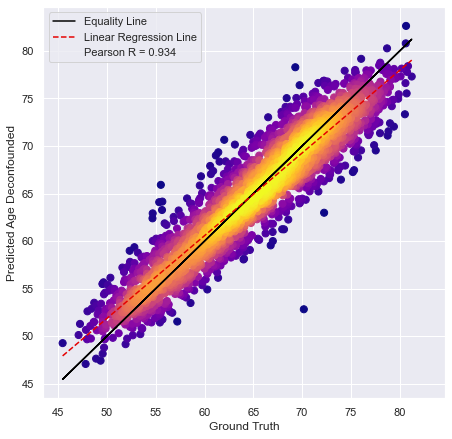

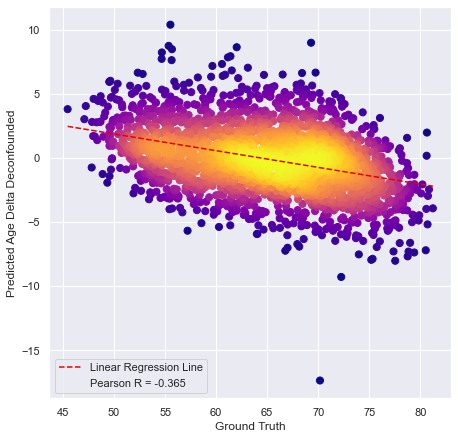

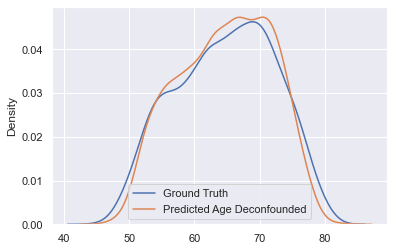

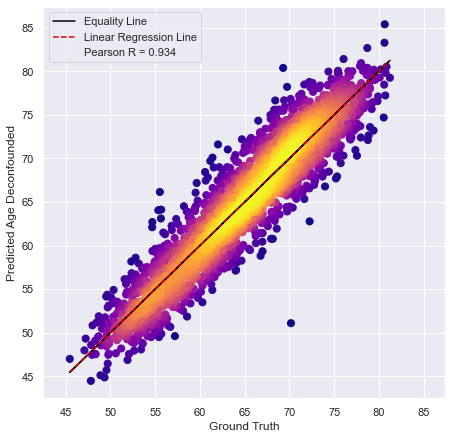

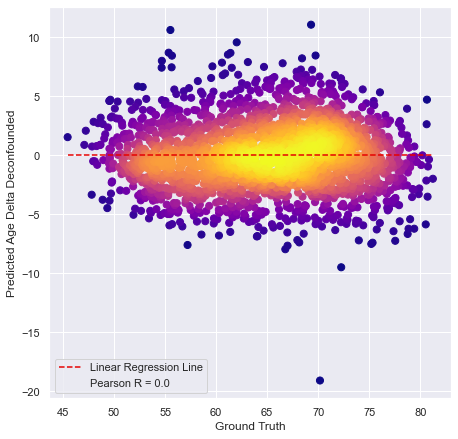

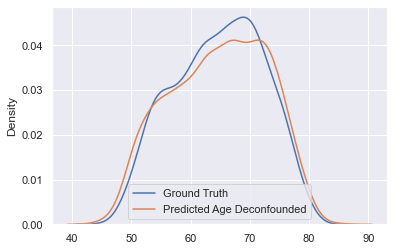

In [8]:
reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon = ElasticNet_wrap(
                    df_train, df_test, number_of_modalities=None, show_plots=True, verbose=True, 
                    cross_validation_flag = False, deconfound=True)

1.0876868768554853
-5.628339072122401


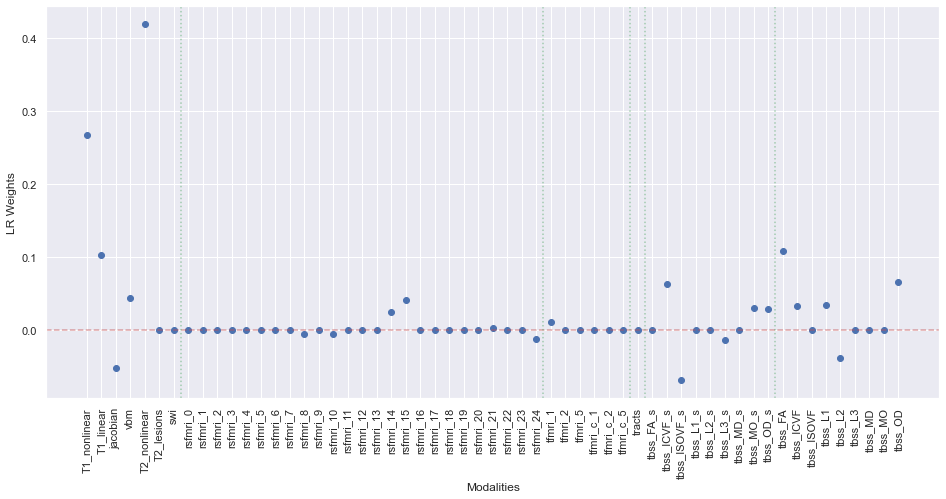

In [10]:
plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), df.modality.to_list(), rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5);
print(coefficients.sum())
print(reg.intercept_)

MAE= 2.1266141519592003
PR= 0.9340601645757096
Time To Complete: 0:00:24.116338
MAE Decon= 2.279200946541827
PR Decon= 0.9340601645757104


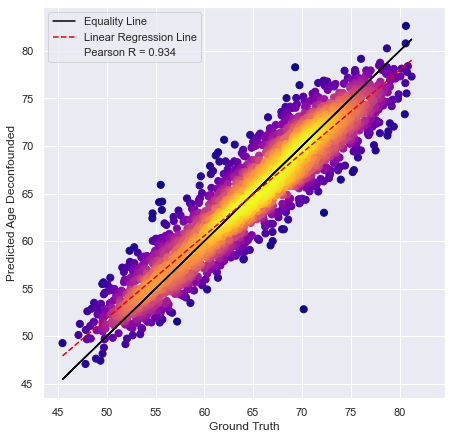

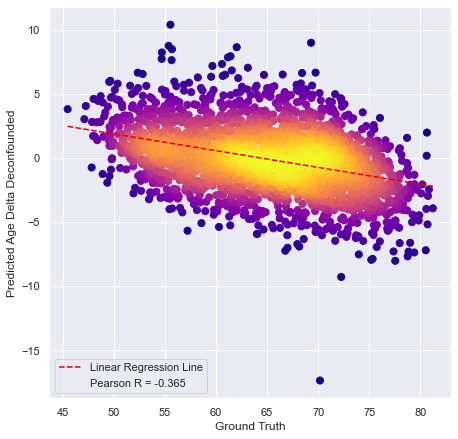

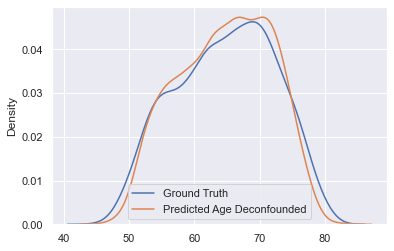

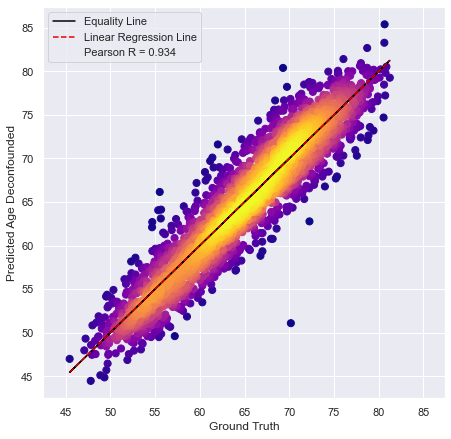

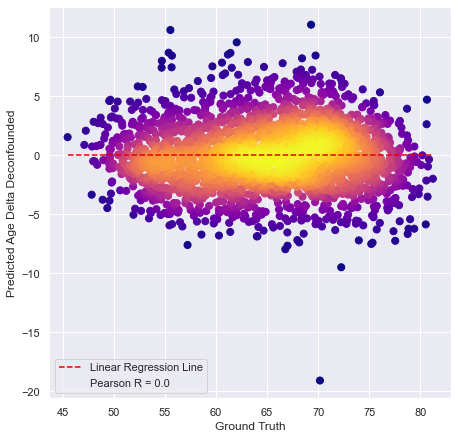

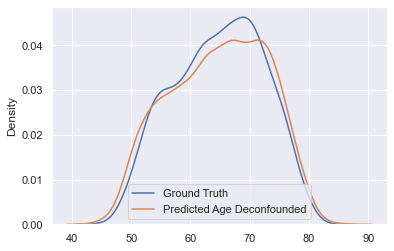

In [45]:
reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon = ElasticNet_wrap(
                    df_train, df_test, number_of_modalities=None, show_plots=True, verbose=True, 
                    cross_validation_flag = True, fix_alpha_one=False, deconfound=True)

1.0871507207503517
-5.588131074985512
0.17458415572072353 0.67


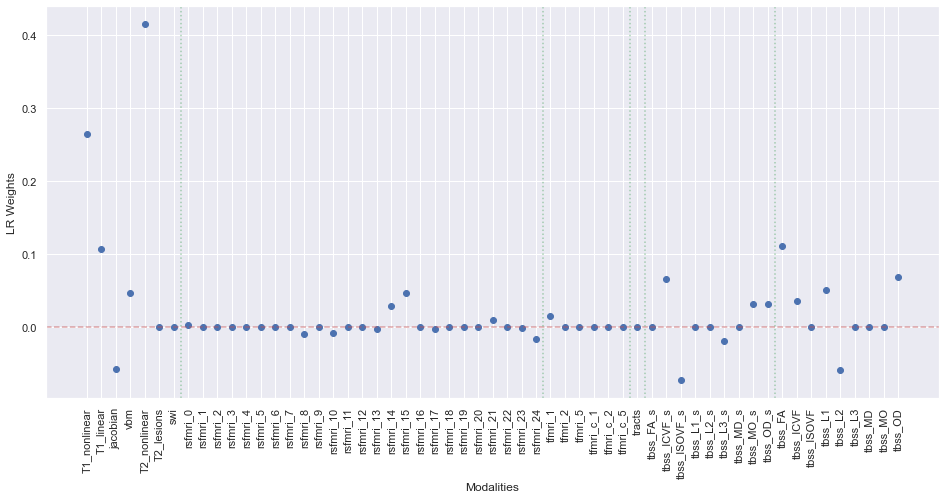

In [46]:
plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), df.modality.to_list(), rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5);
print(coefficients.sum())
print(reg.intercept_)
print(reg.alpha_, reg.l1_ratio_)

MAE= 2.126614151959201
PR= 0.9340601645757087
Time To Complete: 0:00:00.024206
MAE Decon= 2.279200946541828
PR Decon= 0.9340601645757087


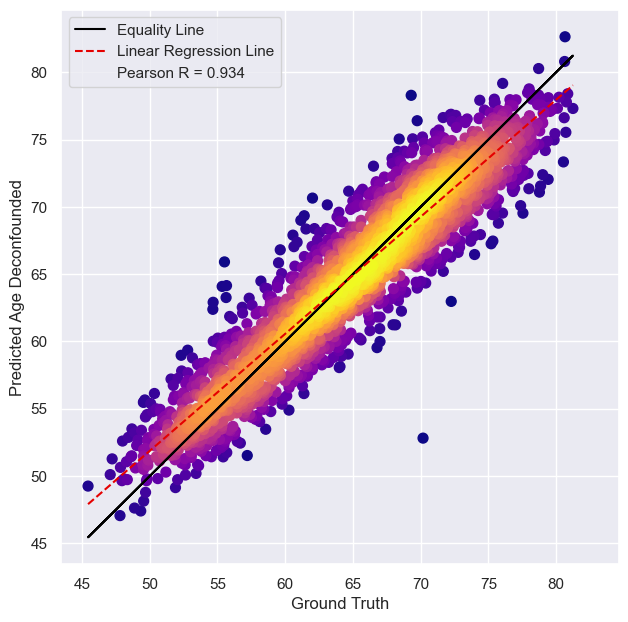

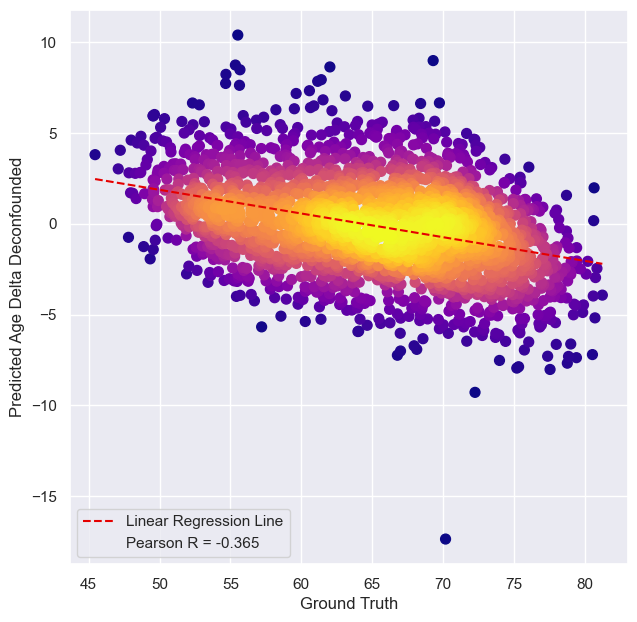

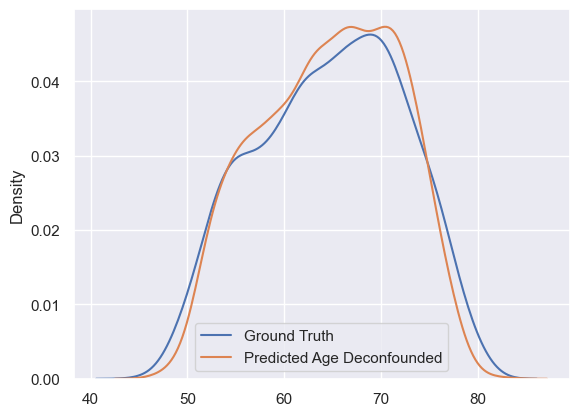

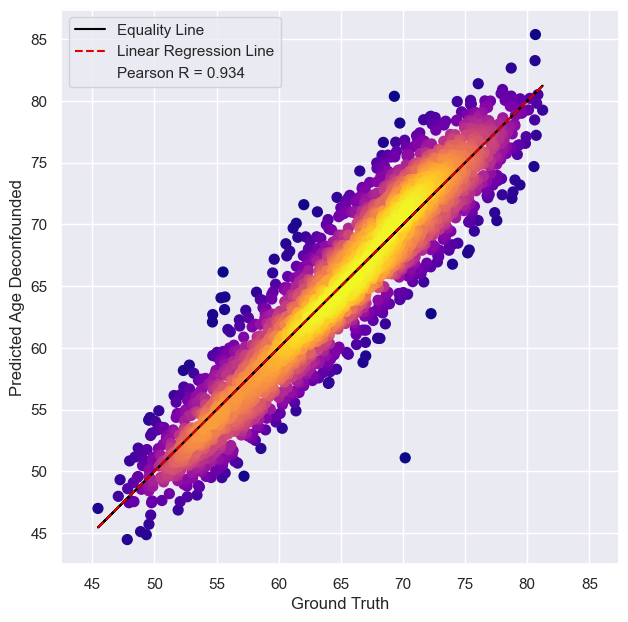

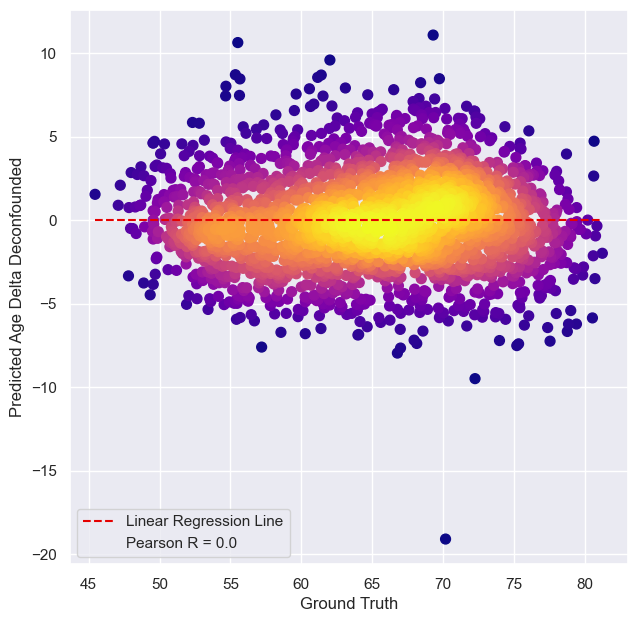

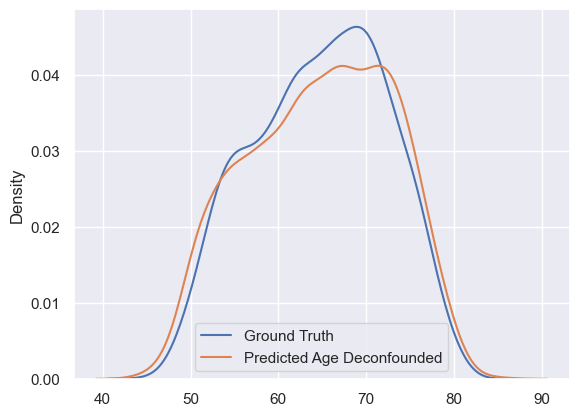

In [10]:
reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon, Yhat, Age_Deltas = ElasticNet_wrap(
                    df_train, df_test, number_of_modalities=None, show_plots=True, verbose=True, 
                    cross_validation_flag = False, deconfound=True)

1.0871507207503517
-5.5881310749854975


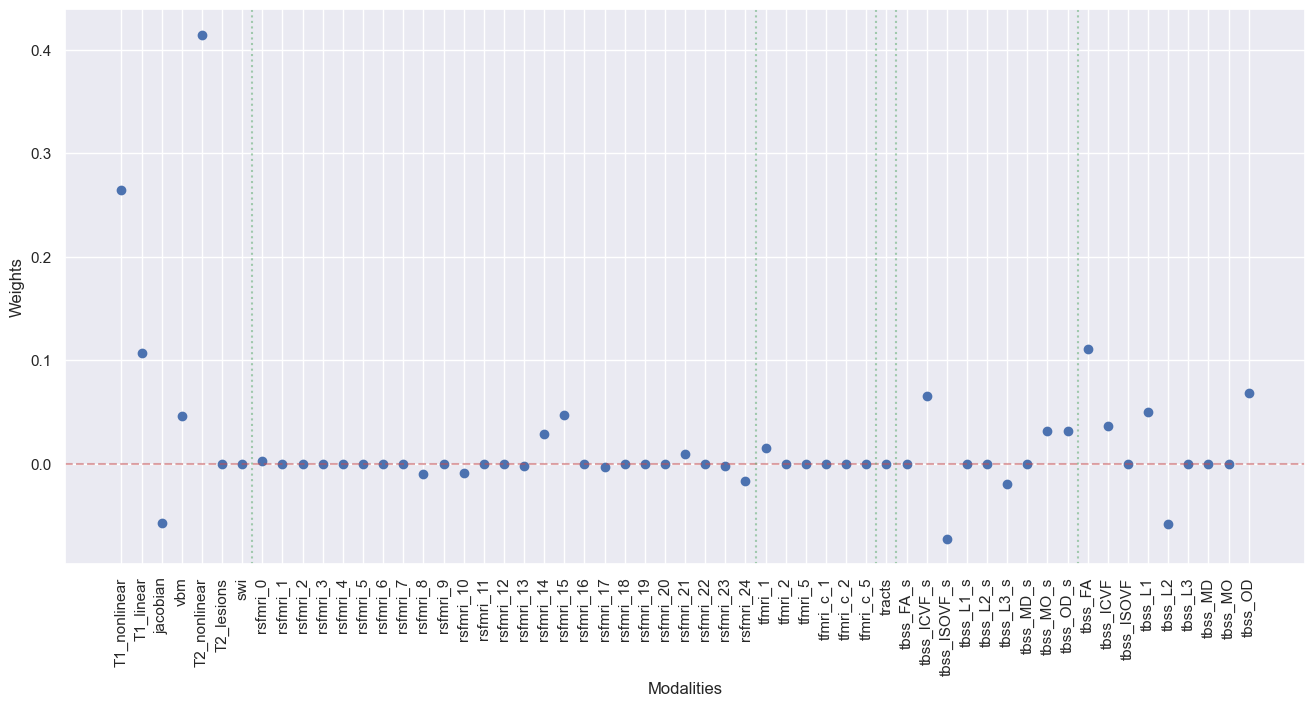

In [11]:
plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), df.modality.to_list(), rotation=90);
plt.xlabel("Modalities")
plt.ylabel("Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5);
print(coefficients.sum())
print(reg.intercept_)

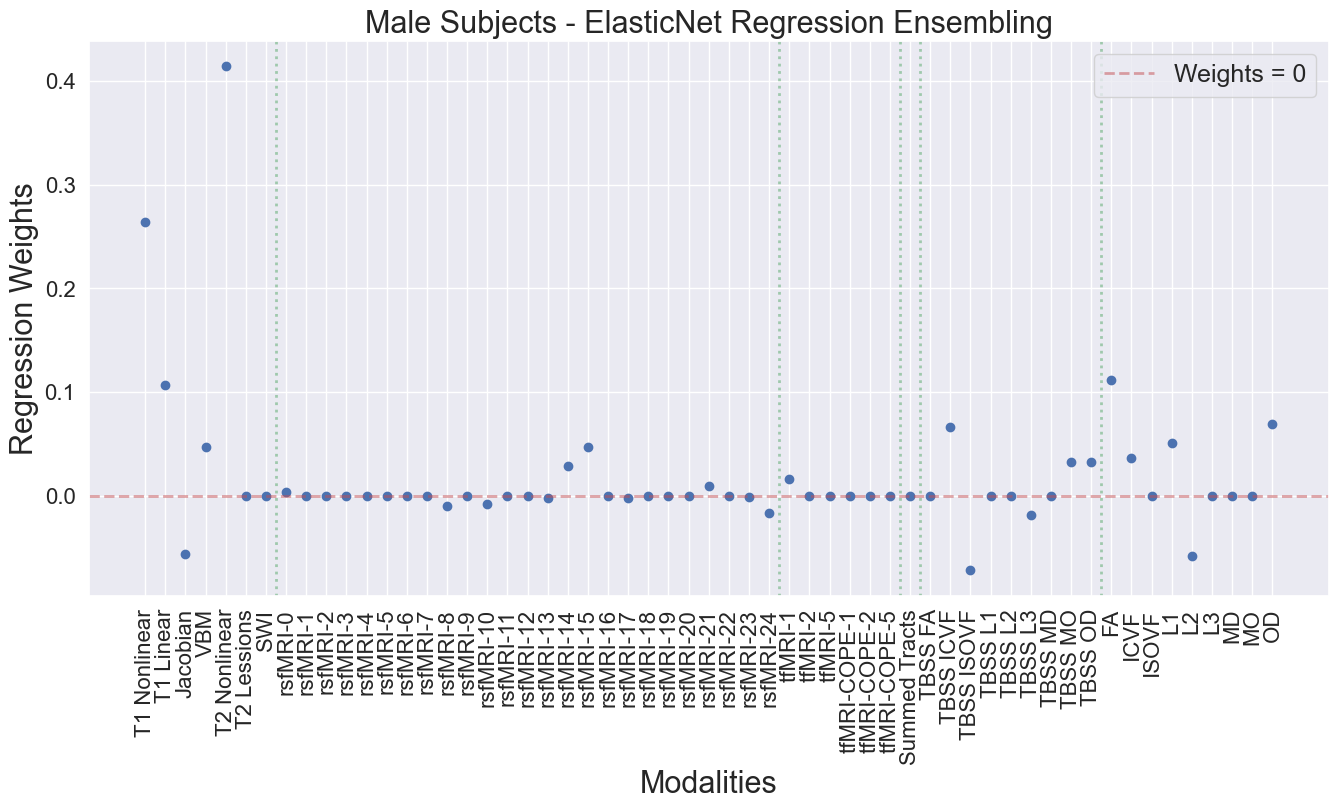

In [12]:
title_font_size=22
ticks_font_size=16
legend_font = 18
# figsize=(16, 9.6)

namesNN = [
    'T1 Nonlinear', 'T1 Linear', 'Jacobian', 'VBM', 'T2 Nonlinear', 'T2 Lessions', 'SWI', 'rsfMRI-0', 'rsfMRI-1',
    'rsfMRI-2', 'rsfMRI-3', 'rsfMRI-4', 'rsfMRI-5', 'rsfMRI-6', 'rsfMRI-7', 'rsfMRI-8', 'rsfMRI-9', 'rsfMRI-10', 
    'rsfMRI-11', 'rsfMRI-12', 'rsfMRI-13', 'rsfMRI-14', 'rsfMRI-15', 'rsfMRI-16', 'rsfMRI-17', 'rsfMRI-18', 'rsfMRI-19',
    'rsfMRI-20', 'rsfMRI-21', 'rsfMRI-22', 'rsfMRI-23', 'rsfMRI-24', 'tfMRI-1', 'tfMRI-2', 'tfMRI-5', 'tfMRI-COPE-1',
    'tfMRI-COPE-2', 'tfMRI-COPE-5', 'Summed Tracts', 'TBSS FA', 'TBSS ICVF', 'TBSS ISOVF', 'TBSS L1', 'TBSS L2',
    'TBSS L3', 'TBSS MD', 'TBSS MO', 'TBSS OD', 'FA', 'ICVF', 'ISOVF', 'L1', 'L2', 'L3', 'MD', 'MO', 'OD'
]

fig = plt.figure(figsize=(16, 7.2))

plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), namesNN, rotation=90, fontsize= ticks_font_size);
plt.xlabel("Modalities", fontsize=title_font_size)
plt.yticks(fontsize=ticks_font_size)
plt.ylabel("Regression Weights", fontsize=title_font_size)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='Weights = 0');
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);

plt.legend(loc=1, fontsize=legend_font)

plt.title('Male Subjects - ElasticNet Regression Ensembling', fontsize=title_font_size)

fig.savefig('Male_elastic_net_weights.png', bbox_inches='tight')





In [13]:
original_coefficients = np.copy(coefficients)
original_mae_decon = np.copy(mae_decon)

In [17]:
df_output = pd.DataFrame.from_dict({
    'modality': 'ElasticNetFull',
    'dataframe': [pd.DataFrame.from_dict({
                'Unnamed: 0': subjects_testB,
                'age_delta_decon': Age_Deltas_decon,
                'mean_age_delta': Age_Deltas,
                'target_age': df_testB.target_age.values,
                'mean_output_age': Yhat
                })]
})

output_name = 'male_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        pass
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)

In [18]:
output_name = 'male_ensembles_testset.pkl'
df_ensambles = pd.read_pickle(output_name)
df_ensambles

modality                                          dataframe
0             NaiveFull        Unnamed: 0  age_delta_decon  mean_age_de...
0  LinearRegressionFull        Unnamed: 0  age_delta_decon  mean_age_de...
0        ElasticNetFull        Unnamed: 0  age_delta_decon  mean_age_de...

In [20]:
abs(df_ensambles.iloc[2].dataframe.age_delta_decon).mean()

2.279200946541828

In [21]:
abs(df_ensambles.iloc[1].dataframe.age_delta_decon).mean()

2.272946466891487

In [22]:
abs(df_ensambles.iloc[0].dataframe.age_delta_decon).mean()

3.127146155861876

In [23]:
df_ensambles

modality                                          dataframe
0             NaiveFull        Unnamed: 0  age_delta_decon
0       2284...
0  LinearRegressionFull        Unnamed: 0  age_delta_decon
0       2284...
0        ElasticNetFull        Unnamed: 0  age_delta_decon
0       2284...

# K-Fold Cross Validation

In [14]:
from sklearn.model_selection import KFold

In [15]:
df_train.head()

T1_nonlinear  T1_linear   jacobian        vbm  T2_nonlinear  T2_lesions  \
1588     71.148967  68.758153  61.669696  64.744407     68.486633   71.360700   
935      72.722655  74.274728  73.627597  76.721025     72.708425   71.743233   
1450     53.217894  54.670809  59.846333  52.477524     53.091773   59.118936   
2512     74.175563  72.697128  74.099559  74.274790     76.285502   68.507303   
1353     51.269549  54.316068  55.047965  52.875921     52.832307   53.800731   

            swi   rsfmri_0   rsfmri_1   rsfmri_2  ...    tbss_FA  tbss_ICVF  \
1588  61.890867  65.599383  65.690795  62.132266  ...  67.909127  64.590390   
935   77.293670  70.248365  72.634313  69.213218  ...  72.908250  75.025737   
1450  59.535689  66.382952  64.171692  65.664289  ...  54.274742  55.345449   
2512  74.087580  73.800220  74.171987  72.693825  ...  74.826955  74.367054   
1353  54.469474  58.777314  56.815188  57.829699  ...  52.358435  51.214033   

      tbss_ISOVF    tbss_L1    tbss_L2    tbss_L3    tbss_MD    tbss_MO  \
1588   69.591637  67.349990  66.998962  67.754927  67.844347  69.083805   
935    73.012710  70.210583  70.535967  70.304587  69.676443  68.894653   
1450   50.212408  52.080364  51.377991  51.042342  51.875048  57.676217   
2512   71.739193  73.452775  72.792558  72.229397  73.131657  74.697147   
1353   54.785422  54.488783  54.894757  55.669731  54.966000  51.753970   

        tbss_OD  target_age  
1588  65.371872   69.037100  
935   71.443407   73.034836  
1450  56.809871   56.950137  
2512  73.385949   74.185731  
1353  52.647824   46.675546  

[5 rows x 58 columns]

In [16]:
dct_coef = {}
i = 0
mae_decon_lst = []

kf = KFold(n_splits=5)
for train, test in kf.split(df_train):
    
    reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon, Yhat, Age_Deltas = ElasticNet_wrap(
                    df_train.iloc[train], df_test, number_of_modalities=None, 
                    show_plots=False, 
                    verbose=False, 
                    cross_validation_flag = False, deconfound=True)
    
    dct_coef[i] = coefficients
    i += 1
    mae_decon_lst.append(mae_decon)

In [17]:
df_coef = pd.DataFrame.from_dict(dct_coef)

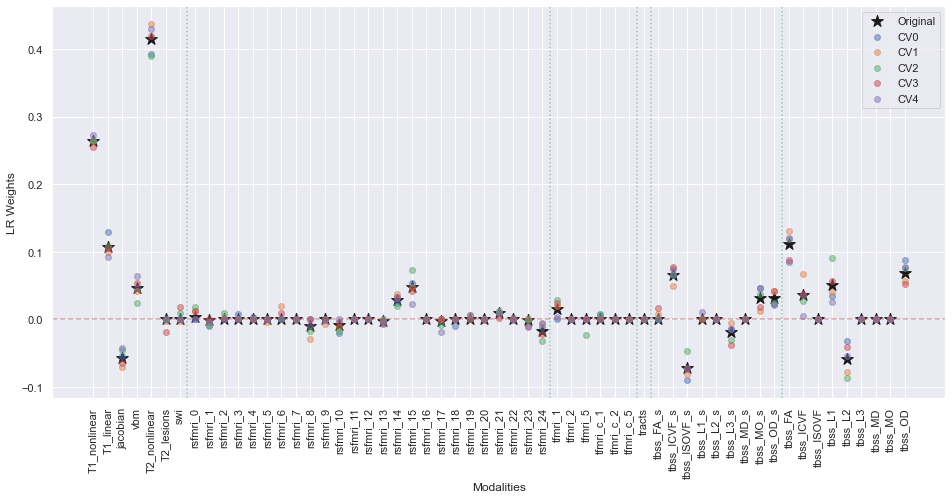

In [42]:
plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), original_coefficients, color='k', label= 'Original', s=150, marker='*')
for i in range(len(df_coef.columns)):
    plt.scatter(np.arange(0, Xtrain.shape[0]), df_coef[i], alpha=0.5, label='CV'+str(i))
plt.xticks(np.arange(0, Xtrain.shape[0]), df.modality.to_list(), rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5);
plt.legend()

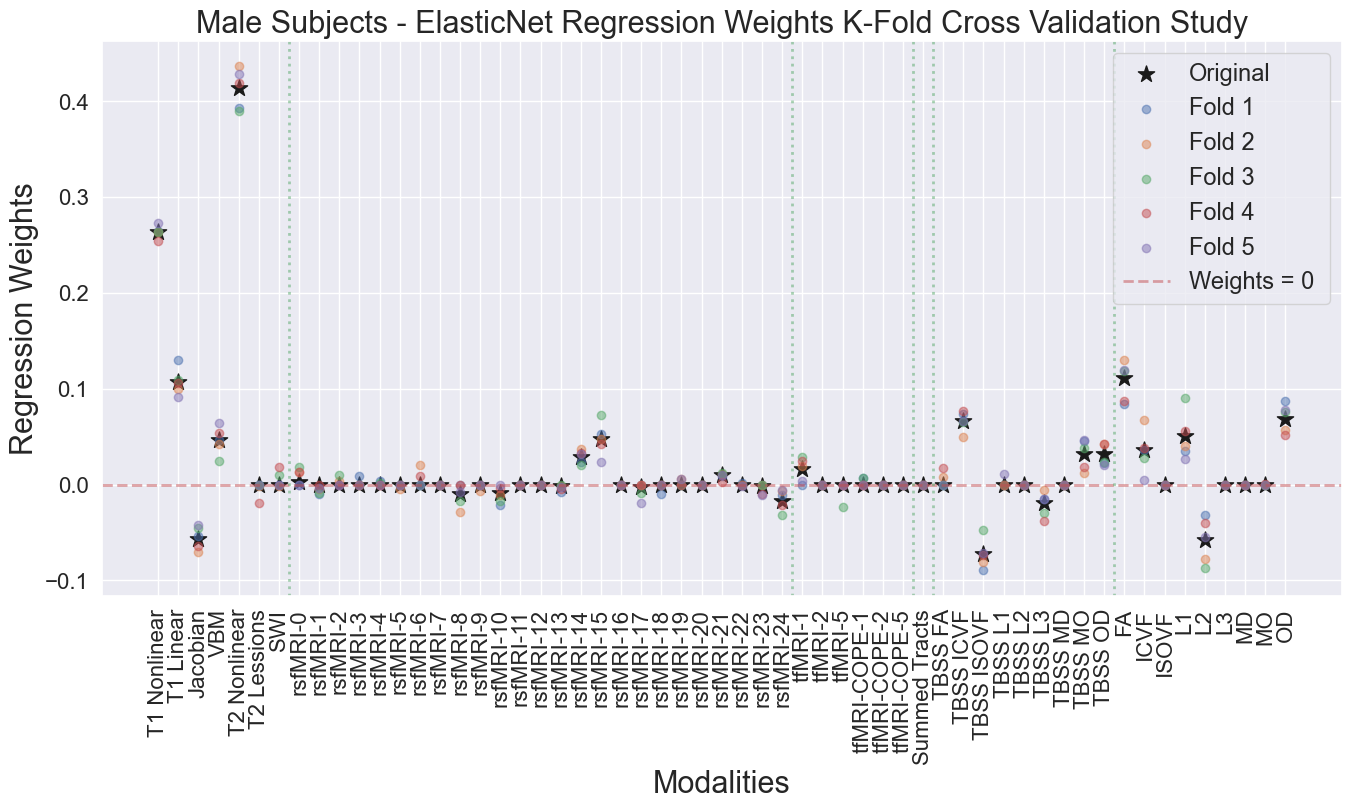

In [18]:
title_font_size=22
ticks_font_size=16
legend_font = 18
# figsize=(16, 9.6)

namesNN = [
    'T1 Nonlinear', 'T1 Linear', 'Jacobian', 'VBM', 'T2 Nonlinear', 'T2 Lessions', 'SWI', 'rsfMRI-0', 'rsfMRI-1',
    'rsfMRI-2', 'rsfMRI-3', 'rsfMRI-4', 'rsfMRI-5', 'rsfMRI-6', 'rsfMRI-7', 'rsfMRI-8', 'rsfMRI-9', 'rsfMRI-10', 
    'rsfMRI-11', 'rsfMRI-12', 'rsfMRI-13', 'rsfMRI-14', 'rsfMRI-15', 'rsfMRI-16', 'rsfMRI-17', 'rsfMRI-18', 'rsfMRI-19',
    'rsfMRI-20', 'rsfMRI-21', 'rsfMRI-22', 'rsfMRI-23', 'rsfMRI-24', 'tfMRI-1', 'tfMRI-2', 'tfMRI-5', 'tfMRI-COPE-1',
    'tfMRI-COPE-2', 'tfMRI-COPE-5', 'Summed Tracts', 'TBSS FA', 'TBSS ICVF', 'TBSS ISOVF', 'TBSS L1', 'TBSS L2',
    'TBSS L3', 'TBSS MD', 'TBSS MO', 'TBSS OD', 'FA', 'ICVF', 'ISOVF', 'L1', 'L2', 'L3', 'MD', 'MO', 'OD'
]

fig = plt.figure(figsize=(16, 7.2))

plt.scatter(np.arange(0, Xtrain.shape[0]), original_coefficients, color='k', label= 'Original', s=150, marker='*')
for i in range(len(df_coef.columns)):
    plt.scatter(np.arange(0, Xtrain.shape[0]), df_coef[i], alpha=0.5, label='Fold '+str(i+1))

plt.xticks(np.arange(0, Xtrain.shape[0]), namesNN, rotation=90, fontsize= ticks_font_size);
plt.xlabel("Modalities", fontsize=title_font_size)
plt.yticks(fontsize=ticks_font_size)
plt.ylabel("Regression Weights", fontsize=title_font_size)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='Weights = 0 ');
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);

plt.legend(loc=1, fontsize=legend_font-1)

plt.title('Male Subjects - ElasticNet Regression Weights K-Fold Cross Validation Study', fontsize=title_font_size)

fig.savefig('Male_elastic_net_weights_cross_validation.png', bbox_inches='tight')




In [19]:
print(np.mean(mae_decon_lst))
print(mae_decon_lst)

2.2803628093376345
[2.2869237319646696, 2.282985380931116, 2.277073567898795, 2.2708630659215516, 2.2839682999720425]


2.2787438122689374


Text(0.5, 0, 'ElasticNet MAE')

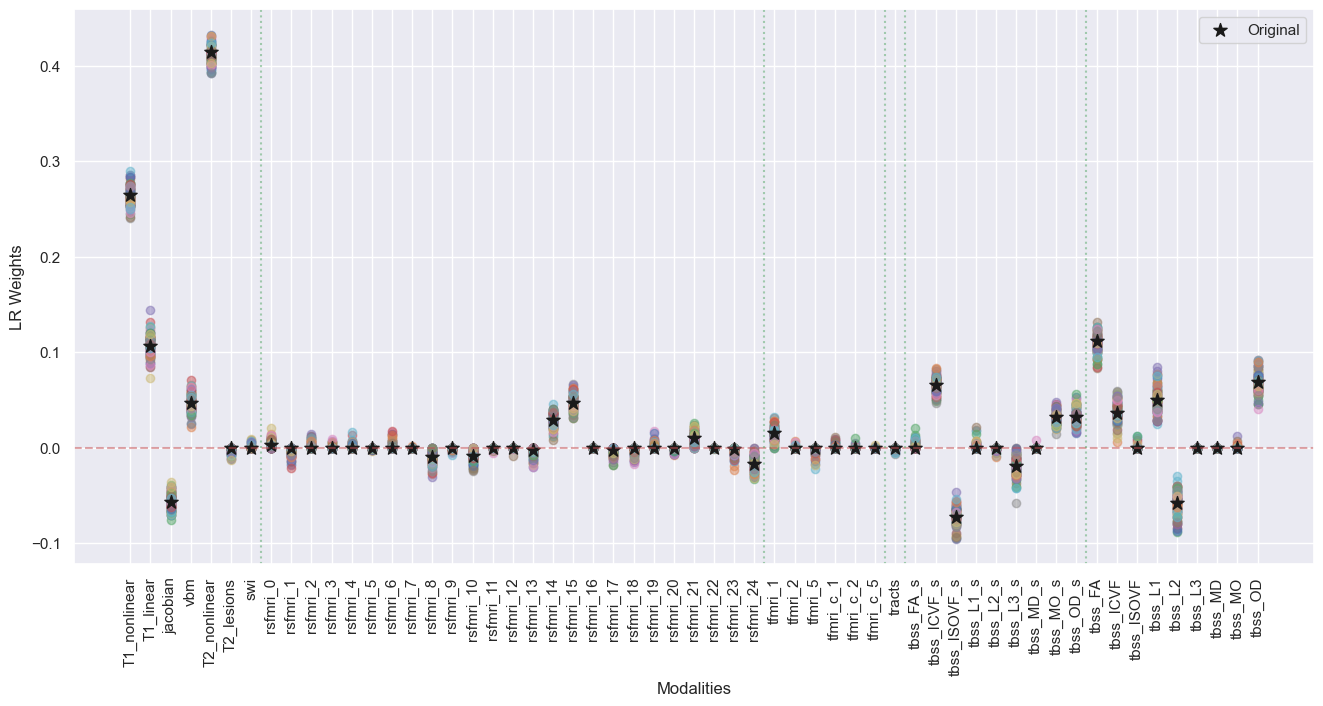

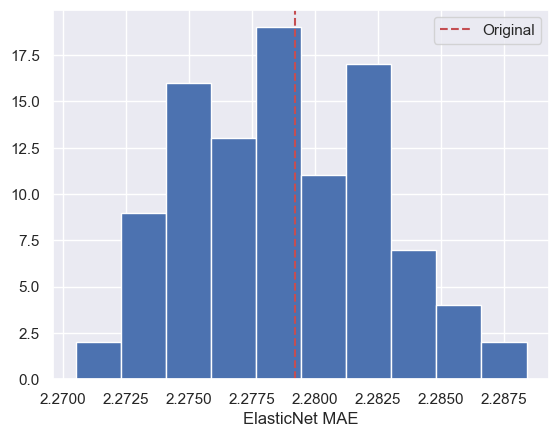

In [20]:
from sklearn.model_selection import ShuffleSplit

dct_coef = {}
i = 0
mae_decon_lst = []

kf = ShuffleSplit(n_splits=100)
for train, test in kf.split(df_train):
    
    reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon, Yhat, Age_Deltas = ElasticNet_wrap(
                    df_train.iloc[train], df_test, number_of_modalities=None, 
                    show_plots=False, 
                    verbose=False, 
                    cross_validation_flag = False, deconfound=True)
    
    dct_coef[i] = coefficients
    i += 1
    mae_decon_lst.append(mae_decon)
    
df_coef = pd.DataFrame.from_dict(dct_coef)

plt.figure(figsize=(16, 7.2))
for i in range(len(df_coef.columns)):
    plt.scatter(np.arange(0, Xtrain.shape[0]), df_coef[i], alpha=0.5) #, label='run'+str(i))
plt.scatter(np.arange(0, Xtrain.shape[0]), original_coefficients, color='k', s=100, label= 'Original', marker='*', zorder=1)

plt.xticks(np.arange(0, Xtrain.shape[0]), df.modality.to_list(), rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5);
plt.legend()

print(np.mean(mae_decon_lst))
# print(mae_decon_lst)
plt.figure()
plt.hist(mae_decon_lst);
plt.axvline(x=original_mae_decon, color='r', linestyle='--', label='Original')
plt.legend()
plt.xlabel('ElasticNet MAE')

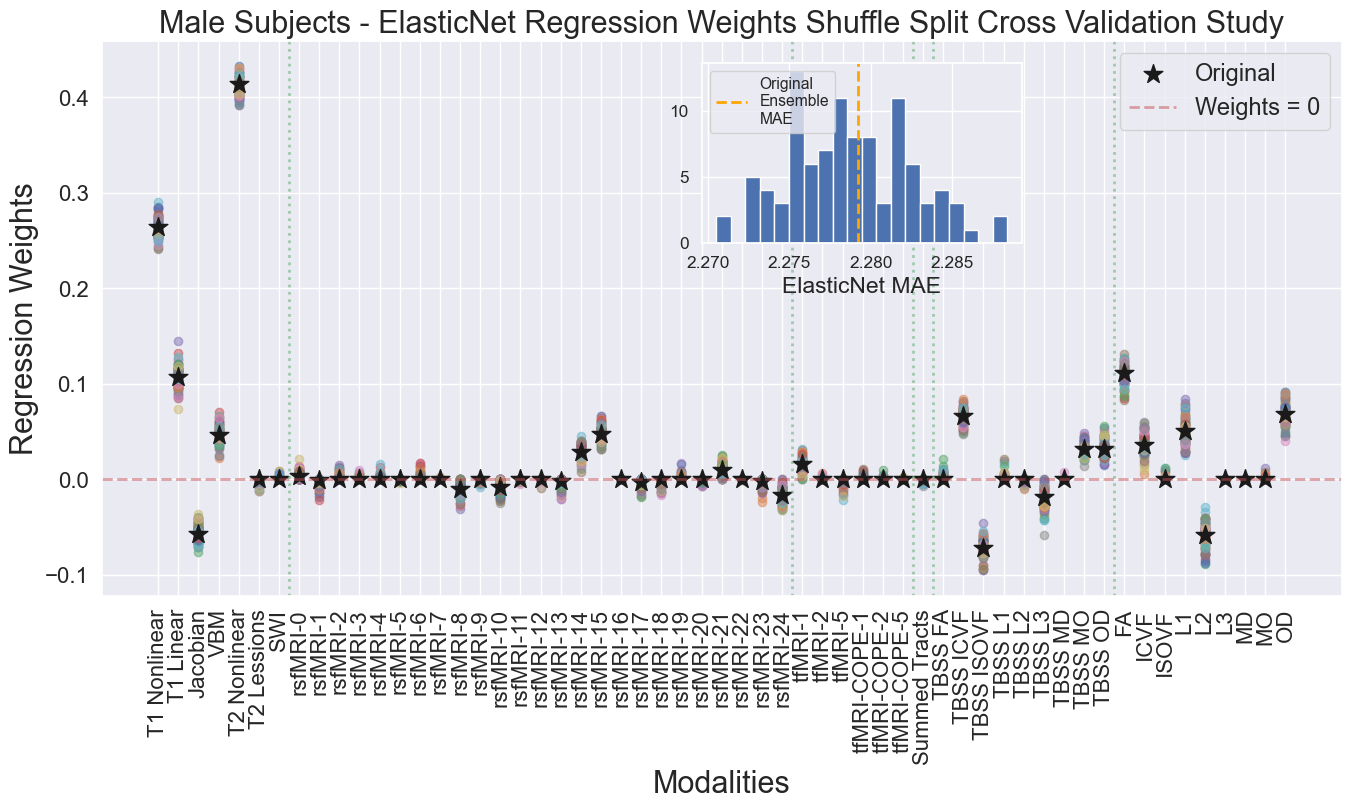

In [21]:
title_font_size=22
ticks_font_size=16
legend_font = 18
# figsize=(16, 9.6)

namesNN = [
    'T1 Nonlinear', 'T1 Linear', 'Jacobian', 'VBM', 'T2 Nonlinear', 'T2 Lessions', 'SWI', 'rsfMRI-0', 'rsfMRI-1',
    'rsfMRI-2', 'rsfMRI-3', 'rsfMRI-4', 'rsfMRI-5', 'rsfMRI-6', 'rsfMRI-7', 'rsfMRI-8', 'rsfMRI-9', 'rsfMRI-10', 
    'rsfMRI-11', 'rsfMRI-12', 'rsfMRI-13', 'rsfMRI-14', 'rsfMRI-15', 'rsfMRI-16', 'rsfMRI-17', 'rsfMRI-18', 'rsfMRI-19',
    'rsfMRI-20', 'rsfMRI-21', 'rsfMRI-22', 'rsfMRI-23', 'rsfMRI-24', 'tfMRI-1', 'tfMRI-2', 'tfMRI-5', 'tfMRI-COPE-1',
    'tfMRI-COPE-2', 'tfMRI-COPE-5', 'Summed Tracts', 'TBSS FA', 'TBSS ICVF', 'TBSS ISOVF', 'TBSS L1', 'TBSS L2',
    'TBSS L3', 'TBSS MD', 'TBSS MO', 'TBSS OD', 'FA', 'ICVF', 'ISOVF', 'L1', 'L2', 'L3', 'MD', 'MO', 'OD'
]

fig, ax1 = plt.subplots(figsize=(16, 7.2))

for i in range(len(df_coef.columns)):
    ax1.scatter(np.arange(0, Xtrain.shape[0]), df_coef[i], alpha=0.5) #, label='run'+str(i))
ax1.scatter(np.arange(0, Xtrain.shape[0]), original_coefficients, color='k', s=200, label= 'Original', marker='*', zorder=1)

ax1.set_xticks(np.arange(0, Xtrain.shape[0]), namesNN, rotation=90, fontsize= ticks_font_size);
ax1.set_xlabel("Modalities", fontsize=title_font_size)
# ax1.set_yticks(fontsize=title_font_size)
ax1.tick_params(axis='both', which='major', labelsize=ticks_font_size)
ax1.set_ylabel("Regression Weights", fontsize=title_font_size)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='Weights = 0');
ax1.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
ax1.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
ax1.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
ax1.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
ax1.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);

ax1.legend(loc=1, fontsize=legend_font-1)

ax1.set_title('Male Subjects - ElasticNet Regression Weights Shuffle Split Cross Validation Study', fontsize=title_font_size)

pos_x, pos_y, h, w = 0.5, 0.6, .25, .2
ax2 = fig.add_axes([pos_x, pos_y, w, h])

ax2.hist(mae_decon_lst, bins=20);
ax2.axvline(x=original_mae_decon, color='orange', linestyle='--', linewidth=2, label='Original\nEnsemble\nMAE')
ax2.legend(fontsize=legend_font/4*2.5, loc=2)
ax2.set_xlabel('ElasticNet MAE', fontsize=title_font_size/4*3)
ax2.tick_params(axis='both', which='major', labelsize=ticks_font_size/4*3.1)

fig.savefig('Male_elastic_net_weights_sufflesplit_cross_validation.png', bbox_inches='tight')





# HERE BE DRAGONS! NOTHING ELSE!

## 1.1 Fitting a subclass of modalities, based on the observed performance from above

In [52]:
reg, coefficients, intercept, mae, pr, Xtrain, Ytrain, Xtest, Ytest, Yhat, Age_Deltas = ElasticNet_wrap(
                    df_train, df_test, number_of_modalities=None, show_plots=False, verbose=True, 
                    cross_validation_flag = False, deconfound=True)

coef_df = pd.DataFrame.from_dict({
    'modalities' : df.modality.to_list(),
    'coefficients' : coefficients
})

current_mods = coef_df.modalities.values
modality_names = [
    'T1 Nonlinear', 'T1 Linear', 'Jacobian', 'VBM', 'T2 Nonlinear', 'T2 Lessions', 'SWI', 'rsfMRI-0', 'rsfMRI-1',
    'rsfMRI-2', 'rsfMRI-3', 'rsfMRI-4', 'rsfMRI-5', 'rsfMRI-6', 'rsfMRI-7', 'rsfMRI-8', 'rsfMRI-9', 'rsfMRI-10', 
    'rsfMRI-11', 'rsfMRI-12', 'rsfMRI-13', 'rsfMRI-14', 'rsfMRI-15', 'rsfMRI-16', 'rsfMRI-17', 'rsfMRI-18', 'rsfMRI-19',
    'rsfMRI-20', 'rsfMRI-21', 'rsfMRI-22', 'rsfMRI-23', 'rsfMRI-24', 'tfMRI-1', 'tfMRI-2', 'tfMRI-5', 'tfMRI-COPE-1',
    'tfMRI-COPE-2', 'tfMRI-COPE-5', 'Summed Tracts', 'TBSS FA', 'TBSS ICVF', 'TBSS ISOVF', 'TBSS L1', 'TBSS L2',
    'TBSS L3', 'TBSS MD', 'TBSS MO', 'TBSS OD', 'FA', 'ICVF', 'ISOVF', 'L1', 'L2', 'L3', 'MD', 'MO', 'OD'
]
for idx, mod in enumerate(current_mods):
    coef_df.loc[coef_df["modalities"] == mod, "modalities"] = modality_names[idx]


coef_df['abs_coef'] = np.abs(coef_df.coefficients)
coef_df = coef_df.sort_values('abs_coef', ascending=False)

modality_labels = coef_df.modalities.values

reg, coefficients, intercept, mae, pr, Xtrain, Ytrain, Xtest, Ytest, Yhat, Age_Deltas = ElasticNet_wrap(
                    df_train, df_test, number_of_modalities=None, show_plots=False, verbose=True, 
                    cross_validation_flag = False, deconfound=True)

coef_df = pd.DataFrame.from_dict({
    'modalities' : df.modality.to_list(),
    'coefficients' : coefficients
})


coef_df['abs_coef'] = np.abs(coef_df.coefficients)
coef_df = coef_df.sort_values('abs_coef', ascending=False)
coef_df

MAE= 2.1266141519592003
PR= 0.9340601645757103
Time To Complete: 0:00:00.016260
MAE Decon= 2.279200946541829
PR Decon= 0.9340601645757101
MAE= 2.1266141519592003
PR= 0.9340601645757103
Time To Complete: 0:00:00.015105
MAE Decon= 2.279200946541829
PR Decon= 0.9340601645757101


modalities  coefficients  abs_coef
4   T2_nonlinear      0.414420  0.414420
0   T1_nonlinear      0.264206  0.264206
48       tbss_FA      0.111317  0.111317
1      T1_linear      0.106761  0.106761
41  tbss_ISOVF_s     -0.072048  0.072048
56       tbss_OD      0.068939  0.068939
40   tbss_ICVF_s      0.065910  0.065910
52       tbss_L2     -0.058274  0.058274
2       jacobian     -0.056784  0.056784
51       tbss_L1      0.050490  0.050490
22     rsfmri_15      0.047306  0.047306
3            vbm      0.046537  0.046537
49     tbss_ICVF      0.036264  0.036264
46     tbss_MO_s      0.032310  0.032310
47     tbss_OD_s      0.032057  0.032057
21     rsfmri_14      0.029053  0.029053
44     tbss_L3_s     -0.018852  0.018852
31     rsfmri_24     -0.016742  0.016742
32       tfmri_1      0.015855  0.015855
15      rsfmri_8     -0.009893  0.009893
28     rsfmri_21      0.009787  0.009787
17     rsfmri_10     -0.008313  0.008313
7       rsfmri_0      0.003161  0.003161
24     rsfmri_17     -0.002414  0.002414
20     rsfmri_13     -0.001913  0.001913
30     rsfmri_23     -0.001599  0.001599
8       rsfmri_1     -0.000390  0.000390
12      rsfmri_5     -0.000000  0.000000
42     tbss_L1_s      0.000000  0.000000
43     tbss_L2_s     -0.000000  0.000000
14      rsfmri_7      0.000000  0.000000
45     tbss_MD_s      0.000000  0.000000
13      rsfmri_6      0.000000  0.000000
55       tbss_MO      0.000000  0.000000
11      rsfmri_4      0.000000  0.000000
16      rsfmri_9     -0.000000  0.000000
50    tbss_ISOVF      0.000000  0.000000
9       rsfmri_2      0.000000  0.000000
53       tbss_L3     -0.000000  0.000000
54       tbss_MD      0.000000  0.000000
10      rsfmri_3      0.000000  0.000000
39     tbss_FA_s      0.000000  0.000000
19     rsfmri_12     -0.000000  0.000000
38        tracts     -0.000000  0.000000
37     tfmri_c_5      0.000000  0.000000
36     tfmri_c_2      0.000000  0.000000
35     tfmri_c_1      0.000000  0.000000
34       tfmri_5     -0.000000  0.000000
33       tfmri_2      0.000000  0.000000
18     rsfmri_11     -0.000000  0.000000
29     rsfmri_22      0.000000  0.000000
5     T2_lesions     -0.000000  0.000000
27     rsfmri_20     -0.000000  0.000000
26     rsfmri_19      0.000000  0.000000
25     rsfmri_18     -0.000000  0.000000
23     rsfmri_16     -0.000000  0.000000
6            swi      0.000000  0.000000

MAE= 2.1379330135594983
PR= 0.9332771562099581
Time To Complete: 0:00:00.006118
MAE Decon= 2.29045696237364
PR Decon= 0.9332771562099583


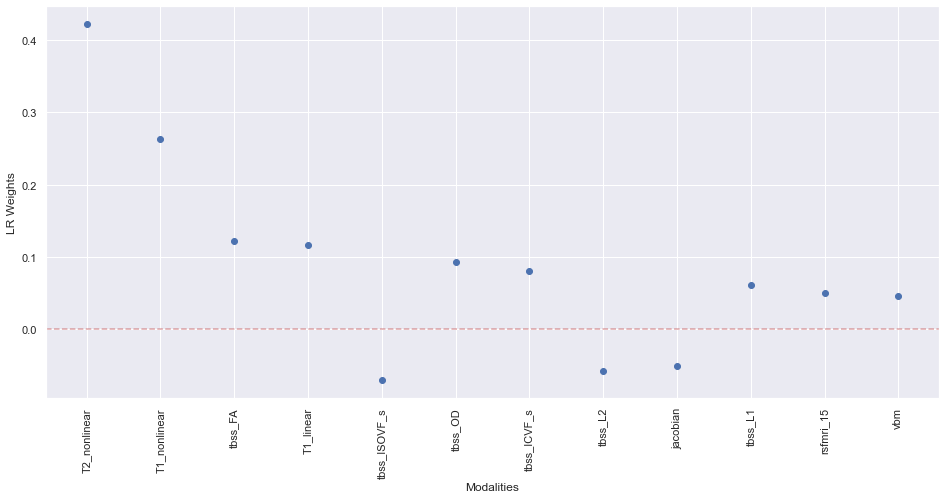

In [53]:
cutoff_weight = 0.04

misc_mod = coef_df[coef_df.abs_coef >= cutoff_weight].modalities.to_list()
x = ElasticNet_wrap(df_train, df_test, modalities=misc_mod, 
                              number_of_modalities=None, show_plots=False, verbose=True, 
                                cross_validation_flag = False, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), misc_mod, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

## 1.2 Fitting Variables Progressivelly, in order of Beta-Weight-Coef value

In [54]:
ordered_modalities0 = coef_df.modalities.to_list()

maes_list0 = []
number_of_modalities0 = []

for i in range(2, len(coef_df)+1):
    modalities0 = ordered_modalities0[:i]
    x = ElasticNet_wrap(df_train, df_test, modalities=modalities0, 
                              number_of_modalities=None, show_plots=False, verbose=False,
                       cross_validation_flag = False, deconfound=True)
    mae = x[3]    
    maes_list0.append(mae)
    number_of_modalities0.append(i)

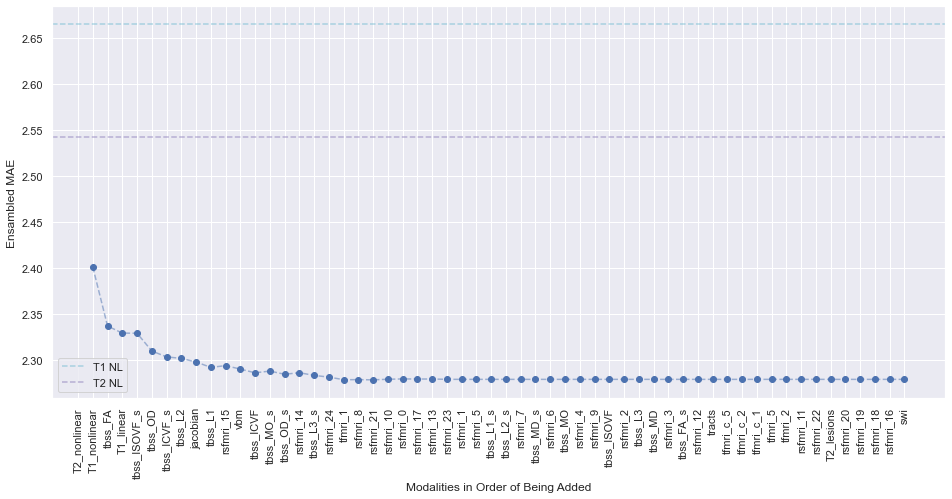

In [55]:
plt.figure(figsize=(16, 7.2))
plt.scatter(number_of_modalities0, maes_list0)
plt.plot(number_of_modalities0, maes_list0, 'b--', alpha=0.5)
plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalities0, rotation=90);
plt.xlabel("Modalities in Order of Being Added")
plt.ylabel("Ensambled MAE")
plt.axhline(y=2.665, color='c', linestyle='--', alpha=0.5, label='T1 NL');
plt.axhline(y=2.542, color='m', linestyle='--', alpha=0.5, label='T2 NL');
plt.legend()

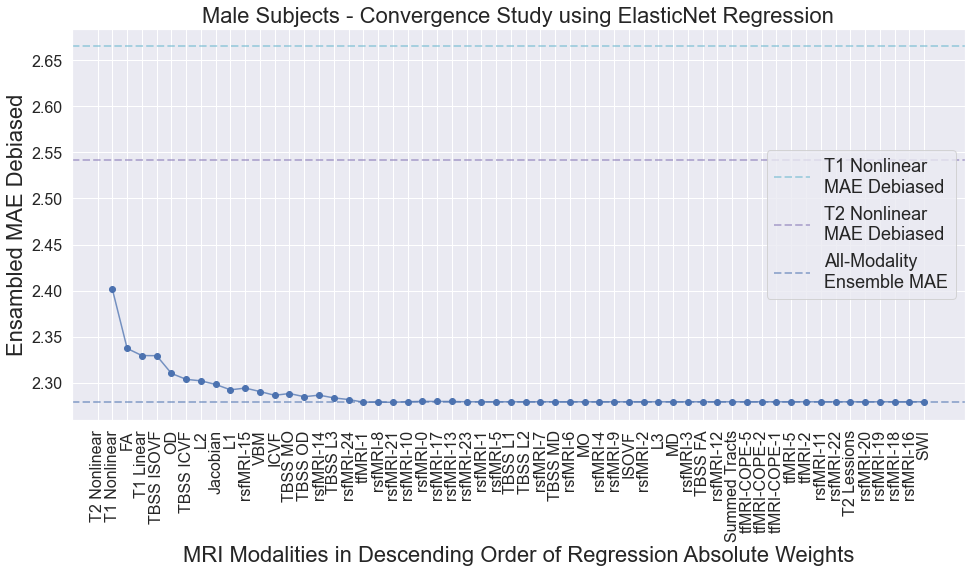

In [56]:
title_font_size=22
ticks_font_size=16
legend_font = 18
# figsize=(16, 9.6)

fig = plt.figure(figsize=(16, 7.2))
plt.scatter(number_of_modalities0, maes_list0)
plt.plot(number_of_modalities0, maes_list0, 'b-', alpha=0.75)
plt.xticks(np.arange(1, Xtrain.shape[0]+1), modality_labels, rotation=90, fontsize= ticks_font_size);
plt.yticks(fontsize=ticks_font_size);
plt.xlabel("MRI Modalities in Descending Order of Regression Absolute Weights", fontsize=title_font_size)
plt.ylabel("Ensambled MAE Debiased", fontsize=title_font_size)
plt.axhline(y=2.665, color='c', linestyle='--', alpha=0.5, label='T1 Nonlinear\nMAE Debiased', linewidth=2);
plt.axhline(y=2.542, color='m', linestyle='--', alpha=0.5, label='T2 Nonlinear\nMAE Debiased', linewidth=2);
plt.axhline(y=2.279200946541829, color='b', linestyle='--', alpha=0.5, label='All-Modality\nEnsemble MAE', linewidth=2);
plt.legend(loc='center right', fontsize=legend_font)

plt.title('Male Subjects - Convergence Study using ElasticNet Regression', fontsize=title_font_size)

fig.savefig('Male_elastic_net_convergence_study.png', bbox_inches='tight')




# 2. Fitting Variables Progressivelly, in order of best Test MAEs

In [38]:
modality_decon_maes = []

for idx in range(len(df)):
    modality_decon_mae = np.abs(df.iloc[idx].dataframe.age_delta_decon).mean()
    modality_decon_maes.append(modality_decon_mae)
    
mae_df = pd.DataFrame.from_dict({
    'modality': df.modality.to_list(),
    'mae_decon': modality_decon_maes
})

mae_df = mae_df.sort_values('mae_decon')
mae_df.head()

modality  mae_decon
4   T2_nonlinear   2.541832
0   T1_nonlinear   2.665029
1      T1_linear   2.738320
49     tbss_ICVF   3.071851
3            vbm   3.116403

In [39]:
ordered_modalities = mae_df.modality.to_list()
maes_list = []
prs_list = []
number_of_modalities = []

for i in range(2, len(mae_df)+1):
    modalities = ordered_modalities[:i]
    x = ElasticNet_wrap(df_train, df_test, modalities=modalities, 
                              number_of_modalities=None, show_plots=False, verbose=False,
                             cross_validation_flag = False, deconfound=True)
    mae = x[3]
    pr = x[4]
    maes_list.append(mae)
    prs_list.append(pr)
    number_of_modalities.append(i)

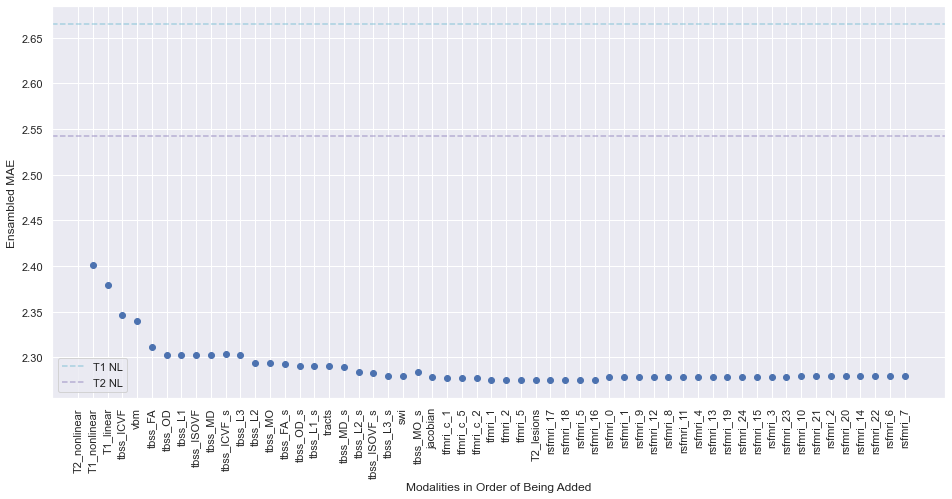

In [40]:
plt.figure(figsize=(16, 7.2))
plt.scatter(number_of_modalities, maes_list)
plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalities, rotation=90);
plt.xlabel("Modalities in Order of Being Added")
plt.ylabel("Ensambled MAE")
plt.axhline(y=2.665, color='c', linestyle='--', alpha=0.5, label='T1 NL');
plt.axhline(y=2.542, color='m', linestyle='--', alpha=0.5, label='T2 NL');
plt.legend()

# 3. Fitting Variables Progressivelly, in order of best Train MAEs

In [41]:
# modality_decon_maest = []

# for idx in range(len(dft)):
#     modality_decon_maet = np.abs(dft.iloc[idx].dataframe.age_delta_decon).mean()
#     modality_decon_maest.append(modality_decon_maet)
    
# mae_dft = pd.DataFrame.from_dict({
#     'modality': dft.modality.to_list(),
#     'mae_decon': modality_decon_maest
# })

# mae_dft = mae_dft.sort_values('mae_decon')
# mae_dft.head()

In [42]:
# ordered_modalitiest = mae_dft.modality.to_list()
# maes_listt = []
# number_of_modalitiest = []

# for i in range(2, len(mae_df)+1):
#     modalities = ordered_modalitiest[:i]
#     x = ElasticNet_wrap(df_train, df_test, modalities=modalities, 
#                               number_of_modalities=None, show_plots=False, verbose=False,
#                        cross_validation_flag = False, deconfound=True)
#     mae = x[3]
#     maes_listt.append(mae)
#     number_of_modalitiest.append(i)

In [43]:
# plt.figure(figsize=(16, 7.2))
# plt.scatter(number_of_modalitiest, maes_listt)
# plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalitiest, rotation=90);
# plt.xlabel("Modalities in Order of Being Added")
# plt.ylabel("Ensambled MAE")
# plt.axhline(y=2.665, color='c', linestyle='--', alpha=0.5, label='T1 NL');
# plt.axhline(y=2.542, color='m', linestyle='--', alpha=0.5, label='T2 NL');
# plt.legend()

# 4. Fit Model to subgroups of variables (Notebook 4)

In [44]:
custom_modalities = ['T1_nonlinear', 'rsfmri_0', 'tfmri_1', 'tracts', 'tbss_FA']
custom_modalities_2 = ['T2_nonlinear', 'rsfmri_0', 'tfmri_1', 'tracts', 'tbss_ICVF']
custom_modalities_3 = ['T1_nonlinear', 'T2_nonlinear', 'swi', 'tracts', 'rsfmri_0', 'tfmri_1']

MAE= 2.3105465314072418
PR= 0.9228030365733703
Time To Complete: 0:00:00.001305
MAE Decon= 2.491360045469428
PR Decon= 0.9228030365733704


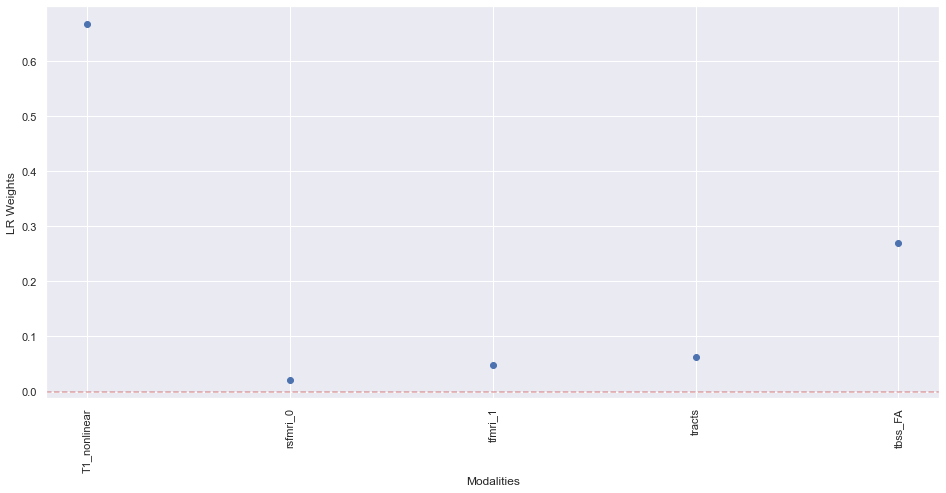

In [45]:
x = ElasticNet_wrap(df_train, df_test, modalities=custom_modalities, 
                              number_of_modalities=None, show_plots=False, verbose=True,
                         cross_validation_flag = False, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), custom_modalities, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

MAE= 2.2153112578481213
PR= 0.9280179605819213
Time To Complete: 0:00:00.001359
MAE Decon= 2.400740344768797
PR Decon= 0.9280179605819213


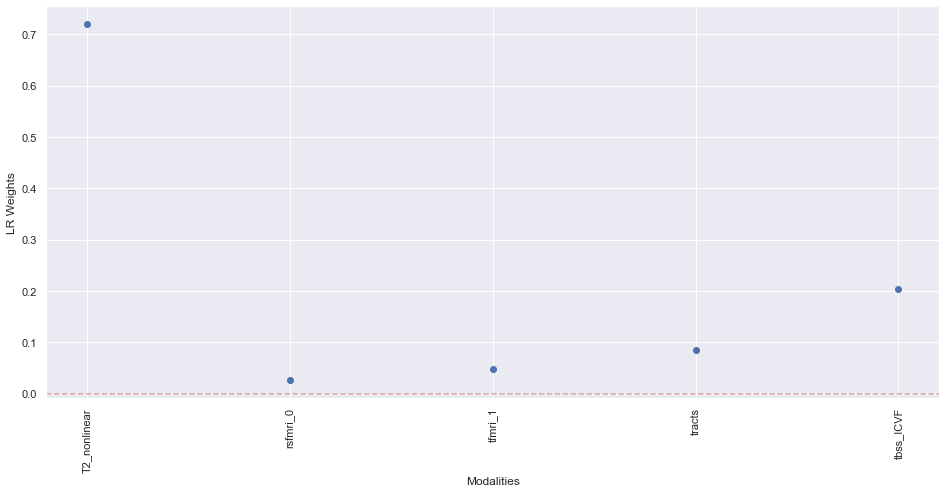

In [46]:
x = ElasticNet_wrap(df_train, df_test, modalities=custom_modalities_2, 
                              number_of_modalities=None, show_plots=False, verbose=True,
                   cross_validation_flag = False, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), custom_modalities_2, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

MAE= 2.1966811317053425
PR= 0.9300976306015492
Time To Complete: 0:00:00.002087
MAE Decon= 2.3688004180120243
PR Decon= 0.9300976306015492


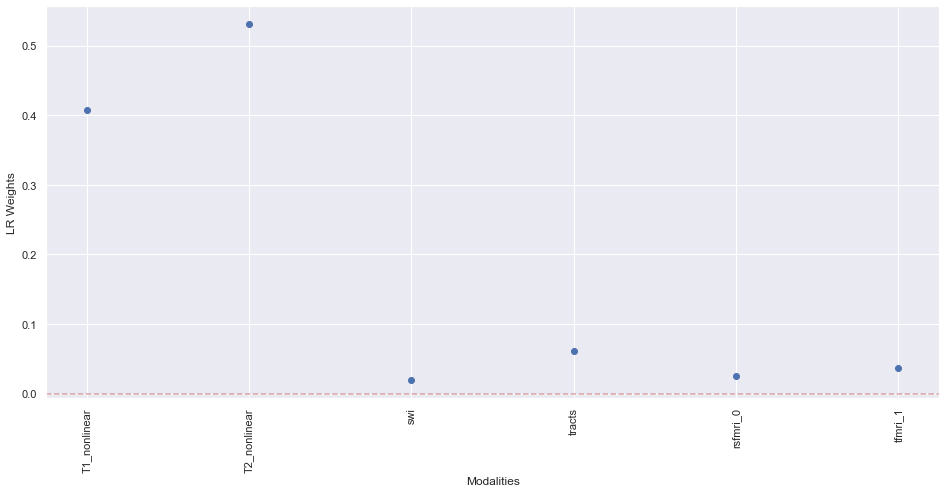

In [47]:
x = ElasticNet_wrap(df_train, df_test, modalities=custom_modalities_3, 
                              number_of_modalities=None, show_plots=False, verbose=True,
                         cross_validation_flag = False, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), custom_modalities_3, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

In [48]:
df_test.head()

T1_nonlinear  T1_linear   jacobian        vbm  T2_nonlinear  T2_lesions  \
1995     70.301960  71.880307  69.838718  73.728143     73.898550   72.442627   
2682     65.544842  63.974553  62.261400  63.022292     67.380870   61.355960   
1117     65.903570  65.495730  61.712228  65.155408     63.115961   64.414018   
2651     69.497883  73.795662  68.981087  66.932085     68.470500   72.342867   
2346     53.809285  57.470562  60.224921  56.306926     59.614605   57.104562   

            swi   rsfmri_0   rsfmri_1   rsfmri_2  ...    tbss_FA  tbss_ICVF  \
1995  66.486627  64.960093  69.834643  62.343770  ...  64.774132  72.619850   
2682  65.141727  66.513993  69.161137  60.986258  ...  63.446062  65.282101   
1117  59.111989  61.315363  59.037748  60.713749  ...  62.385809  64.182630   
2651  67.238942  67.130893  71.601157  68.807543  ...  70.124750  69.249878   
2346  63.387025  57.299523  60.204006  62.027384  ...  55.425612  56.049117   

      tbss_ISOVF    tbss_L1    tbss_L2    tbss_L3    tbss_MD    tbss_MO  \
1995   71.585567  73.181622  73.025147  74.976455  71.628845  69.588323   
2682   65.646513  65.543627  66.599290  66.317293  65.595615  65.108424   
1117   62.296586  66.467493  66.108393  66.276078  65.761343  63.206968   
2651   70.717260  68.251463  71.317583  71.792955  70.097964  69.983847   
2346   58.145698  59.213595  61.731932  62.031764  61.779696  58.838508   

        tbss_OD  target_age  
1995  74.340763   77.611986  
2682  65.091057   62.389384  
1117  65.244336   66.140753  
2651  69.884533   68.352169  
2346  57.769367   50.348973  

[5 rows x 58 columns]

In [20]:
def combination_ensambling(df, df_train, df_test, custom_modalities=None, 
                           min_objects=None, max_objects=None, verbose=True):
       
    ensamble_names = []
    ensambled_dfs = []
    mae_improvements = []
    min_single_maes = []
    ensambled_maes = []
    
    if verbose:
        print("{:13} : {:6}  |  {:5} ".format('Modality', 'MAE', "PR"))
        print('-----------------------------------------------------------------------------------------------')
    
    
    modalities = df.modality.to_list()
    subjects = df.iloc[0].dataframe['Unnamed: 0'].to_list()
    
    if custom_modalities == None:
        custom_modalities = modalities
    
    objects = len(custom_modalities)
    
    if min_objects == None:
        min_objects = 2
    
    if max_objects == None:
        max_objects = objects+1
    else:
        max_objects = max_objects+1
    
    for sample in range(min_objects, max_objects):
        for subset in itertools.combinations(custom_modalities, sample):
            subset = list(subset)

            component_age_delta_decon_mean = []
            for modality in subset:
                component_age_delta_decon_mean.append(np.abs(df.iloc[modalities.index(modality)].dataframe.age_delta_decon).mean())

            x = ElasticNet_wrap(df_train, df_test, modalities=subset, 
                              number_of_modalities=None, show_plots=False, verbose=False,
                               cross_validation_flag = False, deconfound=True)
            
            mae = x[3]
            pr = x[4]

            if (mae < np.array(component_age_delta_decon_mean)).all():
                
                if verbose:
                    print(subset)
                
                name = ''
                
                for modality in subset:
                    if verbose:
                        print('{:13} :  {:.3f}  |  {:.3f}'.format(
                            modality, 
                            np.abs(df.iloc[modalities.index(modality)].dataframe.age_delta_decon).mean(),
                            pearsonr(df.iloc[modalities.index(modality)].dataframe.target_age, df.iloc[modalities.index(modality)].dataframe.output_age_decon)[0]))
                    if name == '':
                        name = modality
                    else:
                        name += ' '
                        name += modality
                if verbose:
                    print('{:13} :  {:.3f}  |  {:.3f}'.format(
                        'Ensamble', 
                        mae,
                        pr,
                    ))

                ensamble_names.append(name)
                
                mae_improvement = min(np.array(component_age_delta_decon_mean)) - mae
                mae_improvements.append(mae_improvement)
                
                min_single_mae = min(np.array(component_age_delta_decon_mean))
                min_single_maes.append(min_single_mae)

                ensambled_maes.append(mae)
                
                if verbose:
                    print('------------------------------------------------------------')
                
    ensamble_dct = {'modality': ensamble_names,
                    'min_single_mae': min_single_maes, 'ensambled_mae': ensambled_maes,
                    'mae_improvement': mae_improvements}
    ensamble_dct = pd.DataFrame.from_dict(ensamble_dct)
    
    return ensamble_dct

In [50]:
tmp_dct = combination_ensambling(df, df_train, df_test, custom_modalities=custom_modalities, 
                           min_objects=None, max_objects=None, verbose=True)

Modality      : MAE     |  PR    
-----------------------------------------------------------------------------------------------
['T1_nonlinear', 'tfmri_1']
T1_nonlinear  :  2.665  |  0.915
tfmri_1       :  4.675  |  0.792
Ensamble      :  2.612  |  0.916
------------------------------------------------------------
['T1_nonlinear', 'tracts']
T1_nonlinear  :  2.665  |  0.915
tracts        :  3.821  |  0.845
Ensamble      :  2.594  |  0.918
------------------------------------------------------------
['T1_nonlinear', 'tbss_FA']
T1_nonlinear  :  2.665  |  0.915
tbss_FA       :  3.146  |  0.887
Ensamble      :  2.518  |  0.922
------------------------------------------------------------
['rsfmri_0', 'tfmri_1']
rsfmri_0      :  7.539  |  0.626
tfmri_1       :  4.675  |  0.792
Ensamble      :  4.491  |  0.802
------------------------------------------------------------
['rsfmri_0', 'tracts']
rsfmri_0      :  7.539  |  0.626
tracts        :  3.821  |  0.845
Ensamble      :  3.725  |  0.850
-

In [51]:
tmp_dct.sort_values('mae_improvement', ascending=False)

modality  min_single_mae  \
6                                 tfmri_1 tracts        3.821289   
15                       rsfmri_0 tfmri_1 tracts        3.821289   
18                        tfmri_1 tracts tbss_FA        3.146258   
23               rsfmri_0 tfmri_1 tracts tbss_FA        3.146258   
3                               rsfmri_0 tfmri_1        4.674717   
22           T1_nonlinear tfmri_1 tracts tbss_FA        2.665029   
24  T1_nonlinear rsfmri_0 tfmri_1 tracts tbss_FA        2.665029   
13                  T1_nonlinear tfmri_1 tbss_FA        2.665029   
14                   T1_nonlinear tracts tbss_FA        2.665029   
8                                 tracts tbss_FA        3.146258   
17                       rsfmri_0 tracts tbss_FA        3.146258   
20         T1_nonlinear rsfmri_0 tfmri_1 tbss_FA        2.665029   
21          T1_nonlinear rsfmri_0 tracts tbss_FA        2.665029   
2                           T1_nonlinear tbss_FA        2.665029   
11                 T1_nonlinear rsfmri_0 tbss_FA        2.665029   
16                      rsfmri_0 tfmri_1 tbss_FA        3.146258   
7                                tfmri_1 tbss_FA        3.146258   
12                   T1_nonlinear tfmri_1 tracts        2.665029   
4                                rsfmri_0 tracts        3.821289   
19          T1_nonlinear rsfmri_0 tfmri_1 tracts        2.665029   
1                            T1_nonlinear tracts        2.665029   
10                  T1_nonlinear rsfmri_0 tracts        2.665029   
0                           T1_nonlinear tfmri_1        2.665029   
9                  T1_nonlinear rsfmri_0 tfmri_1        2.665029   
5                               rsfmri_0 tbss_FA        3.146258   

    ensambled_mae  mae_improvement  
6        3.443794         0.377494  
15       3.451305         0.369983  
18       2.914646         0.231612  
23       2.916178         0.230080  
3        4.490704         0.184012  
22       2.486857         0.178172  
24       2.491360         0.173669  
13       2.497229         0.167800  
14       2.500820         0.164209  
8        2.982287         0.163971  
17       2.982979         0.163278  
20       2.502521         0.162508  
21       2.505412         0.159617  
2        2.518314         0.146715  
11       2.522738         0.142291  
16       3.004344         0.141914  
7        3.004418         0.141839  
12       2.563349         0.101680  
4        3.724846         0.096443  
19       2.573336         0.091693  
1        2.594023         0.071007  
10       2.604887         0.060142  
0        2.612351         0.052679  
9        2.622197         0.042832  
5        3.121428         0.024830

In [52]:
tmp_dct.sort_values('ensambled_mae')

modality  min_single_mae  \
22           T1_nonlinear tfmri_1 tracts tbss_FA        2.665029   
24  T1_nonlinear rsfmri_0 tfmri_1 tracts tbss_FA        2.665029   
13                  T1_nonlinear tfmri_1 tbss_FA        2.665029   
14                   T1_nonlinear tracts tbss_FA        2.665029   
20         T1_nonlinear rsfmri_0 tfmri_1 tbss_FA        2.665029   
21          T1_nonlinear rsfmri_0 tracts tbss_FA        2.665029   
2                           T1_nonlinear tbss_FA        2.665029   
11                 T1_nonlinear rsfmri_0 tbss_FA        2.665029   
12                   T1_nonlinear tfmri_1 tracts        2.665029   
19          T1_nonlinear rsfmri_0 tfmri_1 tracts        2.665029   
1                            T1_nonlinear tracts        2.665029   
10                  T1_nonlinear rsfmri_0 tracts        2.665029   
0                           T1_nonlinear tfmri_1        2.665029   
9                  T1_nonlinear rsfmri_0 tfmri_1        2.665029   
18                        tfmri_1 tracts tbss_FA        3.146258   
23               rsfmri_0 tfmri_1 tracts tbss_FA        3.146258   
8                                 tracts tbss_FA        3.146258   
17                       rsfmri_0 tracts tbss_FA        3.146258   
16                      rsfmri_0 tfmri_1 tbss_FA        3.146258   
7                                tfmri_1 tbss_FA        3.146258   
5                               rsfmri_0 tbss_FA        3.146258   
6                                 tfmri_1 tracts        3.821289   
15                       rsfmri_0 tfmri_1 tracts        3.821289   
4                                rsfmri_0 tracts        3.821289   
3                               rsfmri_0 tfmri_1        4.674717   

    ensambled_mae  mae_improvement  
22       2.486857         0.178172  
24       2.491360         0.173669  
13       2.497229         0.167800  
14       2.500820         0.164209  
20       2.502521         0.162508  
21       2.505412         0.159617  
2        2.518314         0.146715  
11       2.522738         0.142291  
12       2.563349         0.101680  
19       2.573336         0.091693  
1        2.594023         0.071007  
10       2.604887         0.060142  
0        2.612351         0.052679  
9        2.622197         0.042832  
18       2.914646         0.231612  
23       2.916178         0.230080  
8        2.982287         0.163971  
17       2.982979         0.163278  
16       3.004344         0.141914  
7        3.004418         0.141839  
5        3.121428         0.024830  
6        3.443794         0.377494  
15       3.451305         0.369983  
4        3.724846         0.096443  
3        4.490704         0.184012

In [53]:
tmp_dct_2 = combination_ensambling(df, df_train, df_test, custom_modalities=custom_modalities_2, 
                           min_objects=None, max_objects=None, verbose=True)

Modality      : MAE     |  PR    
-----------------------------------------------------------------------------------------------
['T2_nonlinear', 'tfmri_1']
T2_nonlinear  :  2.542  |  0.921
tfmri_1       :  4.675  |  0.792
Ensamble      :  2.501  |  0.923
------------------------------------------------------------
['T2_nonlinear', 'tracts']
T2_nonlinear  :  2.542  |  0.921
tracts        :  3.821  |  0.845
Ensamble      :  2.486  |  0.924
------------------------------------------------------------
['T2_nonlinear', 'tbss_ICVF']
T2_nonlinear  :  2.542  |  0.921
tbss_ICVF     :  3.072  |  0.891
Ensamble      :  2.435  |  0.926
------------------------------------------------------------
['rsfmri_0', 'tfmri_1']
rsfmri_0      :  7.539  |  0.626
tfmri_1       :  4.675  |  0.792
Ensamble      :  4.491  |  0.802
------------------------------------------------------------
['rsfmri_0', 'tracts']
rsfmri_0      :  7.539  |  0.626
tracts        :  3.821  |  0.845
Ensamble      :  3.725  |  0.850

In [54]:
tmp_dct_2.sort_values('ensambled_mae')

modality  min_single_mae  \
22           T2_nonlinear tfmri_1 tracts tbss_ICVF        2.541832   
24  T2_nonlinear rsfmri_0 tfmri_1 tracts tbss_ICVF        2.541832   
14                   T2_nonlinear tracts tbss_ICVF        2.541832   
21          T2_nonlinear rsfmri_0 tracts tbss_ICVF        2.541832   
13                  T2_nonlinear tfmri_1 tbss_ICVF        2.541832   
20         T2_nonlinear rsfmri_0 tfmri_1 tbss_ICVF        2.541832   
2                           T2_nonlinear tbss_ICVF        2.541832   
11                 T2_nonlinear rsfmri_0 tbss_ICVF        2.541832   
12                     T2_nonlinear tfmri_1 tracts        2.541832   
19            T2_nonlinear rsfmri_0 tfmri_1 tracts        2.541832   
1                              T2_nonlinear tracts        2.541832   
10                    T2_nonlinear rsfmri_0 tracts        2.541832   
0                             T2_nonlinear tfmri_1        2.541832   
9                    T2_nonlinear rsfmri_0 tfmri_1        2.541832   
18                        tfmri_1 tracts tbss_ICVF        3.071851   
23               rsfmri_0 tfmri_1 tracts tbss_ICVF        3.071851   
8                                 tracts tbss_ICVF        3.071851   
17                       rsfmri_0 tracts tbss_ICVF        3.071851   
7                                tfmri_1 tbss_ICVF        3.071851   
16                      rsfmri_0 tfmri_1 tbss_ICVF        3.071851   
5                               rsfmri_0 tbss_ICVF        3.071851   
6                                   tfmri_1 tracts        3.821289   
15                         rsfmri_0 tfmri_1 tracts        3.821289   
4                                  rsfmri_0 tracts        3.821289   
3                                 rsfmri_0 tfmri_1        4.674717   

    ensambled_mae  mae_improvement  
22       2.394705         0.147127  
24       2.400740         0.141091  
14       2.407693         0.134139  
21       2.413729         0.128103  
13       2.414554         0.127278  
20       2.422754         0.119077  
2        2.434956         0.106876  
11       2.441455         0.100377  
12       2.456835         0.084997  
19       2.462615         0.079217  
1        2.485952         0.055880  
10       2.491133         0.050699  
0        2.500682         0.041150  
9        2.509587         0.032245  
18       2.821094         0.250757  
23       2.830563         0.241288  
8        2.871522         0.200328  
17       2.878575         0.193276  
7        2.925524         0.146327  
16       2.940795         0.131055  
5        3.034688         0.037163  
6        3.443794         0.377494  
15       3.451305         0.369983  
4        3.724846         0.096443  
3        4.490704         0.184012

In [55]:
tmp_dct_3 = combination_ensambling(df, df_train, df_test, custom_modalities=custom_modalities_3, 
                           min_objects=None, max_objects=None, verbose=True)

Modality      : MAE     |  PR    
-----------------------------------------------------------------------------------------------
['T1_nonlinear', 'T2_nonlinear']
T1_nonlinear  :  2.665  |  0.915
T2_nonlinear  :  2.542  |  0.921
Ensamble      :  2.401  |  0.928
------------------------------------------------------------
['T1_nonlinear', 'swi']
T1_nonlinear  :  2.665  |  0.915
swi           :  3.942  |  0.837
Ensamble      :  2.586  |  0.918
------------------------------------------------------------
['T1_nonlinear', 'tracts']
T1_nonlinear  :  2.665  |  0.915
tracts        :  3.821  |  0.845
Ensamble      :  2.594  |  0.918
------------------------------------------------------------
['T1_nonlinear', 'tfmri_1']
T1_nonlinear  :  2.665  |  0.915
tfmri_1       :  4.675  |  0.792
Ensamble      :  2.612  |  0.916
------------------------------------------------------------
['T2_nonlinear', 'swi']
T2_nonlinear  :  2.542  |  0.921
swi           :  3.942  |  0.837
Ensamble      :  2.515  |  0

['T1_nonlinear', 'T2_nonlinear', 'swi', 'tracts', 'rsfmri_0', 'tfmri_1']
T1_nonlinear  :  2.665  |  0.915
T2_nonlinear  :  2.542  |  0.921
swi           :  3.942  |  0.837
tracts        :  3.821  |  0.845
rsfmri_0      :  7.539  |  0.626
tfmri_1       :  4.675  |  0.792
Ensamble      :  2.369  |  0.930
------------------------------------------------------------


In [56]:
tmp_dct_3.sort_values('ensambled_mae')

modality  min_single_mae  \
49       T1_nonlinear T2_nonlinear swi tracts tfmri_1        2.541832   
37           T1_nonlinear T2_nonlinear tracts tfmri_1        2.541832   
33               T1_nonlinear T2_nonlinear swi tracts        2.541832   
54  T1_nonlinear T2_nonlinear swi tracts rsfmri_0 ...        2.541832   
51  T1_nonlinear T2_nonlinear tracts rsfmri_0 tfmri_1        2.541832   
14                   T1_nonlinear T2_nonlinear tracts        2.541832   
35              T1_nonlinear T2_nonlinear swi tfmri_1        2.541832   
48      T1_nonlinear T2_nonlinear swi tracts rsfmri_0        2.541832   
16                  T1_nonlinear T2_nonlinear tfmri_1        2.541832   
36          T1_nonlinear T2_nonlinear tracts rsfmri_0        2.541832   
50     T1_nonlinear T2_nonlinear swi rsfmri_0 tfmri_1        2.541832   
13                      T1_nonlinear T2_nonlinear swi        2.541832   
38         T1_nonlinear T2_nonlinear rsfmri_0 tfmri_1        2.541832   
34             T1_nonlinear T2_nonlinear swi rsfmri_0        2.541832   
0                           T1_nonlinear T2_nonlinear        2.541832   
15                 T1_nonlinear T2_nonlinear rsfmri_0        2.541832   
44                    T2_nonlinear swi tracts tfmri_1        2.541832   
53           T2_nonlinear swi tracts rsfmri_0 tfmri_1        2.541832   
27                        T2_nonlinear tracts tfmri_1        2.541832   
46               T2_nonlinear tracts rsfmri_0 tfmri_1        2.541832   
23                            T2_nonlinear swi tracts        2.541832   
43                   T2_nonlinear swi tracts rsfmri_0        2.541832   
25                           T2_nonlinear swi tfmri_1        2.541832   
5                                 T2_nonlinear tracts        2.541832   
45                  T2_nonlinear swi rsfmri_0 tfmri_1        2.541832   
26                       T2_nonlinear tracts rsfmri_0        2.541832   
6                                T2_nonlinear tfmri_1        2.541832   
28                      T2_nonlinear rsfmri_0 tfmri_1        2.541832   
4                                    T2_nonlinear swi        2.541832   
24                          T2_nonlinear swi rsfmri_0        2.541832   
40                    T1_nonlinear swi tracts tfmri_1        2.665029   
52           T1_nonlinear swi tracts rsfmri_0 tfmri_1        2.665029   
17                            T1_nonlinear swi tracts        2.665029   
39                   T1_nonlinear swi tracts rsfmri_0        2.665029   
19                           T1_nonlinear swi tfmri_1        2.665029   
21                        T1_nonlinear tracts tfmri_1        2.665029   
41                  T1_nonlinear swi rsfmri_0 tfmri_1        2.665029   
42               T1_nonlinear tracts rsfmri_0 tfmri_1        2.665029   
1                                    T1_nonlinear swi        2.665029   
18                          T1_nonlinear swi rsfmri_0        2.665029   
2                                 T1_nonlinear tracts        2.665029   
20                       T1_nonlinear tracts rsfmri_0        2.665029   
3                                T1_nonlinear tfmri_1        2.665029   
22                      T1_nonlinear rsfmri_0 tfmri_1        2.665029   
30                                 swi tracts tfmri_1        3.821289   
47                        swi tracts rsfmri_0 tfmri_1        3.821289   
7                                          swi tracts        3.821289   
29                                swi tracts rsfmri_0        3.821289   
11                                     tracts tfmri_1        3.821289   
32                            tracts rsfmri_0 tfmri_1        3.821289   
31                               swi rsfmri_0 tfmri_1        3.942241   
9                                         swi tfmri_1        3.942241   
10                                    tracts rsfmri_0        3.821289   
8                                        swi rsfmri_0        3.942241   
12                            

## 4.1. Attempt at Multiple Combinations - with 2

In [21]:
modalities = df.modality.to_list()
corr_output_age_decons = []
corr_age_delta_decons = []
ensamble_names = []
min_maes = []
ensambled_maes = []

for subset in itertools.combinations(modalities, 2):
    subset = list(subset)
    ensamble_name = subset[0] + ' ' + subset[1]
    ensamble_names.append(ensamble_name)
    
    corr_output_age_decon = pearsonr(df.iloc[modalities.index(subset[0])].dataframe.output_age_decon, 
                                    df.iloc[modalities.index(subset[1])].dataframe.output_age_decon)[0]
    corr_output_age_decons.append(corr_output_age_decon)
    
    corr_age_delta_decon = pearsonr(df.iloc[modalities.index(subset[0])].dataframe.age_delta_decon, 
                                    df.iloc[modalities.index(subset[1])].dataframe.age_delta_decon)[0]
    corr_age_delta_decons.append(corr_age_delta_decon)
    
    min_mae = min(
                    np.abs(df.iloc[modalities.index(subset[0])].dataframe.age_delta_decon).mean(),
                    np.abs(df.iloc[modalities.index(subset[1])].dataframe.age_delta_decon).mean()
    )
    min_maes.append(min_mae)
           
    ensambled_mae = ElasticNet_wrap(df_train, df_test, modalities=subset, 
                              number_of_modalities=None, show_plots=False, verbose=False,
                                   cross_validation_flag = False, deconfound=True)[3]
    ensambled_maes.append(ensambled_mae)
    
    
    
pr_df = pd.DataFrame.from_dict({
    'ensamble_name': ensamble_names,
    'corr_output_age_decon': corr_output_age_decons,
    'corr_age_delta_decon' : corr_age_delta_decons,
    'min_mae': min_maes,
    'ensambled_mae': ensambled_maes,
})

pr_df['mae_improvements'] = pr_df['min_mae'] - pr_df['ensambled_mae']



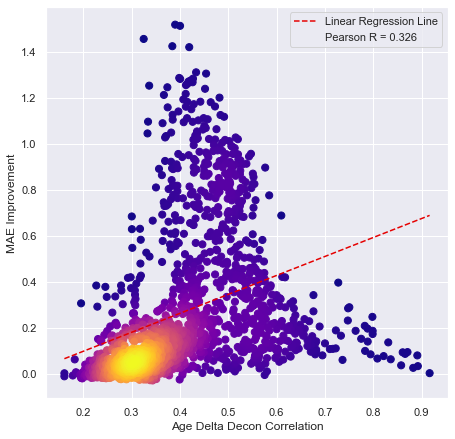

In [22]:
scatter_plot_heatmap(x=pr_df.corr_age_delta_decon, y=pr_df.mae_improvements, 
                     xlabel='Age Delta Decon Correlation', 
                   ylabel='MAE Improvement', title=None, set_scale=False, 
                   equality_line=False)

In [59]:
pr_df[pr_df.mae_improvements >= 0.7].sort_values('ensambled_mae')

ensamble_name  corr_output_age_decon  corr_age_delta_decon  \
617    rsfmri_5 rsfmri_17               0.738763              0.547093   
1068  rsfmri_17 rsfmri_18               0.738623              0.543029   
618    rsfmri_5 rsfmri_18               0.754771              0.576490   
1035  rsfmri_16 rsfmri_17               0.719822              0.515370   
516     rsfmri_3 rsfmri_5               0.644322              0.428577   
...                   ...                    ...                   ...   
706    rsfmri_7 rsfmri_21               0.595334              0.432623   
973   rsfmri_14 rsfmri_22               0.577142              0.384941   
699    rsfmri_7 rsfmri_14               0.592166              0.434638   
650     rsfmri_6 rsfmri_7               0.544125              0.374078   
707    rsfmri_7 rsfmri_22               0.532762              0.356772   

       min_mae  ensambled_mae  mae_improvements  
617   6.983365       6.027524          0.955842  
1068  6.983365       6.039149          0.944217  
618   6.994065       6.098157          0.895909  
1035  6.983365       6.123107          0.860258  
516   7.145245       6.151807          0.993438  
...        ...            ...               ...  
706   8.417786       7.689466          0.728320  
973   8.842425       7.716896          1.125528  
699   8.842425       7.954547          0.887877  
650   9.238483       7.993352          1.245131  
707   9.068116       8.177688          0.890428  

[216 rows x 6 columns]

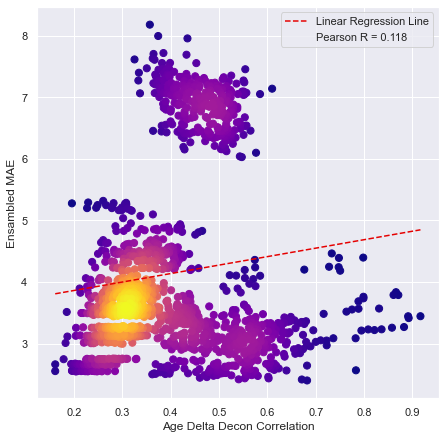

In [60]:
scatter_plot_heatmap(x=pr_df.corr_age_delta_decon, y=pr_df.ensambled_mae, 
                     xlabel='Age Delta Decon Correlation', 
                   ylabel='Ensambled MAE', title=None, set_scale=False, 
                   equality_line=False)

In [61]:
pr_df[(pr_df.ensambled_mae <= 2.3) & (pr_df.mae_improvements > 0)].sort_values('ensambled_mae')

Empty DataFrame
Columns: [ensamble_name, corr_output_age_decon, corr_age_delta_decon, min_mae, ensambled_mae, mae_improvements]
Index: []

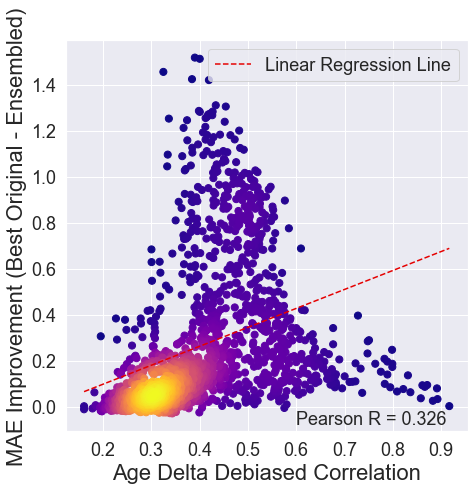

In [23]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(7.2, 7.2)

x=pr_df.corr_age_delta_decon
y=pr_df.mae_improvements
xlabel='Age Delta Debiased Correlation'
ylabel='MAE Improvement (Best Original - Ensembled)'
title=None
set_scale=False 
equality_line=False


if isinstance(x, pd.Series):
    x = x.to_numpy()

if isinstance(y, pd.Series):
    y = y.to_numpy()

fig = plt.figure(figsize=figsize)

sns.set_style("darkgrid", {'image.cmap': u'plasma'})
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
plt.scatter(x,y,c=z,s=50)
if equality_line == True:
    plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality

X_mat=np.vstack((np.ones(len(x)), x)).T
beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
b,w = beta_hat[0],beta_hat[1]
x2 = np.linspace(np.min(x),np.max(x),num=10)
y2 = w * x2 + b
plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')

pearson_correlation = pearsonr(x,y)[0]
text_x = 0.6
text_y = -0.075
lbl = 'Pearson R = '+str(round(pearson_correlation,3))
plt.text(text_x, text_y, lbl, fontsize=legend_font)

if set_scale == True:
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    c_min, c_max = min(x_min, y_min), max(x_max, y_max)
    plt.xlim([c_min-2, c_max+2])
    plt.ylim([c_min-2, c_max+2])

plt.xlabel(xlabel, fontsize = title_font_size)
plt.ylabel(ylabel, fontsize = title_font_size)

plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)


# plt.plot([],[],' ',label=lbl)

plt.title(title, fontsize= title_font_size)
plt.legend(fontsize = legend_font)
plt.show()

fig.savefig('Male_elastic_net_ensembling_mae_improvement_vs_correlation.png', bbox_inches='tight', facecolor='white')



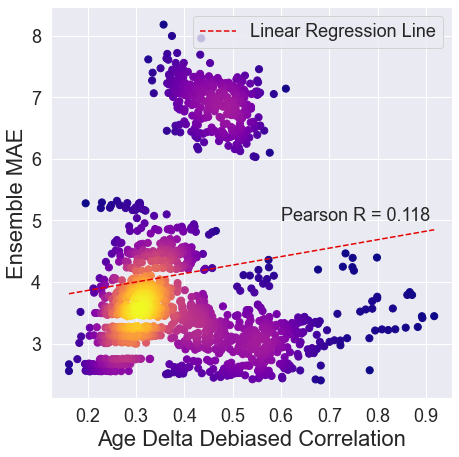

In [25]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(7.2, 7.2)

x=pr_df.corr_age_delta_decon
y=pr_df.ensambled_mae
xlabel='Age Delta Debiased Correlation'
ylabel='Ensemble MAE'
title=None
set_scale=False 
equality_line=False


if isinstance(x, pd.Series):
    x = x.to_numpy()

if isinstance(y, pd.Series):
    y = y.to_numpy()

fig = plt.figure(figsize=figsize)

sns.set_style("darkgrid", {'image.cmap': u'plasma'})
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
plt.scatter(x,y,c=z,s=50)
if equality_line == True:
    plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality

X_mat=np.vstack((np.ones(len(x)), x)).T
beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
b,w = beta_hat[0],beta_hat[1]
x2 = np.linspace(np.min(x),np.max(x),num=10)
y2 = w * x2 + b
plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')

pearson_correlation = pearsonr(x,y)[0]
text_x = 0.6
text_y = 5
lbl = 'Pearson R = '+str(round(pearson_correlation,3))
plt.text(text_x, text_y, lbl, fontsize=legend_font)

if set_scale == True:
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    c_min, c_max = min(x_min, y_min), max(x_max, y_max)
    plt.xlim([c_min-2, c_max+2])
    plt.ylim([c_min-2, c_max+2])

plt.xlabel(xlabel, fontsize = title_font_size)
plt.ylabel(ylabel, fontsize = title_font_size)

plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)


# plt.plot([],[],' ',label=lbl)

plt.title(title, fontsize= title_font_size)
plt.legend(fontsize = legend_font, loc='upper right')
plt.show()

fig.savefig('Male_elastic_net_ensembling_ensemble_mae_vs_correlation.png', bbox_inches='tight', facecolor='white')



## Attempt at Multiple Combinations with 3

In [63]:
modalities = df.modality.to_list()
ensamble_names = []
min_maes = []
ensambled_maes = []

for subset in itertools.combinations(modalities, 3):
    subset = list(subset)
    ensamble_name = subset[0] + ' ' + subset[1] + ' ' + subset[2]
    ensamble_names.append(ensamble_name)
    
    min_mae = min(
                    np.abs(df.iloc[modalities.index(subset[0])].dataframe.age_delta_decon).mean(),
                    np.abs(df.iloc[modalities.index(subset[1])].dataframe.age_delta_decon).mean(),
                    np.abs(df.iloc[modalities.index(subset[2])].dataframe.age_delta_decon).mean()
    )
    min_maes.append(min_mae)
           
    ensambled_mae = ElasticNet_wrap(df_train, df_test, modalities=subset, 
                              number_of_modalities=None, show_plots=False, verbose=False,
                                   cross_validation_flag = False, deconfound=True)[3]
    ensambled_maes.append(ensambled_mae)
    
    
    
pr_df2 = pd.DataFrame.from_dict({
    'ensamble_name': ensamble_names,
    'min_mae': min_maes,
    'ensambled_mae': ensambled_maes,
})

pr_df2['mae_improvements'] = pr_df2['min_mae'] - pr_df2['ensambled_mae']

In [64]:
print(len(pr_df2))
pr_df2[(pr_df2.ensambled_mae <= 2.275) & (pr_df2.mae_improvements > 0)].sort_values('ensambled_mae')

29260


Empty DataFrame
Columns: [ensamble_name, min_mae, ensambled_mae, mae_improvements]
Index: []

# 5. Fit Model to highly correlated groups (Notebook 4)

In [68]:
smri_mod = modalities[:7]
rsfmri_mod = modalities[7:32]
tfmri_mod = modalities[32:38]
dmri_mod = modalities[38:]
tbss_s_mod = dmri_mod[1:10]
tbss_mod = dmri_mod[10:]

rsfmri_jac_mod = rsfmri_mod + ['jacobian']
tfmri_jac_mod = tfmri_mod + ['jacobian']

fmri_mod = rsfmri_mod + tfmri_mod
fmri_jac_mod = rsfmri_mod + tfmri_mod + ['jacobian']

tbss_s_mod_tracts = dmri_mod[1:10] + ['tracts']
tbss_mod_tract = dmri_mod[10:] + ['tracts']

mod_list = [smri_mod, rsfmri_mod, tfmri_mod, dmri_mod, tbss_s_mod, tbss_mod, rsfmri_jac_mod, tfmri_jac_mod, 
             fmri_mod, fmri_jac_mod, tbss_s_mod_tracts, tbss_mod_tract]
mod_names = ['smri_mod', 'rsfmri_mod', 'tfmri_mod', 'dmri_mod', 'tbss_s_mod', 'tbss_mod', 'rsfmri_jac_mod', 
             'tfmri_jac_mod', 'fmri_mod', 'fmri_jac_mod', 'tbss_s_mod_tracts', 'tbss_mod_tract']

modality_decon_maes = []

for idx in range(len(df)):
    modality_decon_mae = np.abs(df.iloc[idx].dataframe.age_delta_decon).mean()
    modality_decon_maes.append(modality_decon_mae)
    
mae_df = pd.DataFrame.from_dict({
    'modality': df.modality.to_list(),
    'mae_decon': modality_decon_maes
})

mae_df = mae_df.sort_values('mae_decon')
mae_df.head()

def ensamble_sub_modality_groups(sub_modality_group, mae_df, df, df_train, df_test, sub_modality_name):

    ordered_modalities = mae_df.modality.to_list()
    ordered_modalities = [modality for modality in ordered_modalities if modality in sub_modality_group]
    print(ordered_modalities)

    maes_list = []
    number_of_modalitiest = []

    for i in range(2, len(ordered_modalities)+1):
        modalities = ordered_modalities[:i]
        x = ElasticNet_wrap(df_train, df_test, modalities=modalities, 
                              number_of_modalities=None, show_plots=False, verbose=False,
                           cross_validation_flag = False, deconfound=True)
                
        ensambled_mae = x[3]
        maes_list.append(ensambled_mae)
        number_of_modalitiest.append(i)
        
    plt.figure(figsize=(12.8, 4.8))
    plt.subplot(121)
    plt.plot(maes_list)
    plt.title(sub_modality_name)
    plt.plot([],[],' ',label='MIN MAE=' + str(min(maes_list)))
    plt.plot([],[],' ',label='MIN LOC=' + str(1 + np.argmin(np.array(maes_list))))
    plt.legend()
    plt.xlabel('No of Modalitities Ensambled with MAE Rank')
    plt.ylabel('Ensambled MAE')
    plt.show()
    
    print('-------')


['T2_nonlinear', 'T1_nonlinear', 'T1_linear', 'vbm', 'swi', 'jacobian', 'T2_lesions']


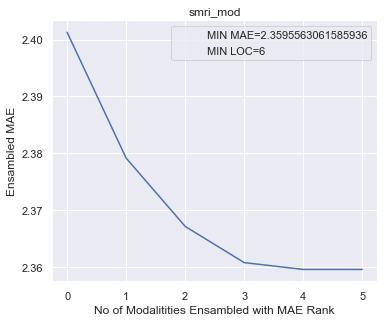

-------
['rsfmri_17', 'rsfmri_18', 'rsfmri_5', 'rsfmri_16', 'rsfmri_0', 'rsfmri_1', 'rsfmri_9', 'rsfmri_12', 'rsfmri_8', 'rsfmri_11', 'rsfmri_4', 'rsfmri_13', 'rsfmri_19', 'rsfmri_24', 'rsfmri_15', 'rsfmri_3', 'rsfmri_23', 'rsfmri_10', 'rsfmri_21', 'rsfmri_2', 'rsfmri_20', 'rsfmri_14', 'rsfmri_22', 'rsfmri_6', 'rsfmri_7']


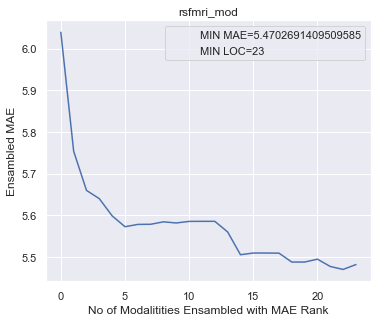

-------
['tfmri_c_1', 'tfmri_c_5', 'tfmri_c_2', 'tfmri_1', 'tfmri_2', 'tfmri_5']


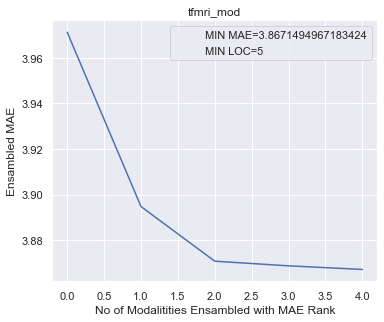

-------
['tbss_ICVF', 'tbss_FA', 'tbss_OD', 'tbss_L1', 'tbss_ISOVF', 'tbss_MD', 'tbss_ICVF_s', 'tbss_L3', 'tbss_L2', 'tbss_MO', 'tbss_FA_s', 'tbss_OD_s', 'tbss_L1_s', 'tracts', 'tbss_MD_s', 'tbss_L2_s', 'tbss_ISOVF_s', 'tbss_L3_s', 'tbss_MO_s']


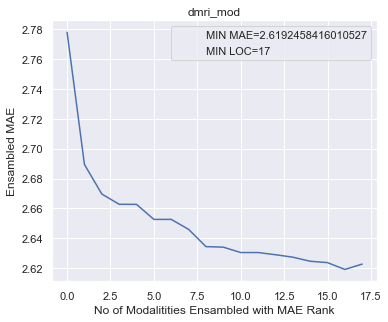

-------
['tbss_ICVF_s', 'tbss_FA_s', 'tbss_OD_s', 'tbss_L1_s', 'tbss_MD_s', 'tbss_L2_s', 'tbss_ISOVF_s', 'tbss_L3_s', 'tbss_MO_s']


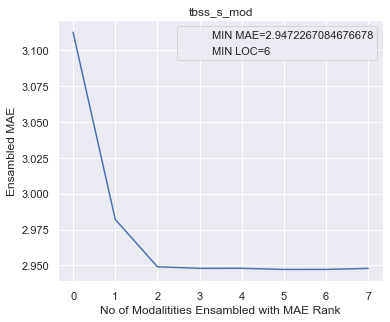

-------
['tbss_ICVF', 'tbss_FA', 'tbss_OD', 'tbss_L1', 'tbss_ISOVF', 'tbss_MD', 'tbss_L3', 'tbss_L2', 'tbss_MO']


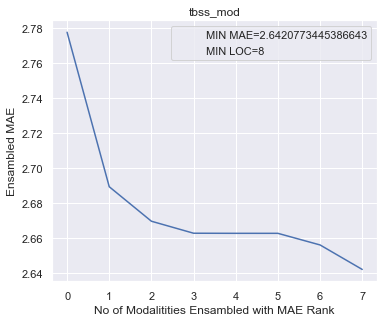

-------
['jacobian', 'rsfmri_17', 'rsfmri_18', 'rsfmri_5', 'rsfmri_16', 'rsfmri_0', 'rsfmri_1', 'rsfmri_9', 'rsfmri_12', 'rsfmri_8', 'rsfmri_11', 'rsfmri_4', 'rsfmri_13', 'rsfmri_19', 'rsfmri_24', 'rsfmri_15', 'rsfmri_3', 'rsfmri_23', 'rsfmri_10', 'rsfmri_21', 'rsfmri_2', 'rsfmri_20', 'rsfmri_14', 'rsfmri_22', 'rsfmri_6', 'rsfmri_7']


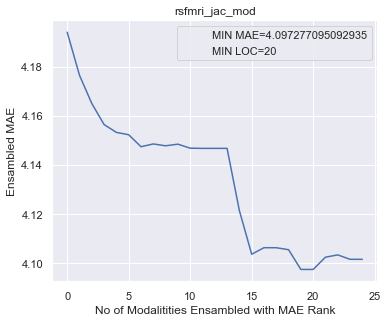

-------
['jacobian', 'tfmri_c_1', 'tfmri_c_5', 'tfmri_c_2', 'tfmri_1', 'tfmri_2', 'tfmri_5']


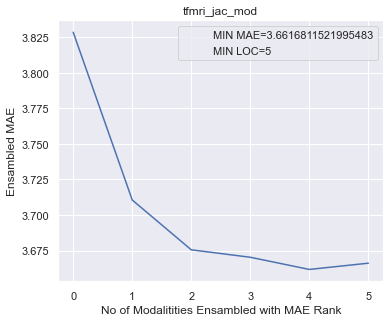

-------
['tfmri_c_1', 'tfmri_c_5', 'tfmri_c_2', 'tfmri_1', 'tfmri_2', 'tfmri_5', 'rsfmri_17', 'rsfmri_18', 'rsfmri_5', 'rsfmri_16', 'rsfmri_0', 'rsfmri_1', 'rsfmri_9', 'rsfmri_12', 'rsfmri_8', 'rsfmri_11', 'rsfmri_4', 'rsfmri_13', 'rsfmri_19', 'rsfmri_24', 'rsfmri_15', 'rsfmri_3', 'rsfmri_23', 'rsfmri_10', 'rsfmri_21', 'rsfmri_2', 'rsfmri_20', 'rsfmri_14', 'rsfmri_22', 'rsfmri_6', 'rsfmri_7']


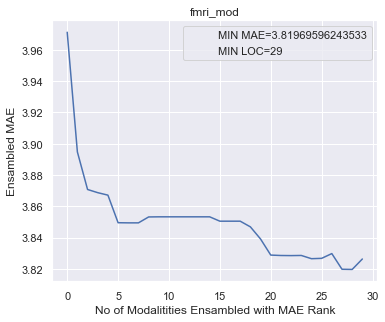

-------
['jacobian', 'tfmri_c_1', 'tfmri_c_5', 'tfmri_c_2', 'tfmri_1', 'tfmri_2', 'tfmri_5', 'rsfmri_17', 'rsfmri_18', 'rsfmri_5', 'rsfmri_16', 'rsfmri_0', 'rsfmri_1', 'rsfmri_9', 'rsfmri_12', 'rsfmri_8', 'rsfmri_11', 'rsfmri_4', 'rsfmri_13', 'rsfmri_19', 'rsfmri_24', 'rsfmri_15', 'rsfmri_3', 'rsfmri_23', 'rsfmri_10', 'rsfmri_21', 'rsfmri_2', 'rsfmri_20', 'rsfmri_14', 'rsfmri_22', 'rsfmri_6', 'rsfmri_7']


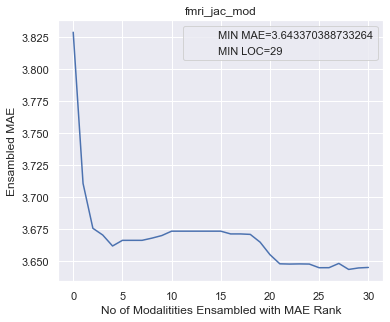

-------
['tbss_ICVF_s', 'tbss_FA_s', 'tbss_OD_s', 'tbss_L1_s', 'tracts', 'tbss_MD_s', 'tbss_L2_s', 'tbss_ISOVF_s', 'tbss_L3_s', 'tbss_MO_s']


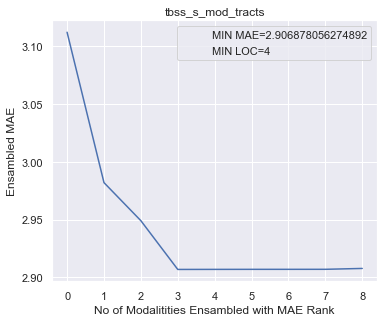

-------
['tbss_ICVF', 'tbss_FA', 'tbss_OD', 'tbss_L1', 'tbss_ISOVF', 'tbss_MD', 'tbss_L3', 'tbss_L2', 'tbss_MO', 'tracts']


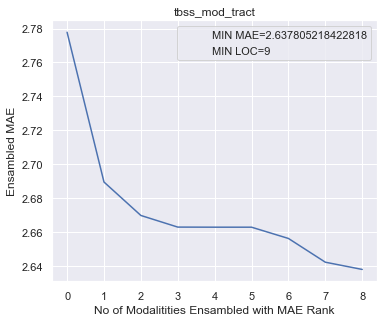

-------


In [69]:
for idx, sub_mod in enumerate(mod_list):
    ensamble_sub_modality_groups(sub_modality_group=sub_mod, mae_df=mae_df, 
                                 df=df, df_train=df_train, df_test=df_test,
                                 sub_modality_name=mod_names[idx])


In [70]:
x = tmp_dct = combination_ensambling(df, df_train, df_test, custom_modalities=smri_mod, 
                           min_objects=None, max_objects=None, verbose=False)
x.sort_values('mae_improvement', ascending=False).head()

modality  min_single_mae  ensambled_mae  mae_improvement
46  jacobian T2_lesions swi        3.942241       3.399374         0.542867
11             jacobian swi        3.942241       3.464152         0.478089
10      jacobian T2_lesions        4.287973       3.982477         0.305496
16           T2_lesions swi        3.942241       3.683290         0.258951
44         jacobian vbm swi        3.116403       2.877689         0.238714

In [71]:
x = tmp_dct = combination_ensambling(df, df_train, df_test, custom_modalities=tfmri_mod, 
                           min_objects=None, max_objects=None, verbose=False)
x.sort_values('mae_improvement', ascending=False).head()

modality  min_single_mae  \
52  tfmri_1 tfmri_2 tfmri_5 tfmri_c_2 tfmri_c_5         4.62837   
43          tfmri_1 tfmri_5 tfmri_c_2 tfmri_c_5         4.62837   
40          tfmri_1 tfmri_2 tfmri_c_2 tfmri_c_5         4.62837   
24                  tfmri_1 tfmri_c_2 tfmri_c_5         4.62837   
37            tfmri_1 tfmri_2 tfmri_5 tfmri_c_5         4.62837   

    ensambled_mae  mae_improvement  
52       3.931231         0.697139  
43       3.934636         0.693733  
40       3.939047         0.689323  
24       3.944041         0.684328  
37       3.984406         0.643964

MAE= 4.240902115279283
PR= 0.7221234926256117
Time To Complete: 0:00:00.001766
MAE Decon= 5.747233195346385
PR Decon= 0.7221234926256117


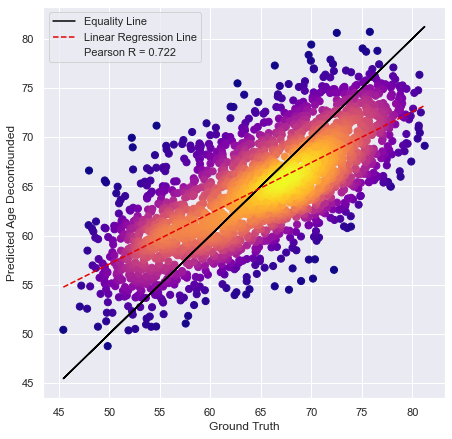

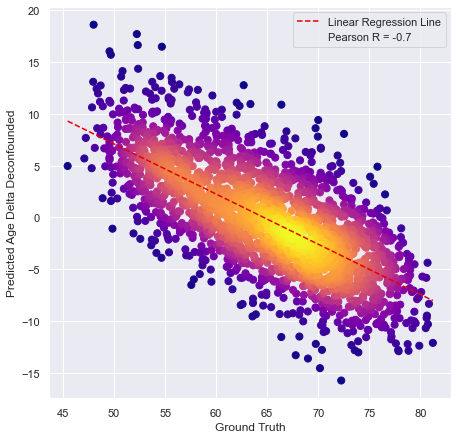

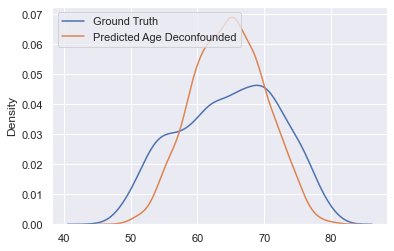

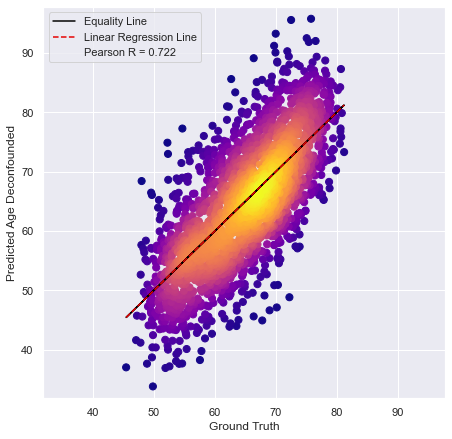

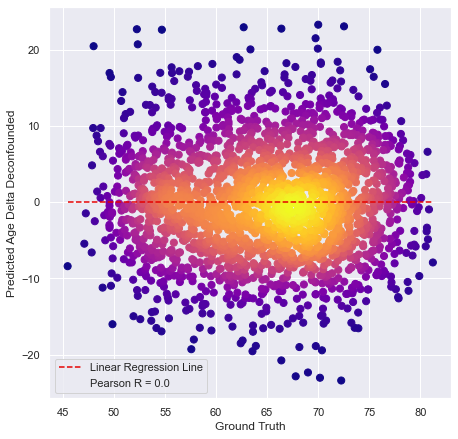

0------
1.398127820146991
-25.400157502952084
[0.26854882 0.28160637 0.19515036 0.34341107 0.3094112 ]


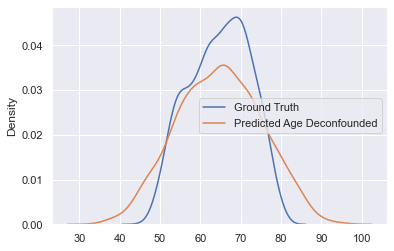

In [72]:
tmp_mod= ['rsfmri_0', 'rsfmri_22', 'rsfmri_11', 'rsfmri_17', 'rsfmri_18']
# tmp_mod = ['rsfmri_0', 'rsfmri_22', 'rsfmri_11']
x = ElasticNet_wrap(df_train, df_test, modalities = tmp_mod, 
                      number_of_modalities=None, show_plots=True, verbose=True,
                   cross_validation_flag = False, deconfound=True
                   )
print("0------")
print(x[1].sum())
print(x[2])
print(x[1])

# (reg, coefficients, intercept,

['rsfmri_17', 'rsfmri_18', 'rsfmri_5', 'rsfmri_16', 'rsfmri_0', 'rsfmri_1', 'rsfmri_9', 'rsfmri_12', 'rsfmri_8', 'rsfmri_11', 'rsfmri_4', 'rsfmri_13', 'rsfmri_19', 'rsfmri_24', 'rsfmri_15', 'rsfmri_3', 'rsfmri_23', 'rsfmri_10', 'rsfmri_21', 'rsfmri_2', 'rsfmri_20', 'rsfmri_14', 'rsfmri_22', 'rsfmri_6', 'rsfmri_7']


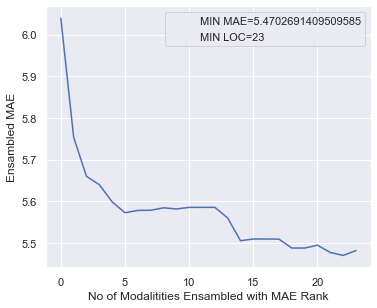

-------


In [73]:
ensamble_sub_modality_groups(sub_modality_group=rsfmri_mod, mae_df=mae_df, 
                                 df=df, df_train=df_train, df_test=df_test,
                                 sub_modality_name=None)

# 6. Fit ElasticNet to Highly Correlated Clusters

In [74]:
df.modality.to_list()

['T1_nonlinear',
 'T1_linear',
 'jacobian',
 'vbm',
 'T2_nonlinear',
 'T2_lesions',
 'swi',
 'rsfmri_0',
 'rsfmri_1',
 'rsfmri_2',
 'rsfmri_3',
 'rsfmri_4',
 'rsfmri_5',
 'rsfmri_6',
 'rsfmri_7',
 'rsfmri_8',
 'rsfmri_9',
 'rsfmri_10',
 'rsfmri_11',
 'rsfmri_12',
 'rsfmri_13',
 'rsfmri_14',
 'rsfmri_15',
 'rsfmri_16',
 'rsfmri_17',
 'rsfmri_18',
 'rsfmri_19',
 'rsfmri_20',
 'rsfmri_21',
 'rsfmri_22',
 'rsfmri_23',
 'rsfmri_24',
 'tfmri_1',
 'tfmri_2',
 'tfmri_5',
 'tfmri_c_1',
 'tfmri_c_2',
 'tfmri_c_5',
 'tracts',
 'tbss_FA_s',
 'tbss_ICVF_s',
 'tbss_ISOVF_s',
 'tbss_L1_s',
 'tbss_L2_s',
 'tbss_L3_s',
 'tbss_MD_s',
 'tbss_MO_s',
 'tbss_OD_s',
 'tbss_FA',
 'tbss_ICVF',
 'tbss_ISOVF',
 'tbss_L1',
 'tbss_L2',
 'tbss_L3',
 'tbss_MD',
 'tbss_MO',
 'tbss_OD']

In [75]:
# mods1 = ['tbss_L2', 'tbss_MD', 'tbss_L3', 'tbss_L1', 'tbss_ISOVF']
# mods2 = ['T1_nonlinear', 'T1_linear', 'vbm', 'T2_nonlinear']
# mods3 = mods1 + mods2
# mods4 = ['tbss_ICVF_s', 'tbss_ICVF']
# mods5 = ['tbss_ISOVF_s', 'tbss_L1_s', 'tbss_L2_s', 'tbss_L3_s', 'tbss_MD_s']
# mods6 = mods4 + mods5
# mods7 = mods6 + ['T2_lesions']
# mods8 = ['tracts', 'tbss_FA_s', 'tbss_FA', 'tbss_MO_s', 'tbss_MO', 'tbss_OD_s', 'tbss_OD']
# mods9 = mods3 + mods7 + mods8

# mods10 = ['jacobian', 'tfmri_5', 'tfmri_c_5', 'swi']
# mods11 = ['tfmri_1', 'tfmri_2', 'tfmri_c_1', 'tfmri_c_2']
# mods12 = mods10 + mods11
# mods13 = ['rsfmri_0', 'rsfmri_16', 'rsfmri_6']
# mods14 = ['rsfmri_2', 'rsfmri_17', 'rsfmri_21', 'rsfmri_5', 'rsfmri_9', 'rsfmri_13', 'rsfmri_20']
# mods15 = ['rsfmri_1', 'rsfmri_7']
# mods16 = mods13 + mods14 + mods15
# mods17 = ['rsfmri_3', 'rsfmri_22', 'rsfmri_15', 'rsfmri_14']
# mods18 = ['rsfmri_10', 'rsfmri_11', 'rsfmri_12', 'rsfmri_18']
# mods19 = ['rsfmri_4', 'rsfmri_8', 'rsfmri_19', 'rsfmri_23', 'rsfmri_24']
# mods20 = mods17 + mods18 + mods19
# mods21 = mods16 + mods20
# mods22 = mods12 + mods21

# cluster1 = mods1 + mods2
# cluster2 = mods7
# cluster3 = mods8
# cluster4 = mods12
# cluster5 = mods21
# cluster6 = cluster2 + cluster3
# cluster7 = cluster1 + cluster6
# cluster8 = cluster7 + cluster4
# cluster9 = mods22

# # mods = [mods1, mods2, mods3, mods4, mods5, mods6, mods7, mods8, mods9, mods10, mods11, 
# #        mods12, mods13, mods14, mods15, mods16, mods17, mods18, mods19, mods20, mods21, mods22]

# mods = [cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8, cluster9]

# output_name = 'male_ensembles_testset.pkl'

# idx = 1
# for mod in mods:
#     x = ElasticNet_wrap(df_train, df_test, modalities=mod, 
#                    number_of_modalities=None, show_plots=False, verbose=False,
#                    cross_validation_flag = False, deconfound=True)
#     print('mods:', idx, '|', x[3])
     
    
#     cluster_name = 'Cluster' + str(idx)
    
#     df_output = pd.DataFrame.from_dict({
#         'modality': cluster_name,
#         'dataframe': [pd.DataFrame.from_dict({
#                 'Unnamed: 0': subjects_testB,
#                 'age_delta_decon': x[10]
#                 })]
#         })

#     idx +=1

#     if os.path.exists(output_name):
#         df_ensambles = pd.read_pickle(output_name)
#         if df_output.iloc[0].modality in df_ensambles.modality.to_list():
#             pass
#         else:
#             df_ensambles = pd.concat([df_ensambles, df_output])
#             df_ensambles.to_pickle(output_name, protocol = 4)
#     else:
#         df_output.to_pickle(output_name, protocol = 4)

In [76]:
# os.remove(output_name)

In [77]:
# df_ensambles = pd.read_pickle(output_name)
# df_ensambles

In [ ]:
# for i in range(3,len(df_ensambles)):
#     print(abs(df_ensambles.iloc[i].dataframe.age_delta_decon).mean())

# 6.1. Fit EN to highly correlated clusters USING C1

In [19]:
mods13 = ['rsfmri_0', 'rsfmri_16', 'rsfmri_6']
mods14 = ['rsfmri_2', 'rsfmri_17', 'rsfmri_21', 'rsfmri_5', 'rsfmri_9', 'rsfmri_13', 'rsfmri_20']
mods15 = ['rsfmri_1', 'rsfmri_7']
mods16 = mods13 + mods14 + mods15
mods17 = ['rsfmri_3', 'rsfmri_22', 'rsfmri_15', 'rsfmri_14']
mods18 = ['rsfmri_10', 'rsfmri_11', 'rsfmri_12', 'rsfmri_18']
mods19 = ['rsfmri_4', 'rsfmri_8', 'rsfmri_19', 'rsfmri_23', 'rsfmri_24']
mods20 = mods17 + mods18 + mods19
mods21 = mods16 + mods20

cluster1 = ['tbss_L2', 'tbss_MD', 'tbss_L3', 'tbss_L1', 'tbss_ISOVF']
cluster2 = ['tbss_ISOVF_s', 'tbss_L1_s', 'tbss_L2_s', 'tbss_L3_s', 'tbss_MD_s']
cluster3 = ['tracts', 'tbss_FA_s', 'tbss_FA', 'tbss_MO_s', 'tbss_MO', 'tbss_OD_s', 'tbss_OD']
cluster4 = ['T1_nonlinear', 'T1_linear', 'vbm', 'T2_nonlinear']
cluster5 = cluster4 + ['T2_lesions', 'swi', 'tbss_ICVF_s', 'tbss_ICVF']
cluster6 = ['jacobian', 'tfmri_5', 'tfmri_c_5', 'tfmri_1', 'tfmri_2', 'tfmri_c_1', 'tfmri_c_2']
cluster7 = mods21
cluster8 = cluster1 + cluster2
cluster9 = cluster8 + cluster3
cluster10 = cluster9 + cluster5
cluster11 = cluster10 + cluster6

mods = [cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8, cluster9, cluster10,
       cluster11]

idx = 1
for mod in mods:
    x = ElasticNet_wrap(df_train, df_test, modalities=mod, 
                   number_of_modalities=None, show_plots=False, verbose=False,
                   cross_validation_flag = False, deconfound=False)
#     print('mods:', idx, '|', x[3])
    print('{:.3f}'.format(x[3]))
     
    
    cluster_name = 'Cluster' + str(idx)
    
    df_output = pd.DataFrame.from_dict({
        'modality': cluster_name,
        'dataframe': [pd.DataFrame.from_dict({
                'Unnamed: 0': subjects_testB,
                'age_delta_decon': x[10]
                })]
        })

    idx +=1

#     if os.path.exists(output_name):
#         df_ensambles = pd.read_pickle(output_name)
#         if df_output.iloc[0].modality in df_ensambles.modality.to_list():
# #             iloc_idx = np.where(df_ensambles.modality.to_numpy() == df_output.iloc[0].modality)[0][0]
# #             df_ensambles.iloc[iloc_idx].dataframe = pd.DataFrame.copy(df_output.iloc[0].dataframe)
# #             df_output.to_pickle(output_name, protocol = 4)
#             pass
#         else:
#             df_ensambles = pd.concat([df_ensambles, df_output])
#             df_ensambles.to_pickle(output_name, protocol = 4)
#     else:
#         df_output.to_pickle(output_name, protocol = 4)

2.731
3.047
2.510
2.194
2.163
3.123
4.114
2.676
2.460
2.131
2.122


In [20]:
df_ensambles = pd.read_pickle(output_name)
df_ensambles

modality                                          dataframe
0             NaiveFull        Unnamed: 0  age_delta_decon  mean_age_de...
0  LinearRegressionFull        Unnamed: 0  age_delta_decon  mean_age_de...
0        ElasticNetFull        Unnamed: 0  age_delta_decon  mean_age_de...

mods: 1 | 3.1005813587341664
mods: 2 | 3.503069090354265
mods: 3 | 2.7634838703141504
mods: 4 | 2.367171997353036
mods: 5 | 2.337664835961681
mods: 6 | 3.666057492188681
mods: 7 | 5.482100007126796
mods: 8 | 3.018194138976379
mods: 9 | 2.710280438571065
mods: 10 | 2.2835552747859493
mods: 11 | 2.275427153787553


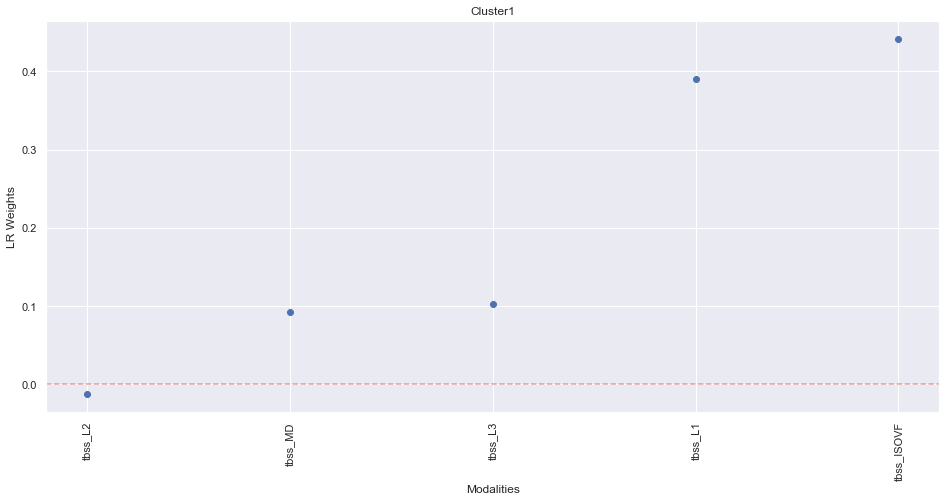

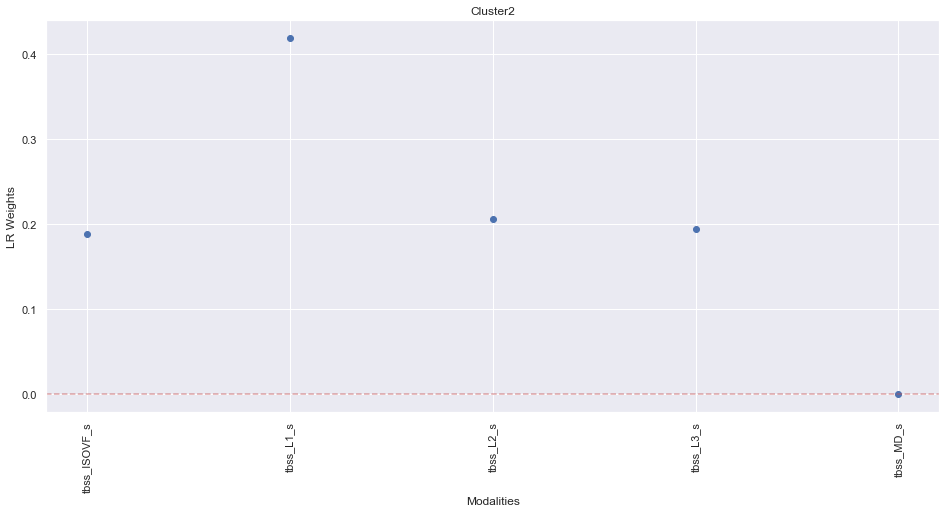

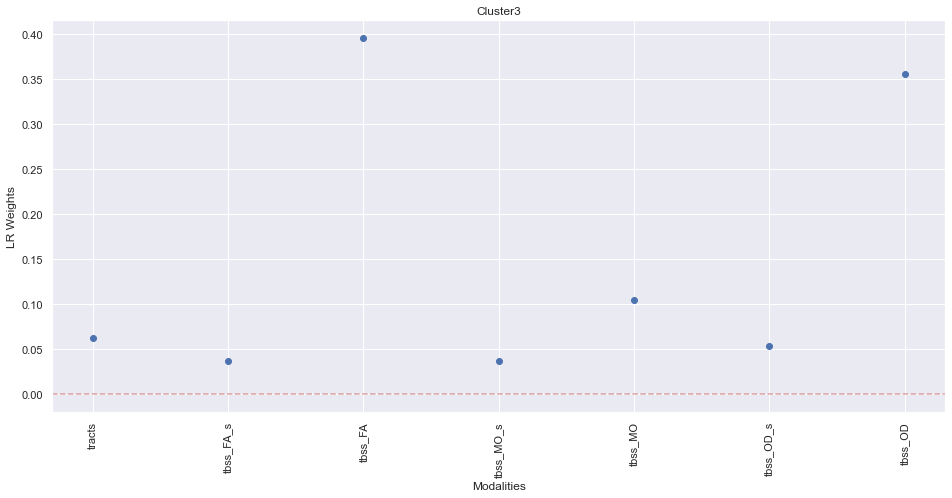

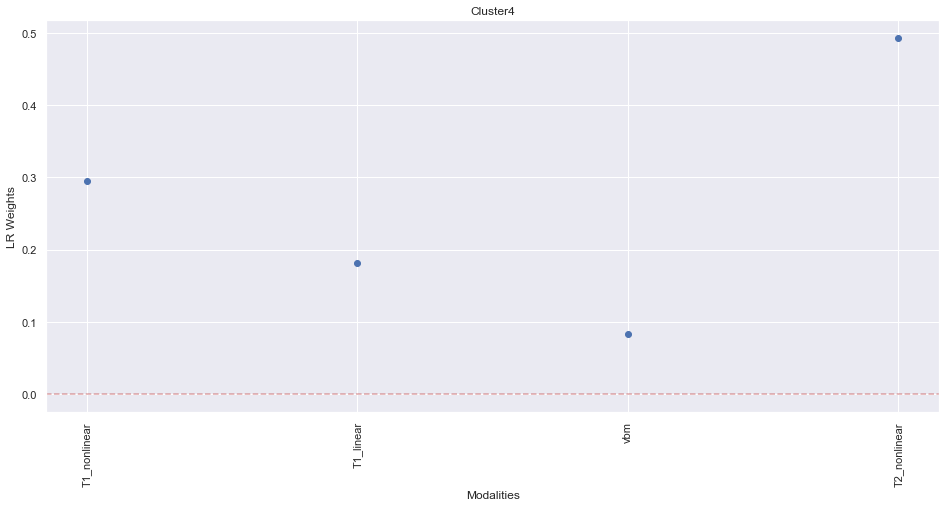

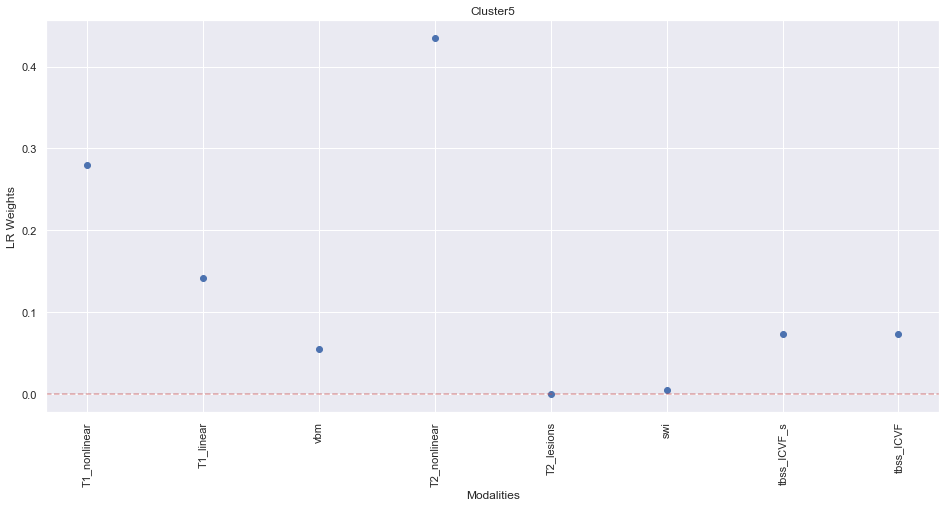

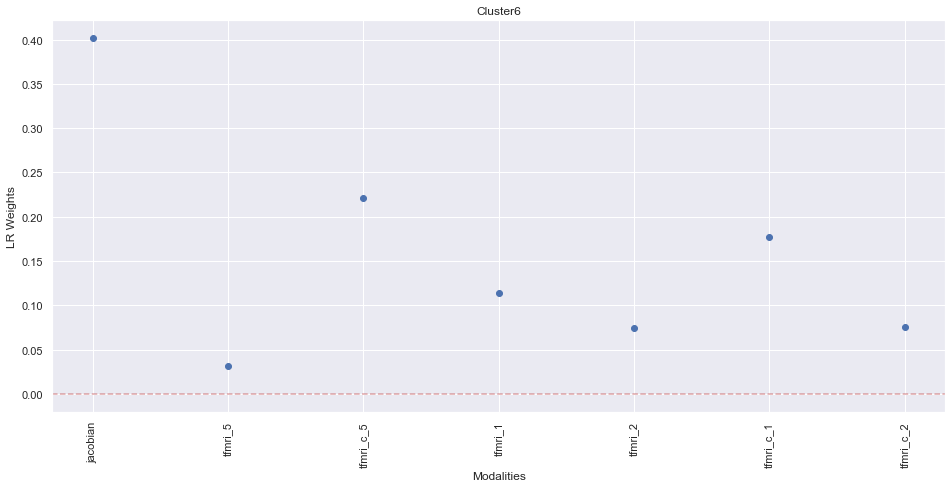

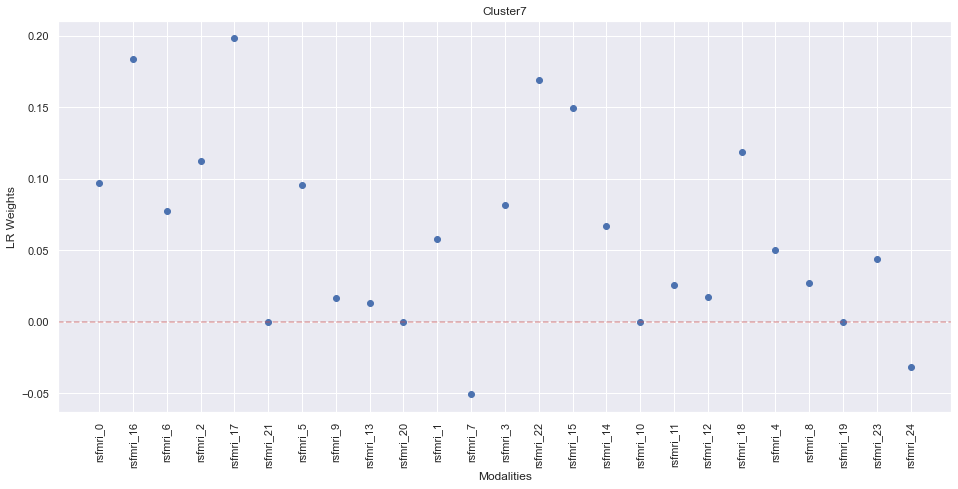

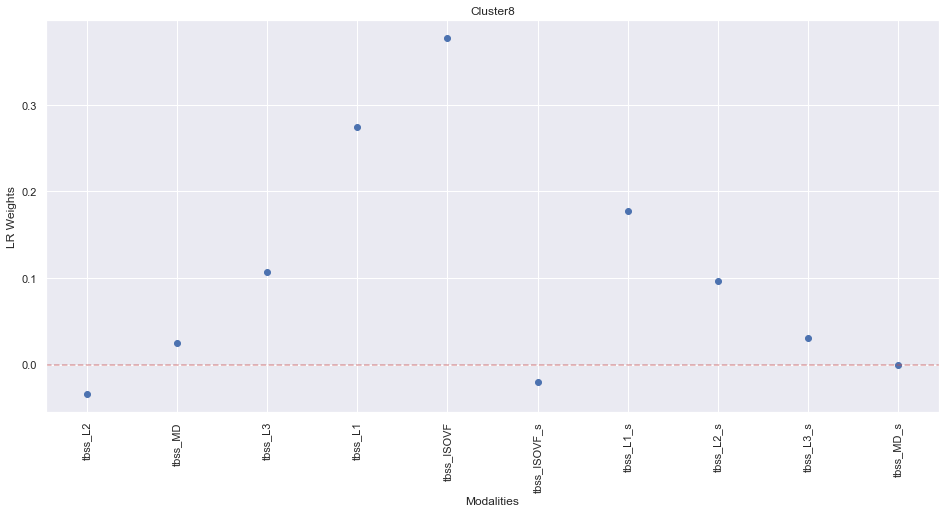

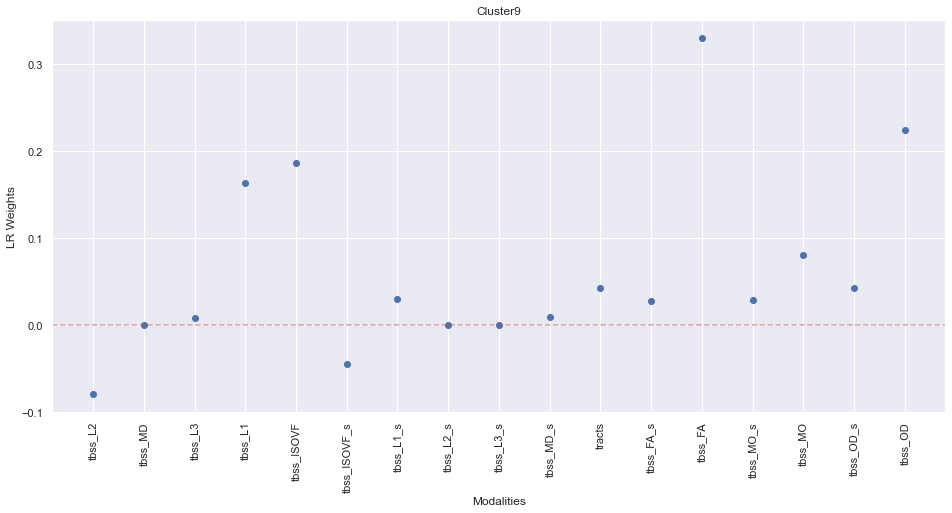

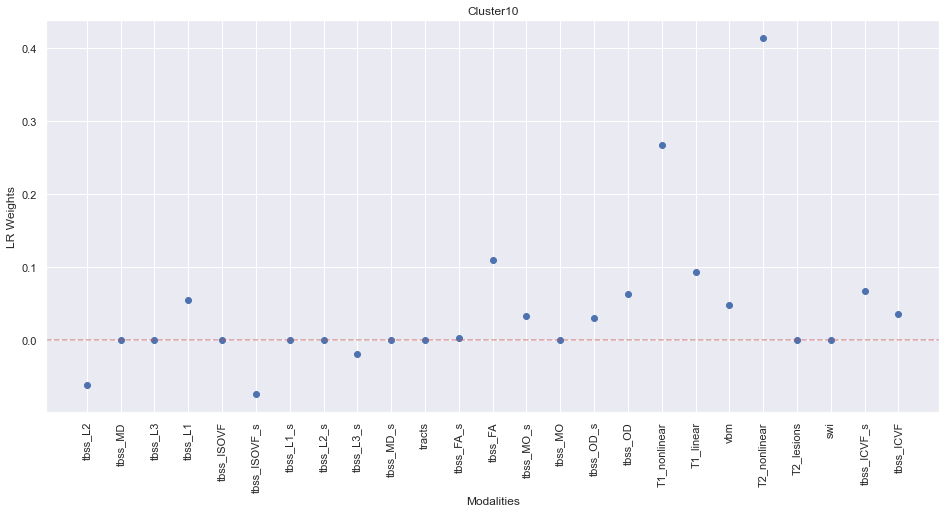

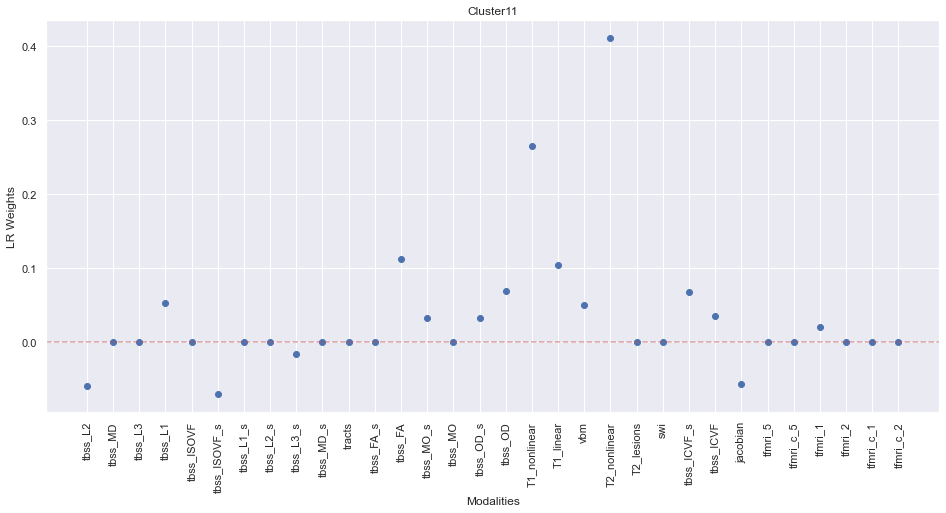

In [21]:
idx = 1
for mod in mods:
    x = ElasticNet_wrap(df_train, df_test, modalities=mod, 
                   number_of_modalities=None, show_plots=False, verbose=False,
                   cross_validation_flag = False, deconfound=True)
    print('mods:', idx, '|', x[3])
     
    cluster_name = 'Cluster' + str(idx)
    
    plt.figure(figsize=(16, 7.2))
    plt.scatter(np.arange(0, x[5].shape[0]), x[1])
    plt.xticks(np.arange(0, x[5].shape[0]), mod, rotation=90);
    plt.xlabel("Modalities")
    plt.ylabel("LR Weights")
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
    plt.title(cluster_name)

    idx +=1

mods: 1 | 3.0985658323359218
0.045518419564233484 1.0
mods: 2 | 3.5026422738099767
0.062125238434228194 1.0
mods: 3 | 2.7624376279524507
0.2930212076167835 0.16
mods: 4 | 2.366990332644658
0.1664551542123036 0.29
mods: 5 | 2.338892723555259
0.23680231077986383 1.0
mods: 6 | 3.6699324892988345
1.3694453815940482 0.1
mods: 7 | 5.470715932781953
2.7136442689709157 0.1
mods: 8 | 3.022134405419473
0.045518419564233484 1.0
mods: 9 | 2.708824520186415
0.08892209515833144 0.52
mods: 10 | 2.2772880076720847
0.2151295737606539 0.3
mods: 11 | 2.271006994323336
0.1529835029426548 0.53


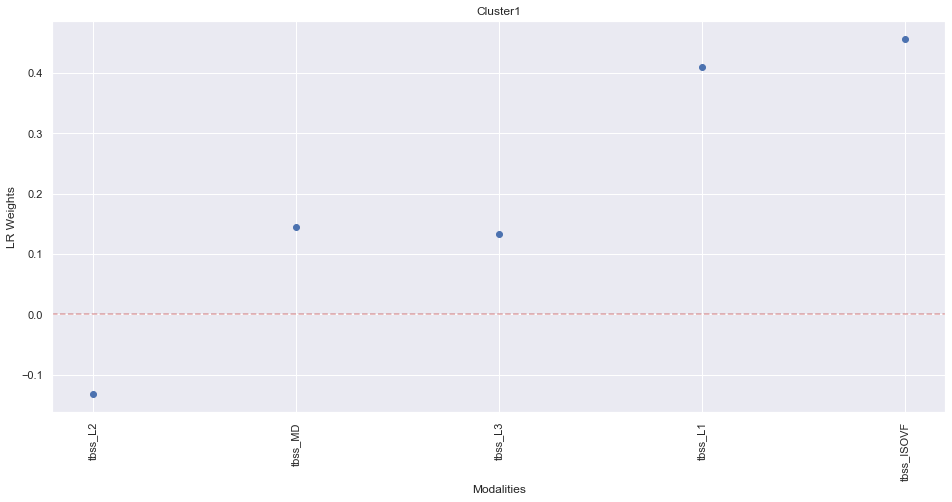

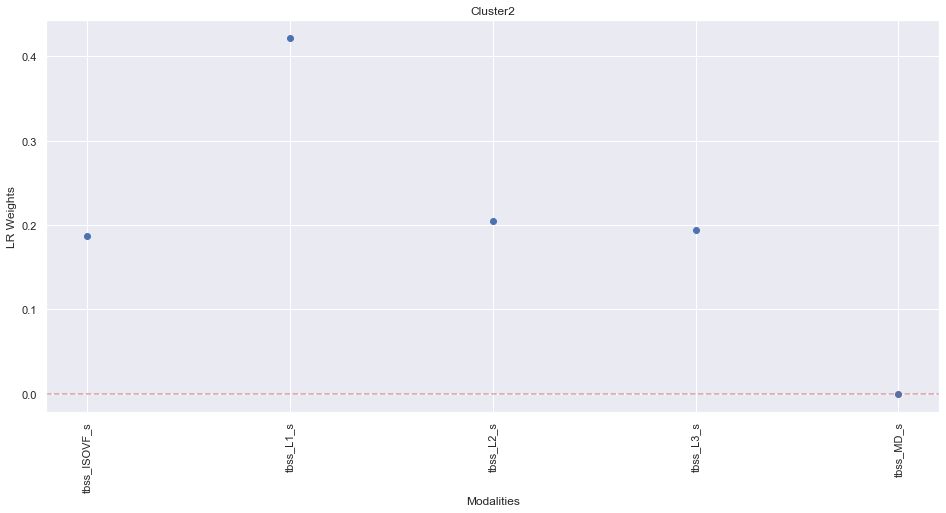

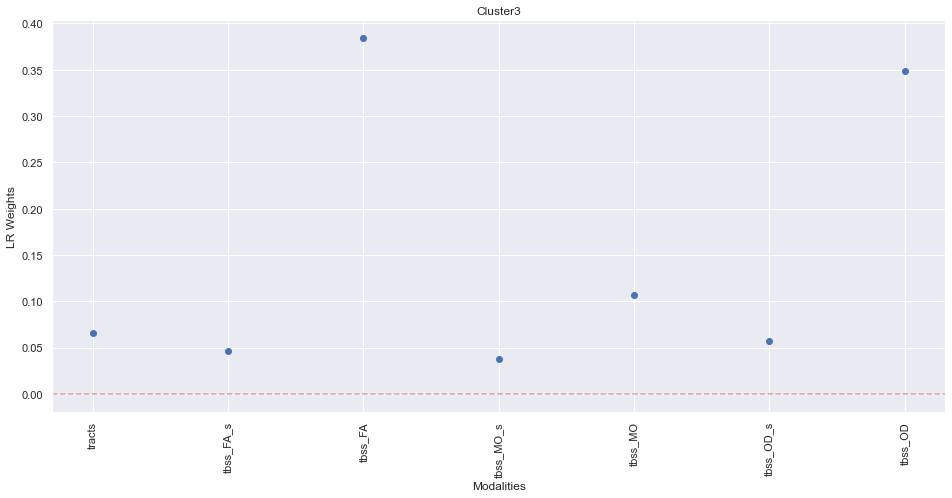

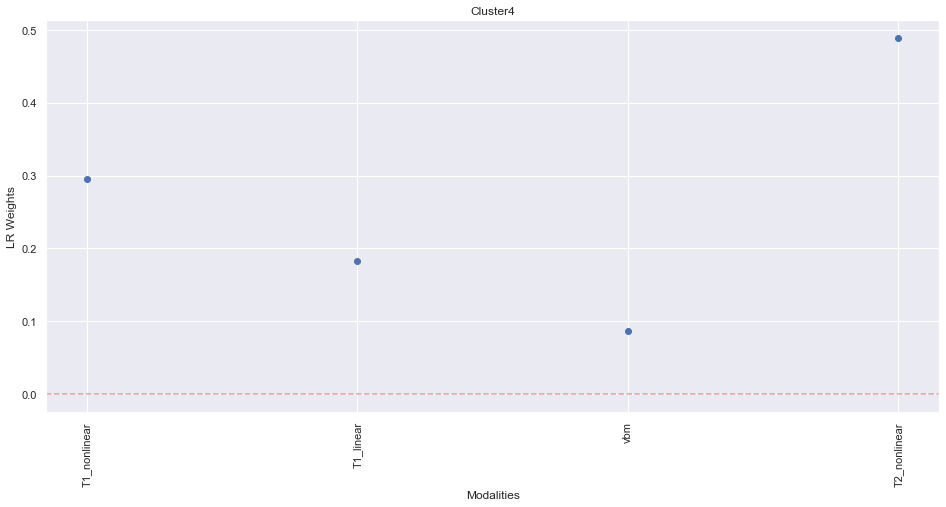

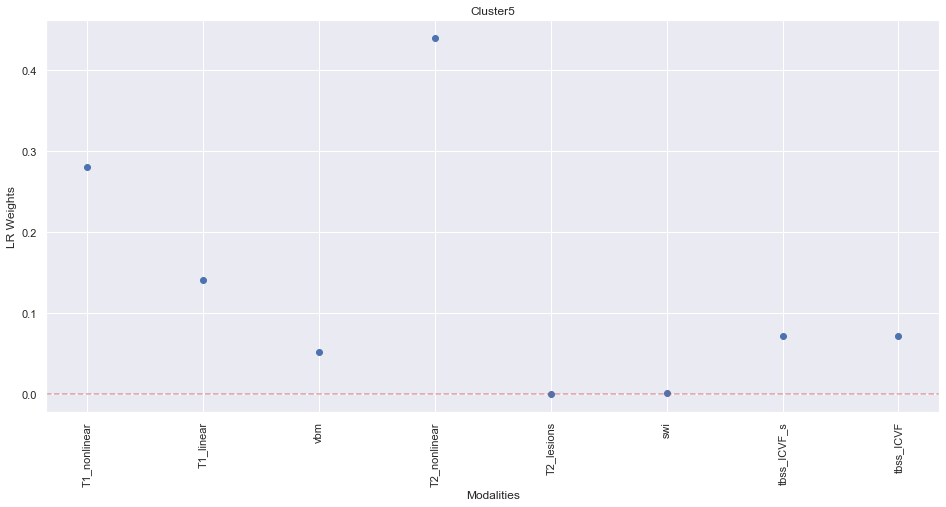

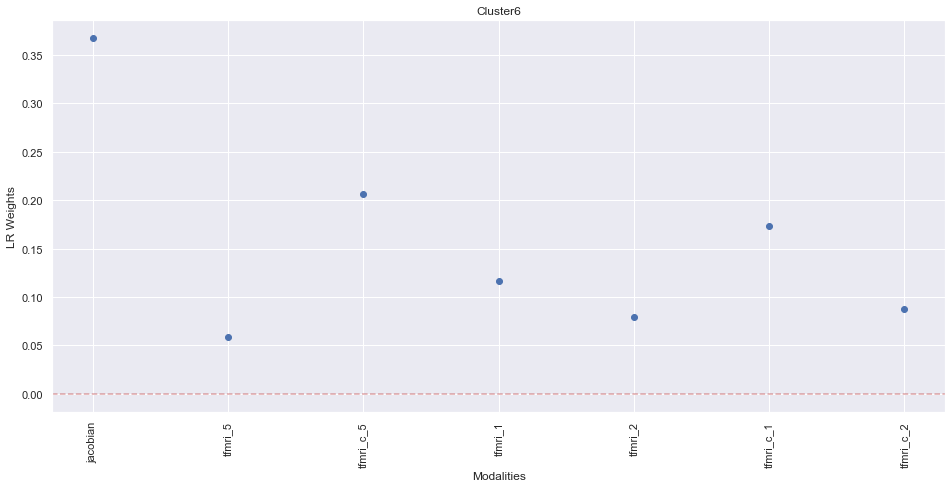

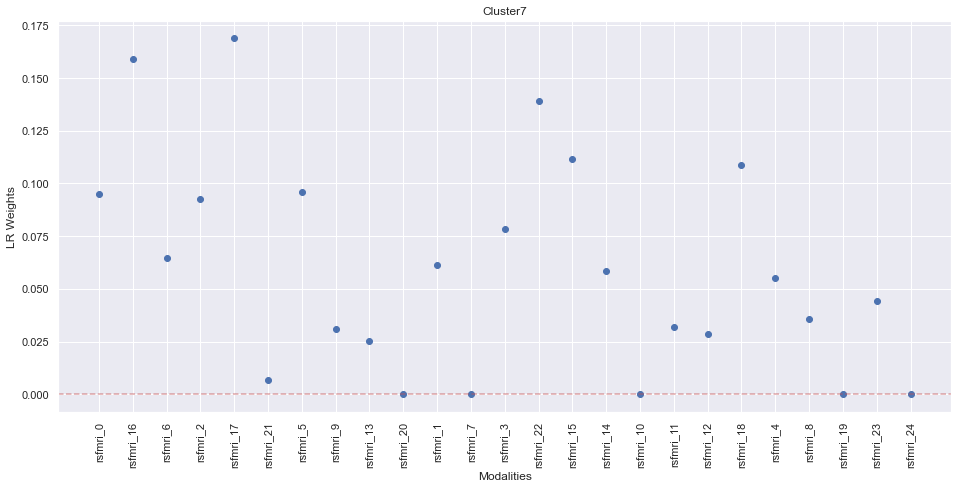

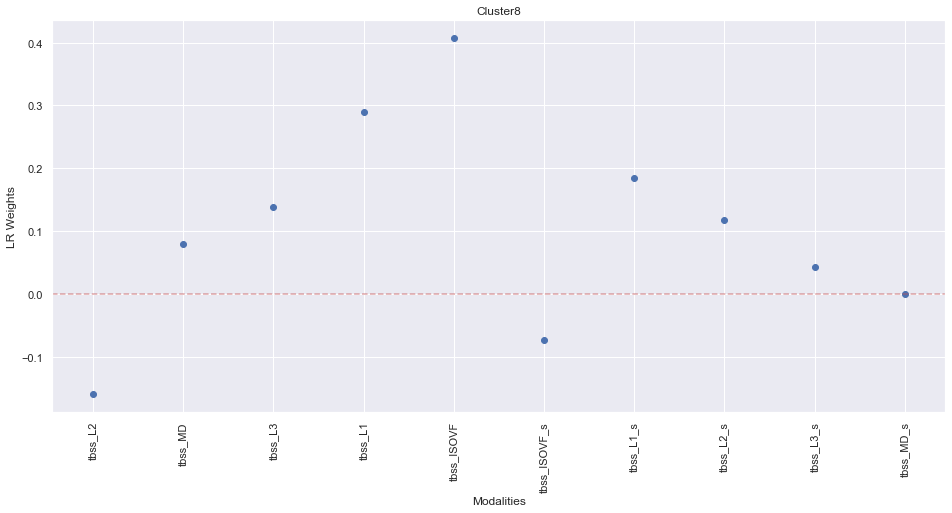

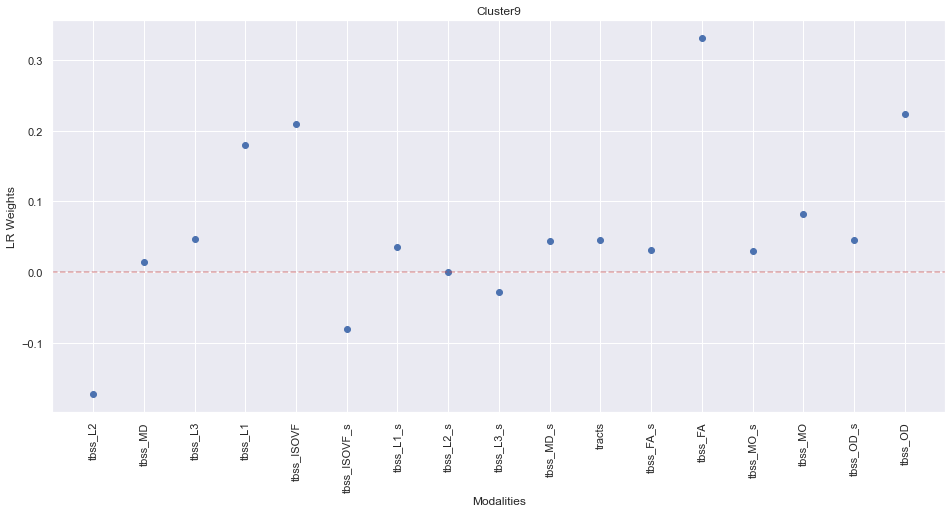

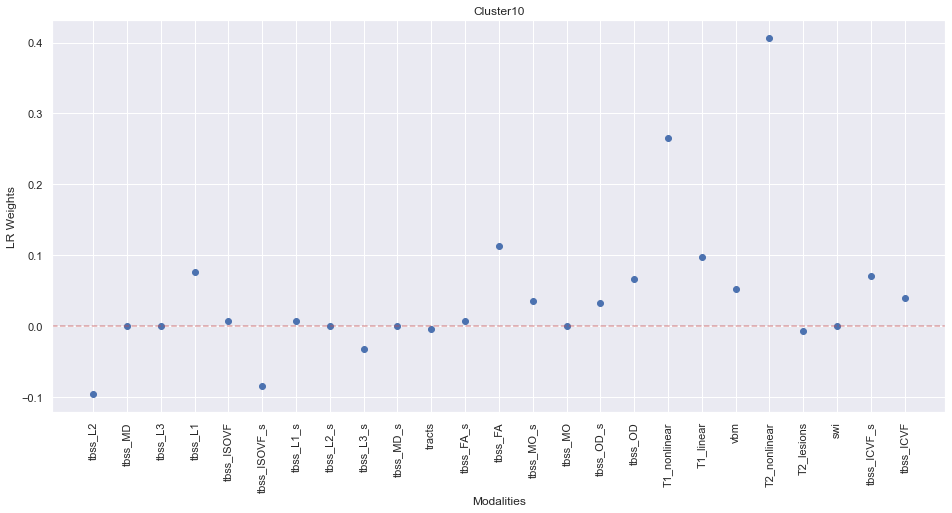

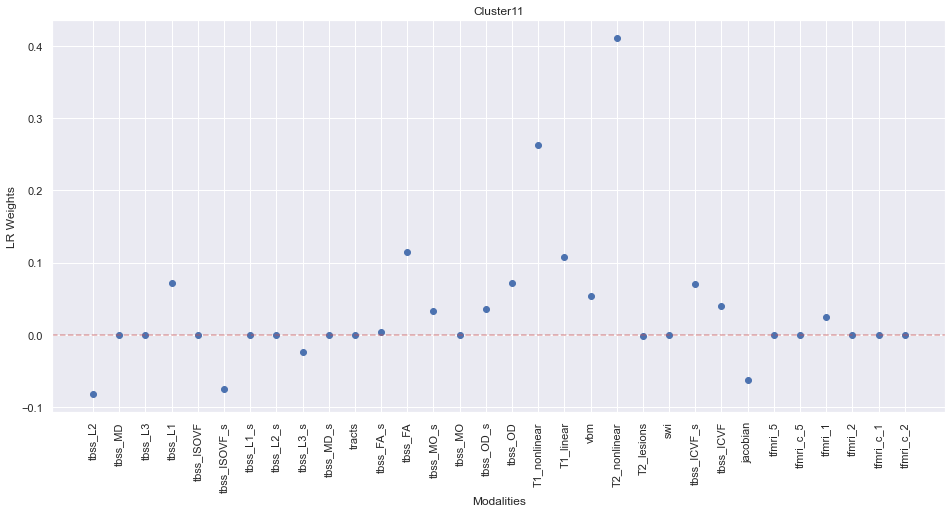

In [22]:
# (reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon,
#                 Age_Deltas_decon, Yhat, Age_Deltas)


idx = 1
for mod in mods:
    x = ElasticNet_wrap(df_train, df_test, modalities=mod, 
                   number_of_modalities=None, show_plots=False, verbose=False,
                   cross_validation_flag = True, deconfound=True)
    print('mods:', idx, '|', x[3])
    print(x[0].alpha_, x[0].l1_ratio_)
     
    cluster_name = 'Cluster' + str(idx)
    
    plt.figure(figsize=(16, 7.2))
    plt.scatter(np.arange(0, x[5].shape[0]), x[1])
    plt.xticks(np.arange(0, x[5].shape[0]), mod, rotation=90);
    plt.xlabel("Modalities")
    plt.ylabel("LR Weights")
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
    plt.title(cluster_name)

    idx +=1
    
    df_output = pd.DataFrame.from_dict({
    'modality': cluster_name,
#     'dataframe': [pd.DataFrame.from_dict({
#             'Unnamed: 0': subjects_testB,
#             'age_delta_decon': x[10]
#             })]
#     })
    'dataframe': [pd.DataFrame.from_dict({
                    'Unnamed: 0': subjects_testB,
                    'age_delta_decon': x[10],
                    'mean_age_delta': x[12],
                    'target_age': df_testB.target_age.values,
                    'mean_output_age': x[11]
                    })]
    })

    if os.path.exists(output_name):
        df_ensambles = pd.read_pickle(output_name)
        if df_output.iloc[0].modality in df_ensambles.modality.to_list():
#             iloc_idx = np.where(df_ensambles.modality.to_numpy() == df_output.iloc[0].modality)[0][0]
#             df_ensambles.iloc[iloc_idx].dataframe = pd.DataFrame.copy(df_output.iloc[0].dataframe)
#             df_output.to_pickle(output_name, protocol = 4)
            pass
        else:
            df_ensambles = pd.concat([df_ensambles, df_output])
            df_ensambles.to_pickle(output_name, protocol = 4)
    else:
        df_output.to_pickle(output_name, protocol = 4)

In [23]:
df_ensambles = pd.read_pickle(output_name)
df_ensambles

modality                                          dataframe
0             NaiveFull        Unnamed: 0  age_delta_decon  mean_age_de...
0  LinearRegressionFull        Unnamed: 0  age_delta_decon  mean_age_de...
0        ElasticNetFull        Unnamed: 0  age_delta_decon  mean_age_de...
0              Cluster1        Unnamed: 0  age_delta_decon  mean_age_de...
0              Cluster2        Unnamed: 0  age_delta_decon  mean_age_de...
0              Cluster3        Unnamed: 0  age_delta_decon  mean_age_de...
0              Cluster4        Unnamed: 0  age_delta_decon  mean_age_de...
0              Cluster5        Unnamed: 0  age_delta_decon  mean_age_de...
0              Cluster6        Unnamed: 0  age_delta_decon  mean_age_de...
0              Cluster7        Unnamed: 0  age_delta_decon  mean_age_de...
0              Cluster8        Unnamed: 0  age_delta_decon  mean_age_de...
0              Cluster9        Unnamed: 0  age_delta_decon  mean_age_de...
0             Cluster10        Unnamed: 0  age_delta_decon  mean_age_de...
0             Cluster11        Unnamed: 0  age_delta_decon  mean_age_de...

MAE= 2.126614151959201
PR= 0.9340601645757087
Time To Complete: 0:00:44.647946
MAE Decon= 2.279200946541828
PR Decon= 0.9340601645757087


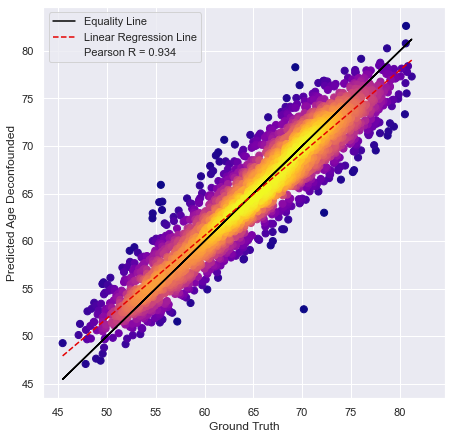

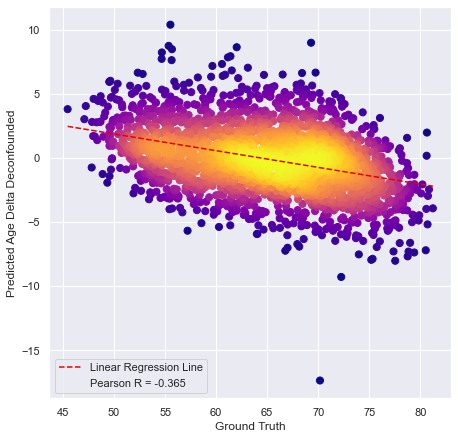

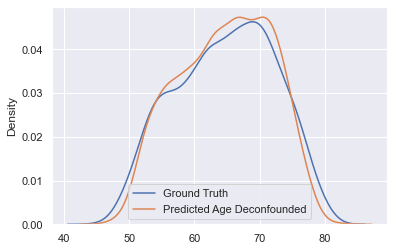

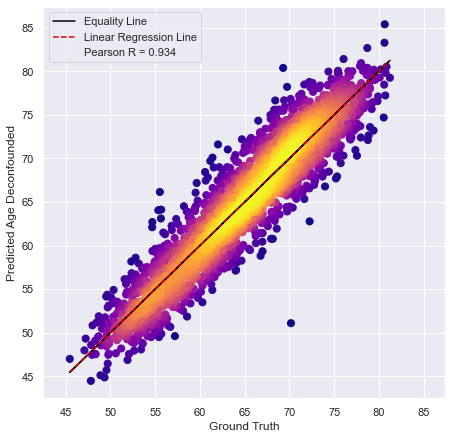

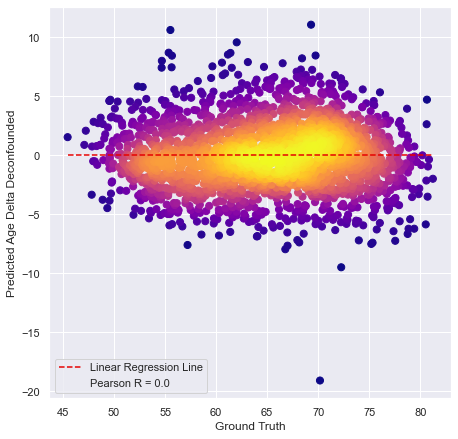

1.0871507207503517
-5.5881310749854975
0.17458415572072344 0.67


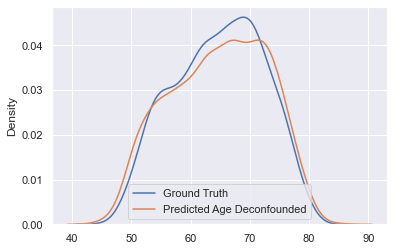

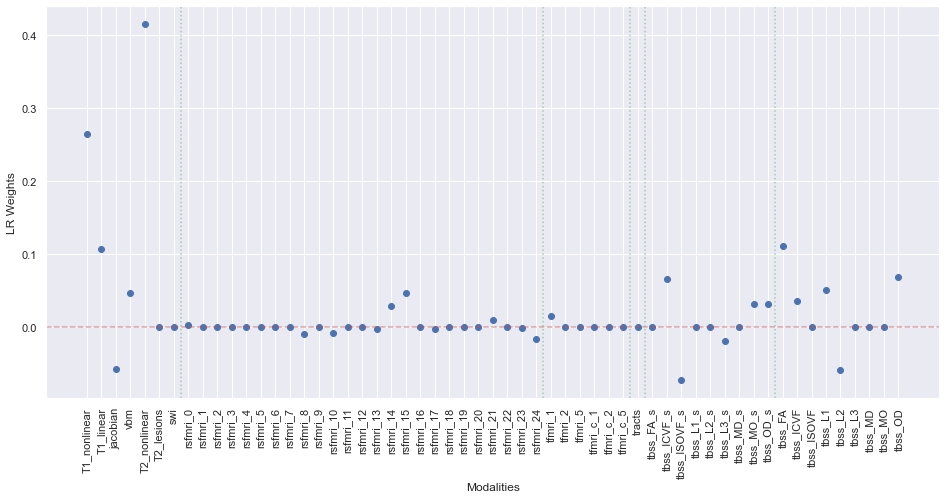

In [83]:
reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon = ElasticNet_wrap(
                    df_train, df_test, number_of_modalities=None, show_plots=True, verbose=True, 
                    cross_validation_flag = True, fix_alpha_one=False, deconfound=True)

plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), df.modality.to_list(), rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5);
print(coefficients.sum())
print(reg.intercept_)
print(reg.alpha_, reg.l1_ratio_)

MAE= 2.1183783674632632
PR= 0.9343758178489114
Time To Complete: 0:00:44.175578
MAE Decon= 2.270926924662678
PR Decon= 0.9343758178489114


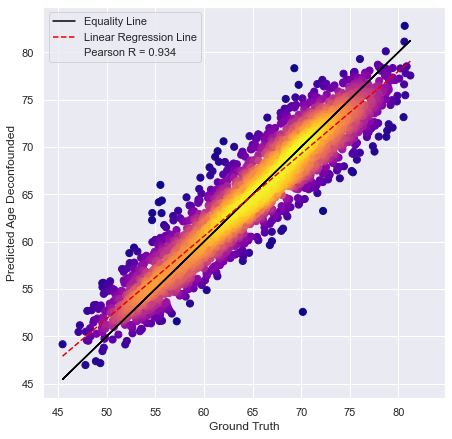

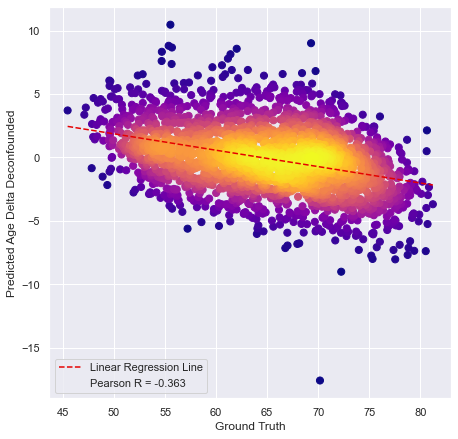

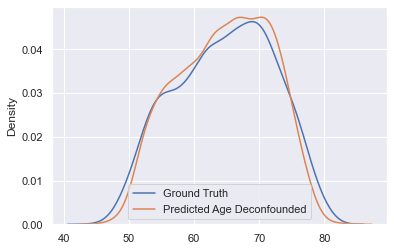

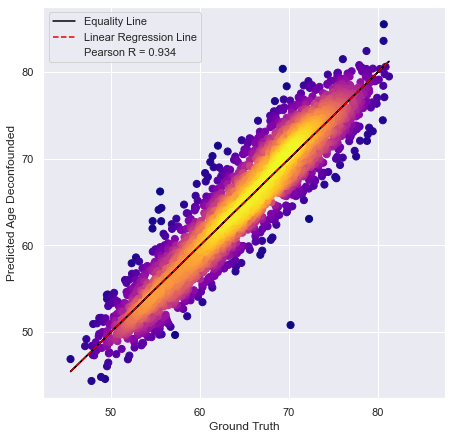

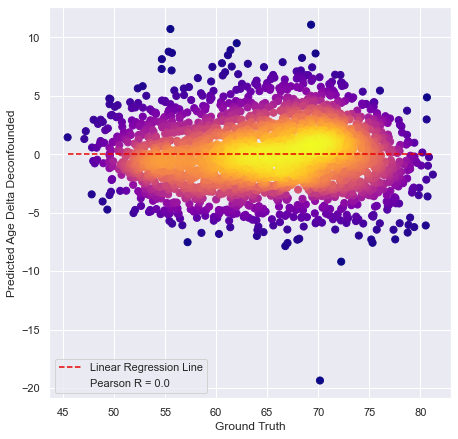

1.0527007728532047
-3.3266057704938277
0.16104508065353215 0.5


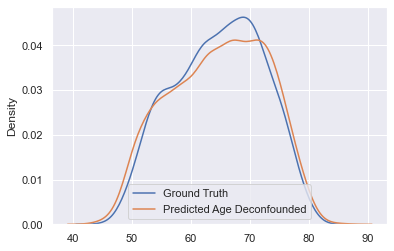

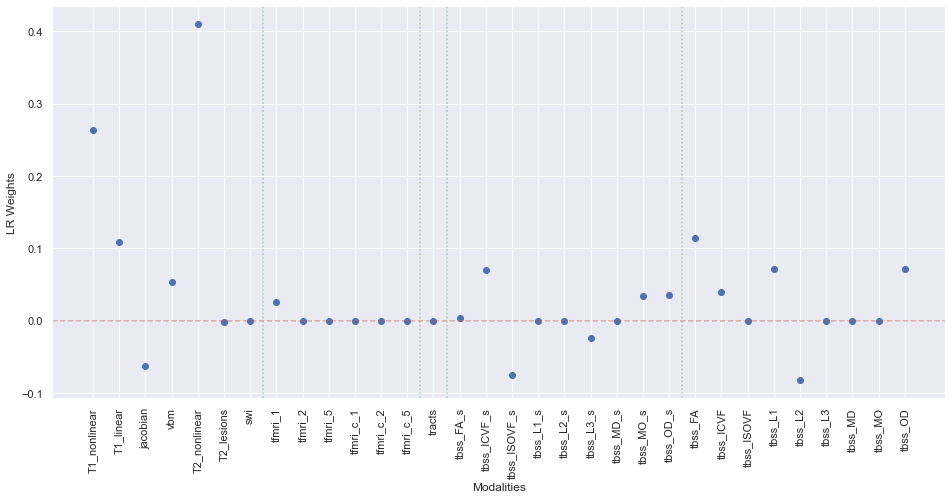

In [84]:
cluster11b=['T1_nonlinear','T1_linear','jacobian','vbm','T2_nonlinear','T2_lesions','swi','tfmri_1','tfmri_2',
'tfmri_5','tfmri_c_1','tfmri_c_2','tfmri_c_5','tracts','tbss_FA_s','tbss_ICVF_s','tbss_ISOVF_s','tbss_L1_s',
'tbss_L2_s','tbss_L3_s','tbss_MD_s','tbss_MO_s','tbss_OD_s','tbss_FA','tbss_ICVF','tbss_ISOVF','tbss_L1',
'tbss_L2','tbss_L3','tbss_MD','tbss_MO','tbss_OD']

reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon = ElasticNet_wrap(
                    df_train, df_test, modalities = cluster11b, number_of_modalities=None, show_plots=True, verbose=True, 
                    cross_validation_flag = True, fix_alpha_one=False, deconfound=True)

plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), cluster11b, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=12.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=13.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=22.5, color='g', linestyle='dotted', alpha=0.5);
print(coefficients.sum())
print(reg.intercept_)
print(reg.alpha_, reg.l1_ratio_)

MAE= 2.118373608424838
PR= 0.9343739916413054
Time To Complete: 0:00:42.293436
MAE Decon= 2.271006994323336
PR Decon= 0.9343739916413054


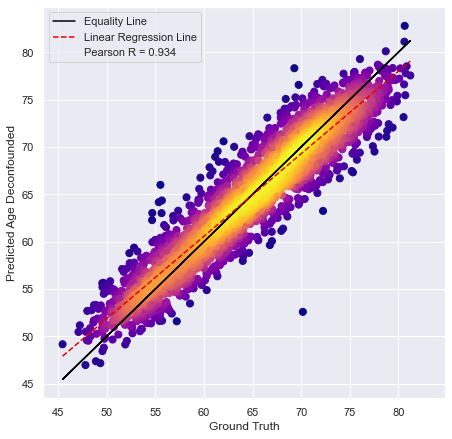

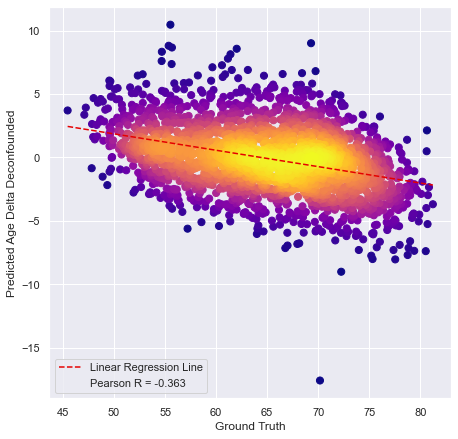

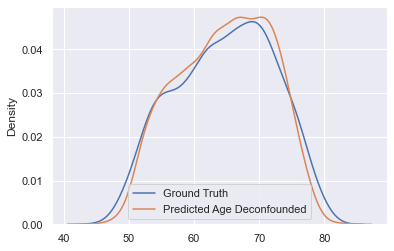

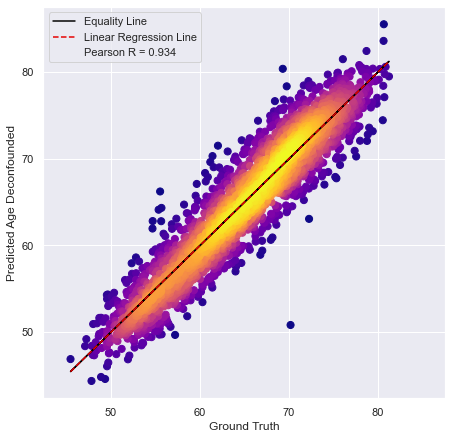

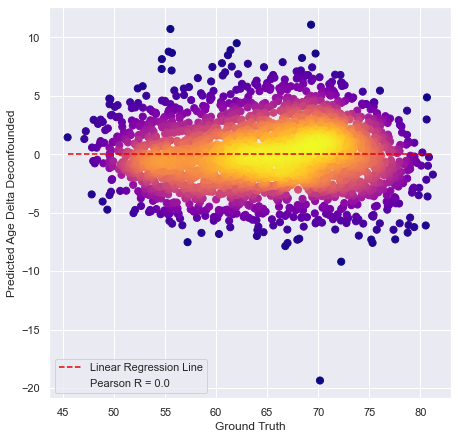

1.0527323913440625
-3.3286629348991568
0.1529835029426548 0.53


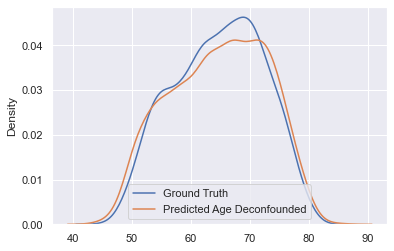

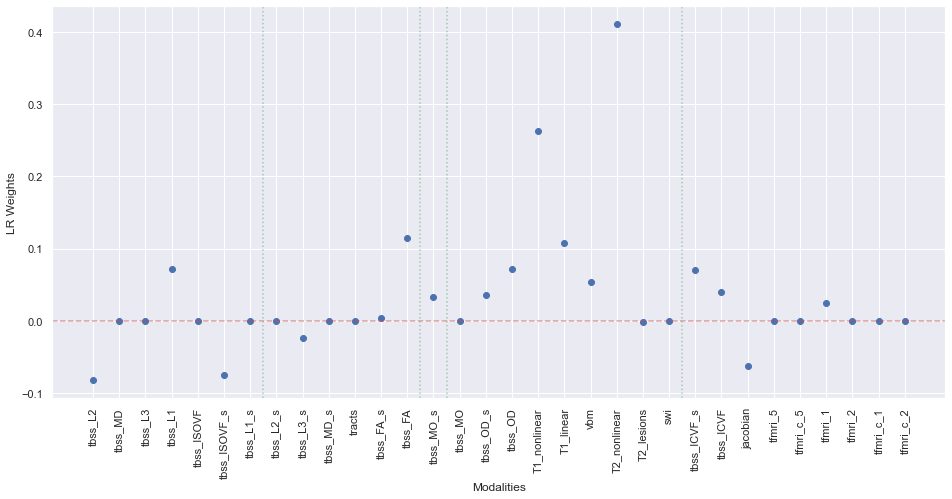

In [85]:
reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon = ElasticNet_wrap(
                    df_train, df_test, modalities = cluster11, number_of_modalities=None, show_plots=True, verbose=True, 
                    cross_validation_flag = True, fix_alpha_one=False, deconfound=True)

plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), cluster11, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=12.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=13.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=22.5, color='g', linestyle='dotted', alpha=0.5);
print(coefficients.sum())
print(reg.intercept_)
print(reg.alpha_, reg.l1_ratio_)

In [86]:
np.sort(np.array(cluster11)) == np.sort(np.array(cluster11b))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [87]:
np.array(cluster11b).sort()

In [88]:
df.modality.to_list()

['T1_nonlinear',
 'T1_linear',
 'jacobian',
 'vbm',
 'T2_nonlinear',
 'T2_lesions',
 'swi',
 'rsfmri_0',
 'rsfmri_1',
 'rsfmri_2',
 'rsfmri_3',
 'rsfmri_4',
 'rsfmri_5',
 'rsfmri_6',
 'rsfmri_7',
 'rsfmri_8',
 'rsfmri_9',
 'rsfmri_10',
 'rsfmri_11',
 'rsfmri_12',
 'rsfmri_13',
 'rsfmri_14',
 'rsfmri_15',
 'rsfmri_16',
 'rsfmri_17',
 'rsfmri_18',
 'rsfmri_19',
 'rsfmri_20',
 'rsfmri_21',
 'rsfmri_22',
 'rsfmri_23',
 'rsfmri_24',
 'tfmri_1',
 'tfmri_2',
 'tfmri_5',
 'tfmri_c_1',
 'tfmri_c_2',
 'tfmri_c_5',
 'tracts',
 'tbss_FA_s',
 'tbss_ICVF_s',
 'tbss_ISOVF_s',
 'tbss_L1_s',
 'tbss_L2_s',
 'tbss_L3_s',
 'tbss_MD_s',
 'tbss_MO_s',
 'tbss_OD_s',
 'tbss_FA',
 'tbss_ICVF',
 'tbss_ISOVF',
 'tbss_L1',
 'tbss_L2',
 'tbss_L3',
 'tbss_MD',
 'tbss_MO',
 'tbss_OD']

In [4]:
cluster1 = ['tbss_FA_s', 'tbss_L1_s', 'tbss_OD_s', 'tbss_MD', 'tbss_L1']
# Frequency of drinking alcohol (0.0)
cluster2 = ['tbss_OD', 'tbss_ICVF_s', 'tbss_FA', 'tbss_ISOVF', 'tbss_L2']
# Var: IGF-1 (0.0)
cluster3 = ['T2_lesions', 'tbss_ISOVF', 'tbss_MD']
# Var: Central systolic blood pressure during PWA (2.0)
cluster4 = ['tbss_MD_s', 'tbss_L2_s', 'tbss_L3_s']
# Var: Treatment/medication code (1140860806 - ramipril)
cluster5 = ['tbss_ISOVF', 'tbss_L2_s', 'tbss_L2', 'tbss_ISOVF_s', 'tbss_L1']
# Var: Smoking status (0.0)

In [5]:
os.remove('male_ensembles_vars_select_testset.pkl')

mods: 1 | 2.917993067392358
0.5838419313996922 0.1
mods: 2 | 2.7011331545983843
0.6111562565582872 0.14
mods: 3 | 3.176023152112388
0.18659809717406864 0.24
mods: 4 | 3.7601653045645844
0.8072754548283851 0.1
mods: 5 | 3.051971225195109
0.14147498843028694 1.0


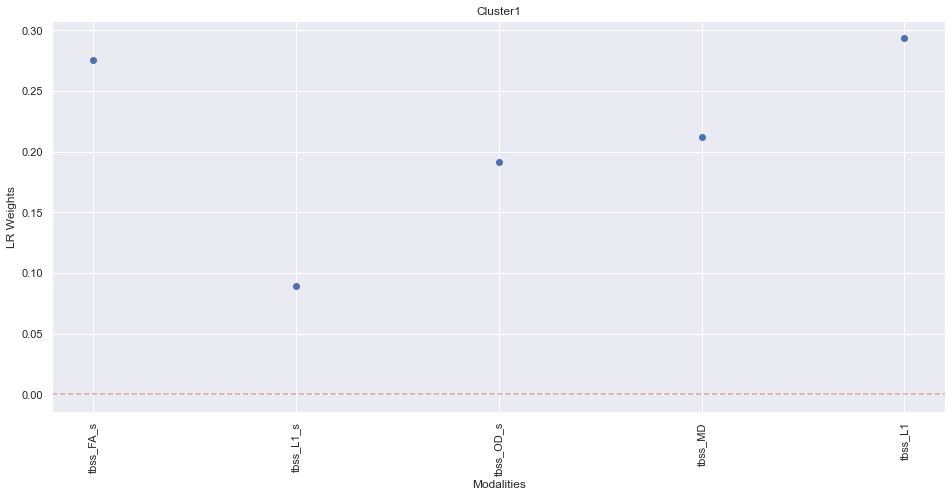

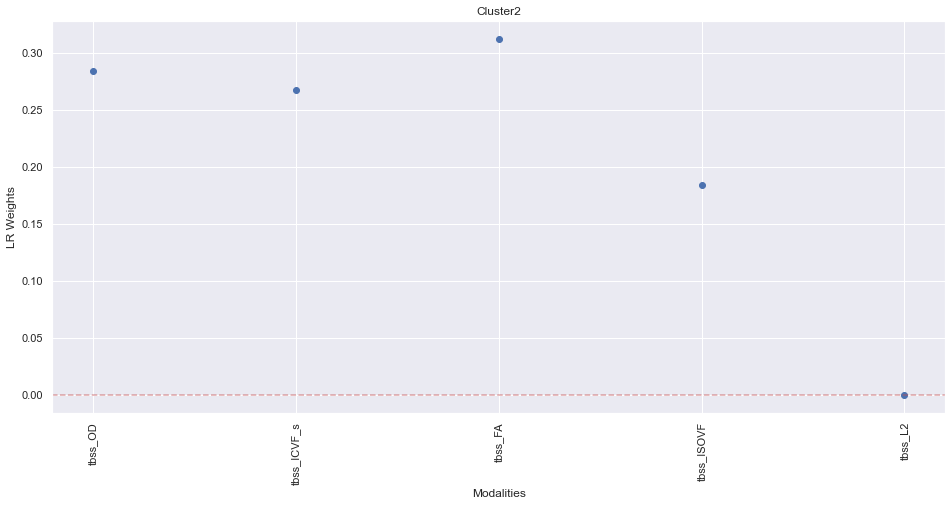

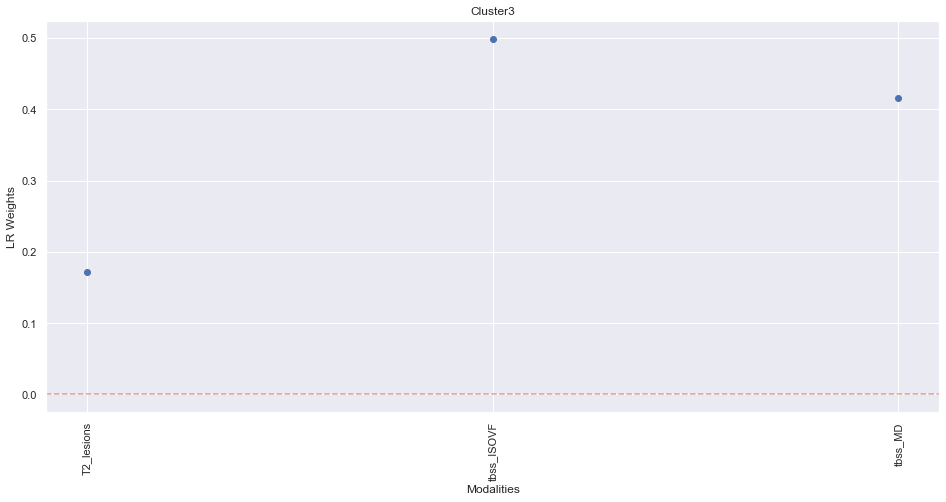

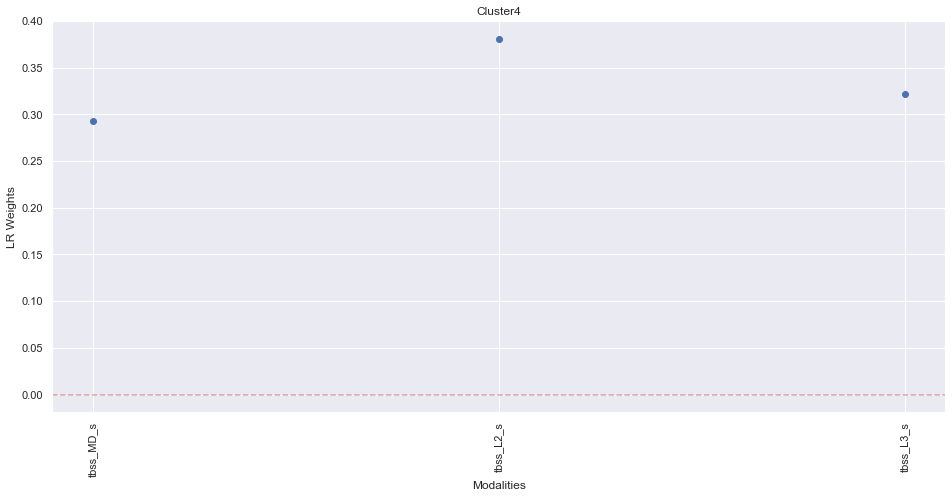

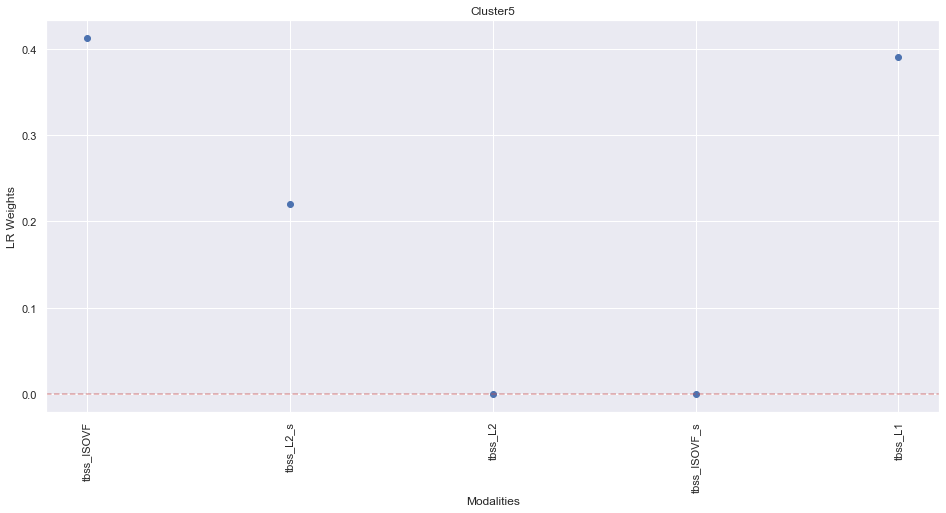

In [10]:
mods = [cluster1, cluster2, cluster3, cluster4, cluster5]

idx = 1
for mod in mods:
    x = ElasticNet_wrap(df_train, df_test, modalities=mod, 
                   number_of_modalities=None, show_plots=False, verbose=False,
                   cross_validation_flag = True, deconfound=True)
    print('mods:', idx, '|', x[3])
    print(x[0].alpha_, x[0].l1_ratio_)
     
    cluster_name = 'Cluster' + str(idx)
    
    plt.figure(figsize=(16, 7.2))
    plt.scatter(np.arange(0, x[5].shape[0]), x[1])
    plt.xticks(np.arange(0, x[5].shape[0]), mod, rotation=90);
    plt.xlabel("Modalities")
    plt.ylabel("LR Weights")
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
    plt.title(cluster_name)

    idx +=1
    
    df_output = pd.DataFrame.from_dict({
    'modality': cluster_name,
    'dataframe': [pd.DataFrame.from_dict({
            'Unnamed: 0': subjects_testB,
            'age_delta_decon': x[10]
            })]
    })

    output_name = 'male_ensembles_vars_select_testset.pkl'
    
    if os.path.exists(output_name):
        df_ensambles = pd.read_pickle(output_name)
        if df_output.iloc[0].modality in df_ensambles.modality.to_list():
#             iloc_idx = np.where(df_ensambles.modality.to_numpy() == df_output.iloc[0].modality)[0][0]
#             df_ensambles.iloc[iloc_idx].dataframe = pd.DataFrame.copy(df_output.iloc[0].dataframe)
#             df_output.to_pickle(output_name, protocol = 4)
            pass
        else:
            df_ensambles = pd.concat([df_ensambles, df_output])
            df_ensambles.to_pickle(output_name, protocol = 4)
    else:
        df_output.to_pickle(output_name, protocol = 4)

In [11]:
output_name = 'male_ensembles_vars_select_testset.pkl'
df_ensambles = pd.read_pickle(output_name)
df_ensambles

modality                                          dataframe
0  Cluster1        Unnamed: 0  age_delta_decon
0       2284...
0  Cluster2        Unnamed: 0  age_delta_decon
0       2284...
0  Cluster3        Unnamed: 0  age_delta_decon
0       2284...
0  Cluster4        Unnamed: 0  age_delta_decon
0       2284...
0  Cluster5        Unnamed: 0  age_delta_decon
0       2284...